#

infile = open('samplePosforPeaks', 'rb')
testarray = pickle.load(infile)
extract_boundaries(testarray, height = 0.001)

# Import all the libraries that we need

In [1]:
%matplotlib inline
import csv
import datetime
import fnmatch
import glob
import itertools
from itertools import groupby
import math
import matplotlib.cbook
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.polynomial.polynomial import polyfit
import os
import pandas as pd
import pickle
import platform
from pylab import rcParams
import re
import scipy
from scipy import stats
from scipy.signal import find_peaks
import statistics
import warnings
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# Define #ROOT

In [2]:
###Set the notebook screen ratio for jupyter
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:85% !important; }</style>"))

notebookPath=os.path.dirname(os.path.realpath("__file__"))
#pathToProcessingNotebooks=os.path.join(os.path.split(notebookPath)[0],"load_preprocess_rat")
#os.chdir(pathToProcessingNotebooks)   
#%run loadRat_documentationmod.ipynb
#%run plotRat_documentation_1_GeneralBehaviormod.ipynb

#### DEFINE ROOT
#folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/DATARUN ANALYSIS/test0722" #all distances" #DATARUN ANALYSIS/test0820
    savePath="/home/david/Desktop/Save"
else:
    #mac = 'Darwin'
    root="/Users/tom/Desktop/DATARUN/test0820" #current : test0826
    savePath="/Users/tom/Desktop"#os.path.join(root,"ALLRATS","Fig")
print("Root: ", root)

retval = os.getcwd()
print("Current working directory: %s" % retval)#print("Notebook Path: ", notebookPath)
print("Save Path: ", savePath)   
print("Path to data is: %s"%root)
print("")
print("importing done")

Root:  /home/david/Desktop/DATARUN ANALYSIS/test0722
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save
Path to data is: /home/david/Desktop/DATARUN ANALYSIS/test0722

importing done


# Define utility functions
# + details
# columns in file from LV

In [3]:
#conversion functions
#check if used 
def inch2cm(value):
    return value/2.54
def cm2inch(value):
    return value*2.54
def px2cm(value):
    return value/13.5

#function to split lists --> used to split the raw X position array into smaller arrays (runs and stays). Later in the code we modify the array and change some values to 0, which will be used as cutting points.
def split_a_list_at_zeros(List):
    return [list(g) for k, g in groupby(List, key=lambda x:x!=0) if k]

#function to open and read from the .position files using pandas, specify the path of the file to open, the column that you want to extract from, and the extension of the file
def read_csv_pandas(path,Col=None,header=None):
    #verify that the file exists
    if not os.path.exists(path):
        print("No file %s"%path)
        return []
    try:
        #open the file
        csvData=pd.read_csv(path,header=header,delim_whitespace=True)
    except ValueError:
        print("%s not valid (usually empty)"%path)
        return []
        #verify that the column that we specified is not empty, and return the values
    if Col is not None:
        return csvData.values[:, Col[0]]
    else:
        return csvData

# function to cut the 30min session (position plus time) into N bins of equal lenght, specify the data to cut (position), data template(we make the bins of a certain lenght so we use time), bot is where we start (usually 0, but can start later if we don't want the start), end is the end of what we want (usually the end of the session), binNumber is the number of bin that we want.
def bin_session(data_to_cut, data_template,  bot, end, binNumber):
    output={}
    for count in range(0, binNumber):
        start_of_bin = count*end/binNumber
        end_of_bin = count*end/binNumber+end/binNumber
        output[count] = data_to_cut[animal, session][np.logical_and(data_template[animal, session] >= start_of_bin, data_template[animal, session] < end_of_bin)]
        #print(boot, toop, output, len(output))    
    return output

#function to read the parameters for each rat for the session in the behav.param file. Specify the name of the parameter that you want to get from the file and optionally the value type that you want. File path is not an option, maybe change that.
def read_params(paramName, valueType=str):
    #define path of the file
    behav = root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".behav_param"
    #check if it exists
    if not os.path.exists(behav):
        print("No file %s" % behav)  
    #check if it is not empty
    #if os.stat(behav).st_size == 0:
        #print("File empty %s" % behav)
    #open the file
    with open(behav, "r") as f:
        #scan the file, if the name of the parameter is here, get the value 
        #scan the file
        for line in f:
            #if you look for a string do that
            if valueType is str:
                #find the line in which you have your parameter
                if paramName in line:
                    #get the last value of the line [-1], values are separated with _blanks_ with the .split() function
                    return int(line.split()[-1])  
                    #same if you want a float value, just convert the value
            if valueType is float: 
                if paramName in line:
                    return float(line.split()[-1])
            #can add other value type if needed (boolean, etc. )

# Load Data
### Data is loaded in one dictionary per variable (time, position, etc.) and have [animal, session] as keys, so we have a set of data for each session of each rat
### This cell loads all the behavioral data from the files created with labview

In [4]:
# initialise arrays and dicts

rawTime={}
rawPositionX={}
rawPositionY={}
extractPositionX = {}
extractPositionY = {}
extractTime = {}
extractLickLeft = {}
extractLickRight = {}
rawLickLeft1X = {}
rawLickRight1X = {}
rawLickLeft1Y = {}
rawLickRight1Y = {}


#create the list of the animals and sessions
animalindex=1
animalList = [os.path.basename(path) for path in sorted(glob.glob(root+"/Rat*"))]
for animal in animalList:
    print("Animal %s"%animal)
    print("%s out of %s" %(animalindex,len(animalList)))
    print("**********")
    animalindex += 1
    #Get the list of all session
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    sessionList=sorted(sessionList)
    nbSession=len(sessionList)
    
    #loop through animals and sessions
    for index, session in enumerate(sessionList):
        print("Session %s/%s: %s"%(index+1,nbSession,session), "['" +animal+ "\',\'" +session + "\']")

        acquisitionCutOff = read_params("sessionDuration")

        #load data for each session
        #data loaded : time array, position of the animal X and Y axis, Licks to the left and to the right
        extractTime[animal, session]      = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[3])#old format = 5
        extractPositionX[animal, session] = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[4])#old format = 6
        extractPositionY[animal, session] = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[5])
        extractLickLeft[animal, session]  = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[6])
        extractLickRight[animal, session] = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"),Col=[7])
        #directly cut the data at the end of the session  #explain
        rawTime[animal, session]       = extractTime[animal, session][extractTime[animal, session] <= acquisitionCutOff]
        rawPositionX[animal, session]  = extractPositionX[animal, session][extractTime[animal, session] <= acquisitionCutOff]
        rawPositionY[animal, session]  = extractPositionY[animal, session][extractTime[animal, session] <= acquisitionCutOff]
        rawLickLeft1X[animal, session]  = extractLickLeft[animal, session][extractTime[animal, session] <= acquisitionCutOff]
        rawLickLeft1Y[animal, session]  = extractLickLeft[animal, session][extractTime[animal, session] <= acquisitionCutOff]# not needed, to check
        rawLickRight1X[animal, session] = extractLickRight[animal, session][extractTime[animal, session] <= acquisitionCutOff]
        rawLickRight1Y[animal, session] = extractLickRight[animal, session][extractTime[animal, session] <= acquisitionCutOff]#

        # lick data as array of TRUE, FALSE values maybe change to real values in labview
        # change the false values to 0
        # change true to the position of the rat at this instant
        rawLickLeft1X[animal, session][rawLickLeft1X[animal, session]==True] = rawPositionX[animal, session][rawLickLeft1X[animal, session]==True]
        rawLickLeft1X[animal, session][rawLickLeft1X[animal, session]==False] = 0    
        rawLickRight1X[animal, session][rawLickRight1X[animal, session]==True] = rawPositionX[animal, session][rawLickRight1X[animal, session]==True]
        rawLickRight1X[animal, session][rawLickRight1X[animal, session]==False] = 0

        #same for Y position
        rawLickLeft1Y[animal, session][rawLickLeft1Y[animal, session]==False] = 0
        rawLickLeft1Y[animal, session][rawLickLeft1Y[animal, session]==True] = rawPositionY[animal, session][rawLickLeft1Y[animal, session]==True]
        rawLickRight1Y[animal, session][rawLickRight1Y[animal, session]==False] = 0
        rawLickRight1Y[animal, session][rawLickRight1Y[animal, session]==True] = rawPositionY[animal, session][rawLickRight1Y[animal, session]==True]


        print(animal, "Data loaded")
        print()   
#clear_output()

Animal RatF00
1 out of 8
**********
Session 1/1: RatF00_2020_07_22_13_17_25 ['RatF00','RatF00_2020_07_22_13_17_25']
RatF00 Data loaded

Animal RatF01
2 out of 8
**********
Session 1/1: RatF01_2020_07_22_13_49_33 ['RatF01','RatF01_2020_07_22_13_49_33']
RatF01 Data loaded

Animal RatF02
3 out of 8
**********
Session 1/1: RatF02_2020_07_22_14_36_11 ['RatF02','RatF02_2020_07_22_14_36_11']
RatF02 Data loaded

Animal RatF03
4 out of 8
**********
Session 1/1: RatF03_2020_07_22_15_07_14 ['RatF03','RatF03_2020_07_22_15_07_14']
RatF03 Data loaded

Animal RatM00
5 out of 8
**********
Session 1/1: RatM00_2020_07_22_15_38_49 ['RatM00','RatM00_2020_07_22_15_38_49']
RatM00 Data loaded

Animal RatM01
6 out of 8
**********
Session 1/1: RatM01_2020_07_22_16_09_59 ['RatM01','RatM01_2020_07_22_16_09_59']
RatM01 Data loaded

Animal RatM02
7 out of 8
**********
Session 1/1: RatM02_2020_07_22_16_41_19 ['RatM02','RatM02_2020_07_22_16_41_19']
RatM02 Data loaded

Animal RatM03
8 out of 8
**********
Session 1/1:

# LICKSTUFF TO DO
# Work in progress

# PARAMS
### Extract parameters from the behav.param files and create a dictionnary for each rat with every value
### * sessionDuration : duration of the session 
### * acqPer : number of acquisition per second in labview // not used here
### * waterLeft : (weight of the measuring cup + 10 drops of water - weight of the cup) --> Weight of 10 drops on the Left, in grams. divide by 10 to have weight of a drop, multiply by 1000 to have value in µL  
### * waterRight : idem on right  
### * treadmillSize : size of the treamdmill for the session #remove ?     
### *      "boundaryLeft"   #remove
### *      "boundaryRight"  #remove
### *      "middle"         #removed ?
### * weight : Weight of each rat just before the session 
### * lastWeightadlib : Weight of each rat when the water bottles are removed
### * lastDayadlib : Last day with ad lib water
### * daysSinceadlib : compute the number of days have elapsed since "lastDayadlib"
### * boundaries : initialise the boundary array, that is computed later -> define where (on the X axis) the rat is drinking
###
### * Create rat markers : used in plots, define a marker for each rat (e.g. in this experiment male and female symbols), and a color for each rat

In [5]:

params = {}
params[animal, session] = []
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList: 
        #create a dictionary and read the params wor each rat
        params[animal, session] = {
        "sessionDuration" : read_params("sessionDuration"),
        "acqPer" : read_params("acqPer"),
        "waterLeft" : round((read_params("waterLeft", valueType = float) - read_params("cupWeight", valueType = float))/10*1000, 2),
        "waterRight" : round((read_params("waterRight", valueType = float) - read_params("cupWeight", valueType = float))/10*1000, 2),  
        "treadmillSize" : read_params("treadmillSize"), #remove ?     
        "boundaryLeft" : read_params("boundaryLeft"),  #remove
        "boundaryRight" : read_params("boundaryRight"), #removed
        "middle"       : (read_params("boundaryLeft") + read_params("boundaryRight"))/2,  #removed ?
        "weight" : read_params("ratWeight"), 
        "lastWeightadlib" : read_params("ratWeightadlib"),
        "lastDayadlib" : read_params("lastDayadlib")
        }

        lastDayadlib = str(datetime.datetime.strptime(str(read_params("lastDayadlib")), "%Y%m%d").date())
        match = re.search(r'\d{4}_\d{2}_\d{2}', session)
        experimentDay = str(datetime.datetime.strptime(match.group(), '%Y_%m_%d').date())
        lastDayadlib = datetime.date(int(lastDayadlib[0:4]), int(lastDayadlib[5:7]), int(lastDayadlib[8:10]))
        experimentDay = datetime.date(int(experimentDay[0:4]), int(experimentDay[5:7]), int(experimentDay[8:10]))
        daysSinceadlib = experimentDay-lastDayadlib
        params[animal, session]["daysSinceadLib"] = daysSinceadlib.days
        #labview ok 27/07/2020 before nOk #format behavparam ?
        #catchup manual up to 27/07
        params[animal, session]["boundaries"] = []


In [6]:
#exclude bugged rat sessions (e.g. labview crash) from otherwise ok session
buggedRatSessions = ["", ""]

 #put complete list of invalid lick sessions, only analyze runs
lickBug = ["Rat000 Rat000_2020_08_22_19_07_01", ""]

#ideally put this in the loop above, but for now it keeps the bugged rat and removes the next one....
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList: 
        if animal + " " + session in buggedRatSessions:
            print("Rat Session %s discarded"%session)
            animalList.remove(animal)
            #sessionList.remove(session)
            print(animalList,"removed session: ", sessionList)
            print()
            
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList: 
        if all(v == 0 for v in rawLickLeft1X[animal, session]):
            params[animal, session]["hasLick"] = False
        elif all(v == 0 for v in rawLickRight1X[animal, session]):
            params[animal, session]["hasLick"] = False       
        elif animal + " " + session in lickBug:
            params[animal, session]["hasLick"] = False
        else:
            params[animal, session]["hasLick"] = True
        
        print("Lick data for this session: ", animal, params[animal, session]["hasLick"])

Lick data for this session:  RatF00 True
Lick data for this session:  RatF01 True
Lick data for this session:  RatF02 True
Lick data for this session:  RatF03 True
Lick data for this session:  RatM00 True
Lick data for this session:  RatM01 True
Lick data for this session:  RatM02 True
Lick data for this session:  RatM03 True


In [7]:
#print(round(params[animal, session]["waterLeft"], 1), "µL/drop")
#print(round(params[animal, session]["waterRight"], 1), "µL/drop")
#print()

#watL = 9.3
#watR = 9.6

water={}
water[animal, session] = {}
#modify that, 5% in a big drop is more than 5% in a small drop 
limitWater_diff = 5 #in%, if waterRight > waterLeft + X% or waterRight < waterLeft - X% we consider that Left is different from Right, maybe try 5% 

for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList: 

        watL = round(params[animal, session]["waterLeft"], 1)
        watR = round(params[animal, session]["waterRight"], 1)


        print(session)
        if watL-(watL*limitWater_diff/100) <= watR <= watL+(watL*limitWater_diff/100):
            print(watL-(watL*limitWater_diff/100))
            print(watL+(watL*limitWater_diff/100))
            water[animal, session] = ["Same Reward Size", "Same Reward Size", 2, 2]
            print("same L-R")
        elif watL < watR:
            print(watL, watR)
            water[animal, session] = ["Small Reward", "Big Reward", 1, 5]
            print("bigR")
        elif watL > watR:
            print(watL, watR)
            water[animal, session] = ["Big Reward", "Small Reward", 5, 1]
            print("bigL")
        else:
            print("error, bypass? Y/N")

RatF00_2020_07_22_13_17_25
8.93
9.870000000000001
same L-R
RatF01_2020_07_22_13_49_33
8.93
9.870000000000001
same L-R
RatF02_2020_07_22_14_36_11
8.93
9.870000000000001
same L-R
RatF03_2020_07_22_15_07_14
8.93
9.870000000000001
same L-R
RatM00_2020_07_22_15_38_49
8.93
9.870000000000001
same L-R
RatM01_2020_07_22_16_09_59
8.93
9.870000000000001
same L-R
RatM02_2020_07_22_16_41_19
8.93
9.870000000000001
same L-R
RatM03_2020_07_22_17_12_34
9.405000000000001
10.395
same L-R


In [8]:
rat_markers={}
rat_markers[animal] = {}
#palette = ['r', 'm', 'y', 'c', 'r', 'm', 'y', 'c']
palette = ['darkred', 'indianred', 'orangered', 'tomato', 'darkgreen', 'forestgreen', 'limegreen', 'chartreuse']
index = 0
for animal in animalList:
    # if the animal is F use Female symbol and 1 color per F rat
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[palette[index], "$\u2640$"]
        index+=1
    elif fnmatch.fnmatch(animal, 'RatM*'):
        #same for males, same colors but different symbol
        rat_markers[animal]=[palette[index], "$\u2642$"]
        index+=1  
        #if rat is not F or M (Rat000) use black and ? 
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[palette[index], "$\u2426$"]
        index+=1 
    else:
        print("error, bypass? Y/N")
        answer = input()
        if answer== 'Y':
            rat_markers[animal]= ['k',"$\u2426$"] 
        else:
            print("do nothing")

In [9]:
print(params)

{('RatM03', 'RatM03_2020_07_22_17_12_34'): {'sessionDuration': 1800, 'acqPer': 200, 'waterLeft': 9.89, 'waterRight': 9.89, 'treadmillSize': 90, 'boundaryLeft': 300, 'boundaryRight': 700, 'middle': 500.0, 'weight': 380, 'lastWeightadlib': 330, 'lastDayadlib': 20200720, 'daysSinceadLib': 2, 'boundaries': [], 'hasLick': True}, ('RatF00', 'RatF00_2020_07_22_13_17_25'): {'sessionDuration': 1800, 'acqPer': 200, 'waterLeft': 9.44, 'waterRight': 9.44, 'treadmillSize': 90, 'boundaryLeft': 300, 'boundaryRight': 700, 'middle': 500.0, 'weight': 220, 'lastWeightadlib': 180, 'lastDayadlib': 20200720, 'daysSinceadLib': 2, 'boundaries': [], 'hasLick': True}, ('RatF01', 'RatF01_2020_07_22_13_49_33'): {'sessionDuration': 1800, 'acqPer': 200, 'waterLeft': 9.44, 'waterRight': 9.44, 'treadmillSize': 90, 'boundaryLeft': 300, 'boundaryRight': 700, 'middle': 500.0, 'weight': 235, 'lastWeightadlib': 195, 'lastDayadlib': 20200720, 'daysSinceadLib': 2, 'boundaries': [], 'hasLick': True}, ('RatF02', 'RatF02_2020_

# BASE TRAJECTORY
### This first part is about plotting the X trajectory of the animals. Lick data was added on the base trajectory in a later version.

In [10]:
# This function plots the base trajectory of the rat. Parameters are time : time data, position : X position data, lickL/R, lick data, maxminstep for x and y axis, color and marker of the plot, width of the axis, and x y labels
def plot_BASEtrajectory(time, position, lickLeft, lickRight, maxminstep, maxminstep2, color = [], marker = [], linewidth = [], xyLabels=["N","Bins"]):   
       
        plt.plot(time, position, color=color[0], marker=marker[0], linewidth = linewidth[0])
        plt.plot(time, [None if x == 0 else x for x in lickLeft], color=color[1], marker=marker[1], markersize = marker[2])
        plt.plot(time, [None if x == 0 else x for x in lickRight], color=color[1], marker=marker[1], markersize = marker[2])

        ax = plt.gca()
        #ax.set_xlim(maxminstep[:2])
        #configure ax xy span
        ax.set_xlim(maxminstep[0]-maxminstep[2],maxminstep[1]+maxminstep[2])
        ax.set_ylim(maxminstep2[0]-maxminstep2[2],maxminstep2[1]+maxminstep2[2])
        #configure xy style
        ax.set_xlabel(xyLabels[1],fontsize=12,labelpad=0)
        ax.set_ylabel(xyLabels[0],fontsize=12,labelpad=-1)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.get_xaxis().set_tick_params(direction='out',pad=2)
        ax.get_yaxis().set_tick_params(direction='out',pad=2)
        #remove unnecessary axes
        ax.spines['top'].set_color("none")
        ax.spines['right'].set_color("none")
        return ax

In [11]:
# this function computes the value of the resting point of the animals, that we define as the boundary to determine where a run starts
# params : data : X position array, animal and session that we analyse, height = parameter to define a peak
# explanation : if you look at the histogram of the X position of the animal, you notice that there are two peaks that represent a position in which the animal spends a lot of time (i.e., the position in which they all stop, the reward port). We use a kernel density estimate (KDE) to get a fit curve over our data (red line on the histogram), we then have to compute the two peaks of this curve and get their position. We then add a "randomly" selected 50 px inwards and define these points as our boundaries.
def extract_boundaries(data, animal, session, height = None):
    if type(data)==list:
        #check if the data is a list
        #compute KDE of the data
        #for current pickle example or if there is a bug somewhere, but can be removed if not in use
        kde = stats.gaussian_kde(data)
    else:
        kde = stats.gaussian_kde(data.tolist())
    #get the curve and compute peaks
    nb_samples = 14000
    samples = np.linspace(0, 1400, nb_samples)
    probs = kde.evaluate(samples)
    maxima_index = find_peaks(probs, height) 
    # if there is more than two peaks (e.g. an animal decides to stay in the middle of the treadmill), only keep the two biggest peaks (should be the extremities) and remove the extra peak/s if there is one or more
    if len(maxima_index[1]["peak_heights"])>=3:
        #if we remove one peak or more, the index of the peak is displayed when computing
        print("computing", animal, np.argmin(maxima_index[1]["peak_heights"]))
        index = np.argmin(maxima_index[1]["peak_heights"])
        maxima_index[1]["peak_heights"] = np.delete(maxima_index[1]["peak_heights"], index)
        extractedBounds = np.delete(maxima_index[0], index)
        leftBoundaryPeak = samples[extractedBounds[0]]
        rightBoundaryPeak = samples[extractedBounds[1]]
    else:
        print("computing", animal)
        leftBoundaryPeak = samples[maxima_index[0][0]]
        rightBoundaryPeak = samples[maxima_index[0][1]]
    
    return leftBoundaryPeak, rightBoundaryPeak, kde


# this function plots the peak that we just extracted
def plot_peak(data, animal, session, leftBoundaryPeak, rightBoundaryPeak, kde, maxminstep, maxminstep2, marker = [], xyLabels=["N","Bins"]):

    #fig, ax = plt.subplots(figsize=(3,6))
    bins = np.arange(1400)
    xx = np.linspace(0, 1400, 1400)
    xline1 = [leftBoundaryPeak, leftBoundaryPeak]
    xline2 = [rightBoundaryPeak, rightBoundaryPeak]
    yline = [0, 0.01]

    if platform.system()== 'Darwin':
        ax.hist(data, normed=True, bins=bins, alpha=0.3, orientation='horizontal') #bugged on linux, working on mac

    ax.plot(kde(xx), xx, color = 'r')
    ax.plot(yline, xline1, ":", color='k')
    ax.plot(yline, xline2, ":", color='k')

    ax.plot(yline, [xline1[0]+border, xline1[0]+border], ":", color='k', alpha = 0.5)
    ax.plot(yline, [xline2[0]-border, xline2[0]-border], ":", color='k', alpha = 0.5)

    ax.set_xlim(maxminstep[0]-maxminstep[2],maxminstep[1]+maxminstep[2])
    ax.set_ylim(maxminstep2[0]-maxminstep2[2],maxminstep2[1]+maxminstep2[2])
    ax.set_xlabel(xyLabels[1],fontsize=12,labelpad=0)
    ax.set_ylabel(xyLabels[0],fontsize=12,labelpad=-1)
    ax.spines['top'].set_color("none")
    ax.spines['left'].set_color("none")
    ax.spines['right'].set_color("none")
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.get_xaxis().set_tick_params(direction='out',pad=2)
    ax.get_yaxis().set_tick_params(direction='out',pad=2)
    ax.axes.get_yaxis().set_visible(False)

    return ax

In [12]:
if animal + " " + session in ["Rat000 Rat000_2020_08_22_19_07_01"]:
    params[animal, session]["boundaries"] = [700, 300]

computing RatF00
plotting RatF00
computing RatF01
plotting RatF01
computing RatF02
plotting RatF02
computing RatF03
plotting RatF03
computing RatM00
plotting RatM00
computing RatM01
plotting RatM01
computing RatM02
plotting RatM02
computing RatM03
plotting RatM03


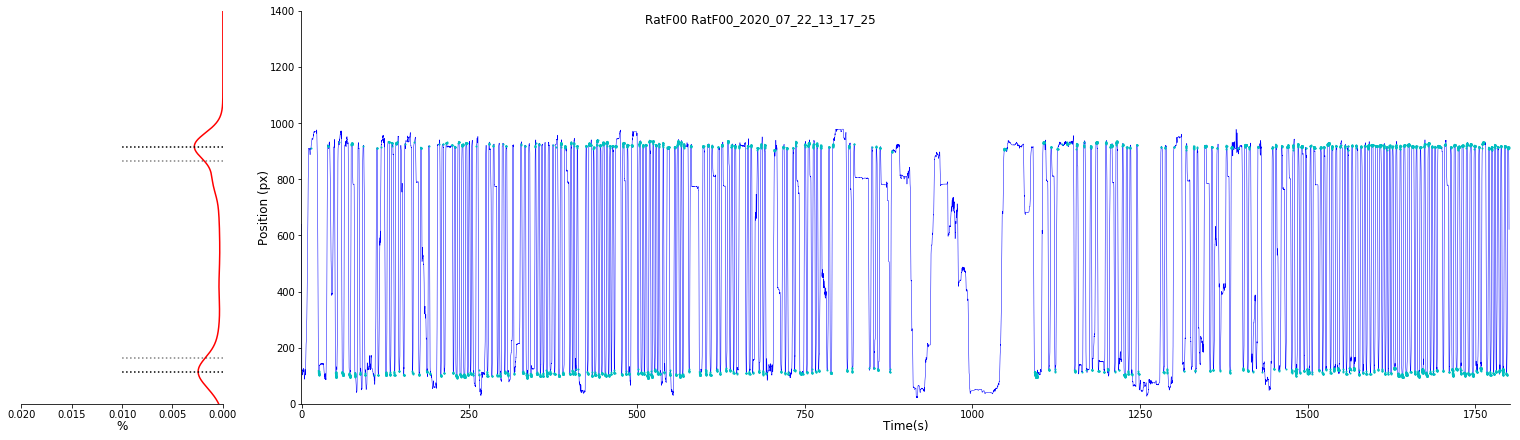

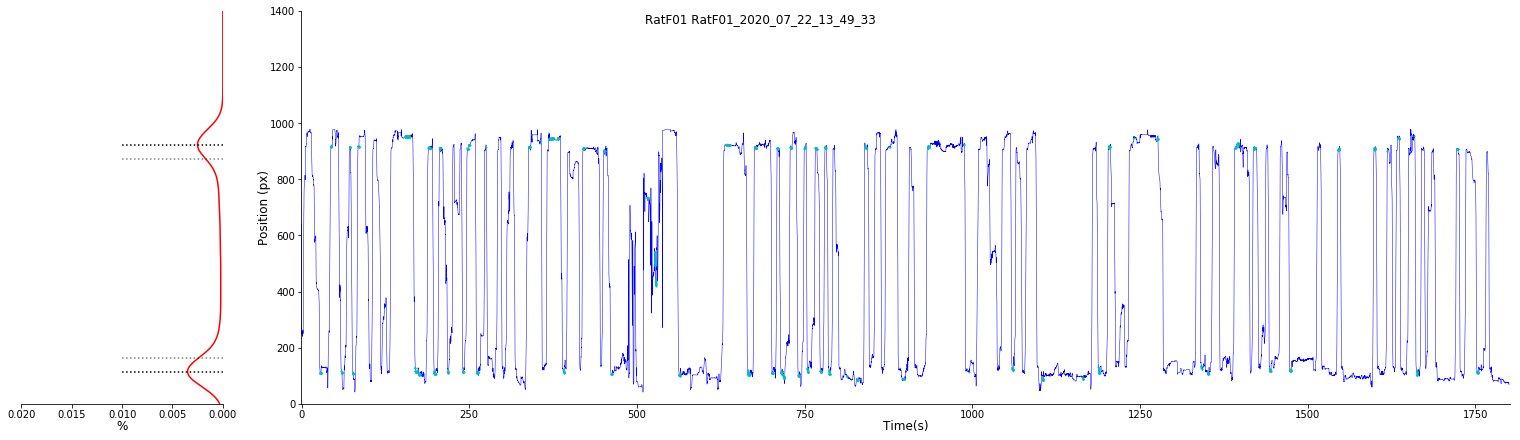

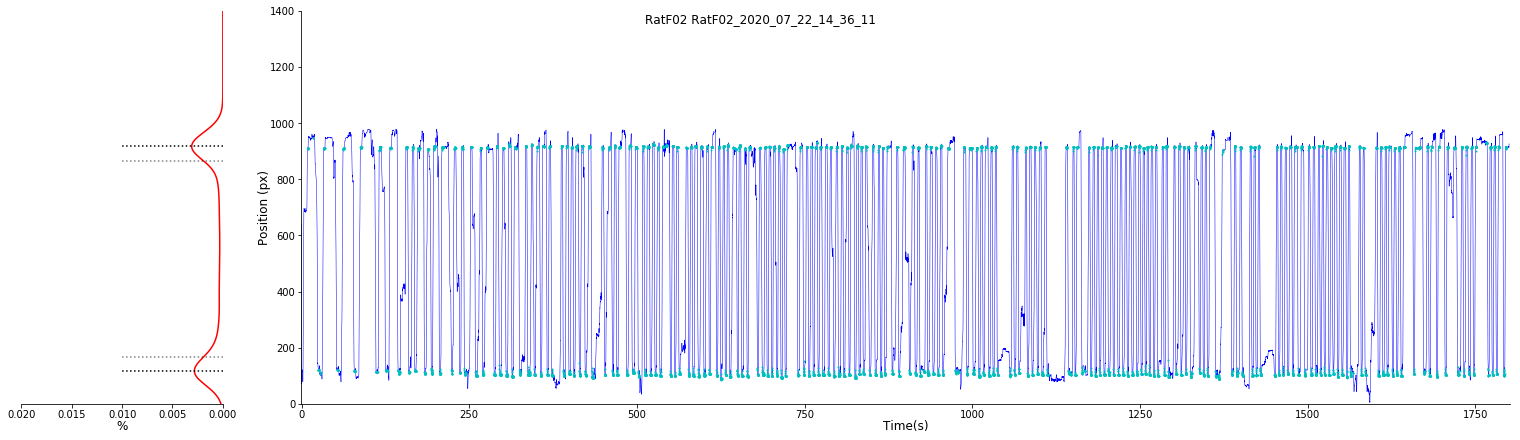

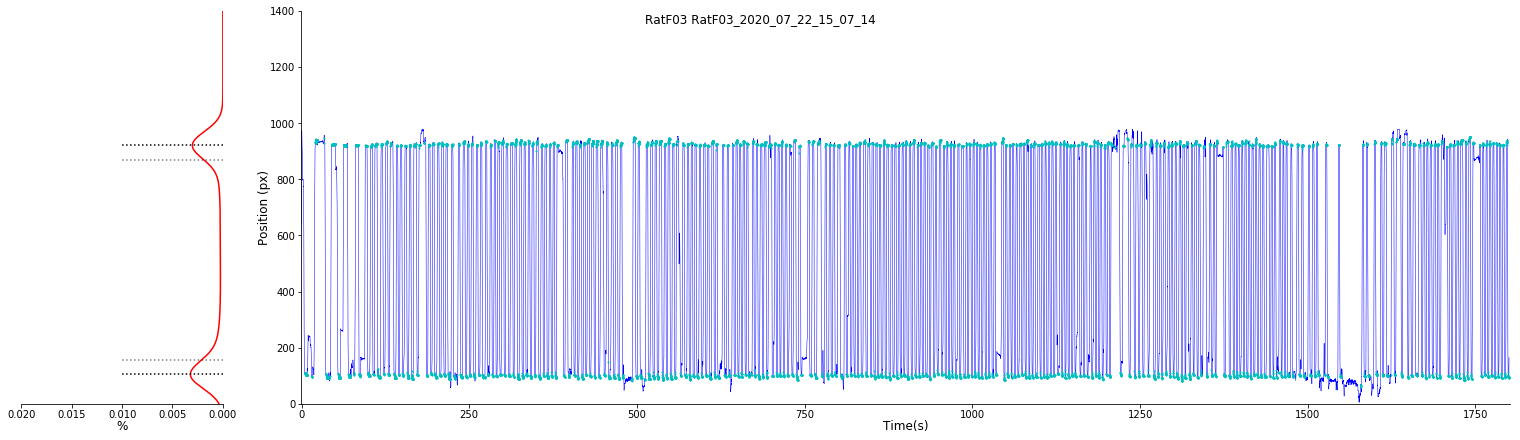

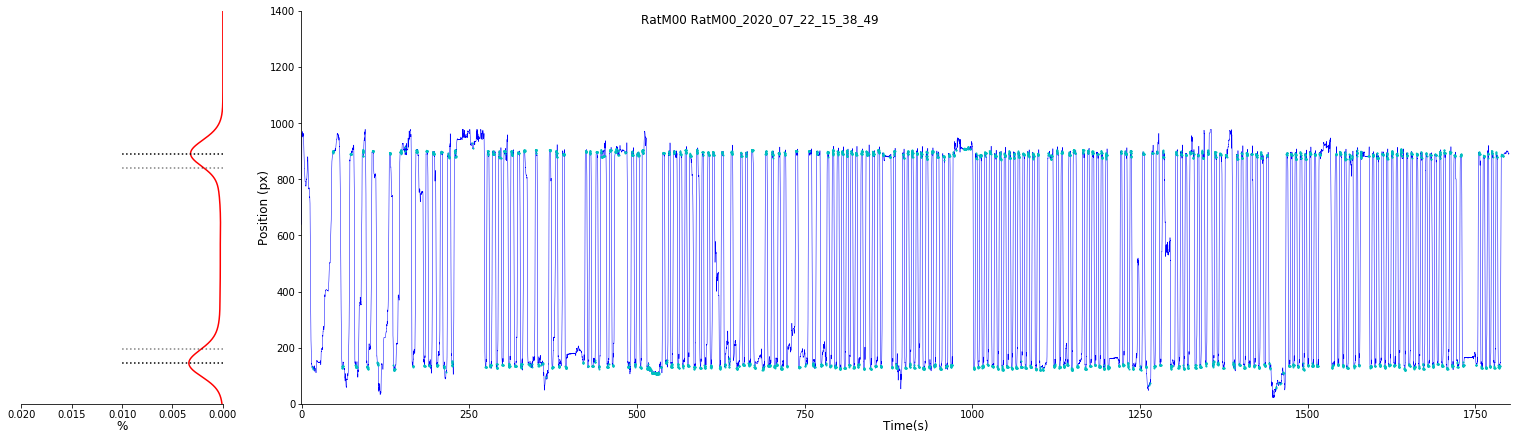

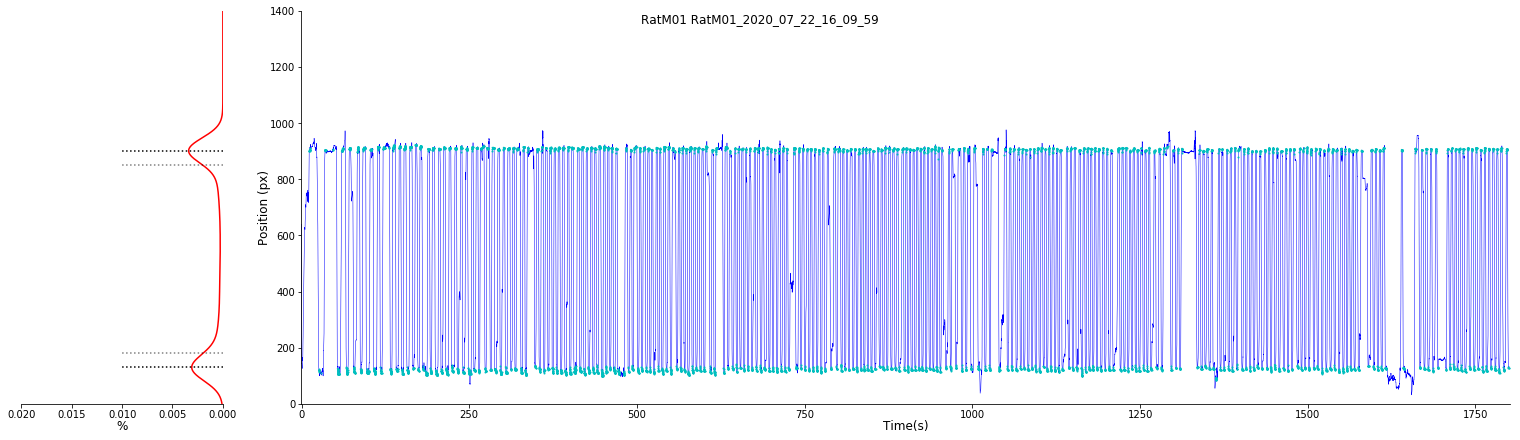

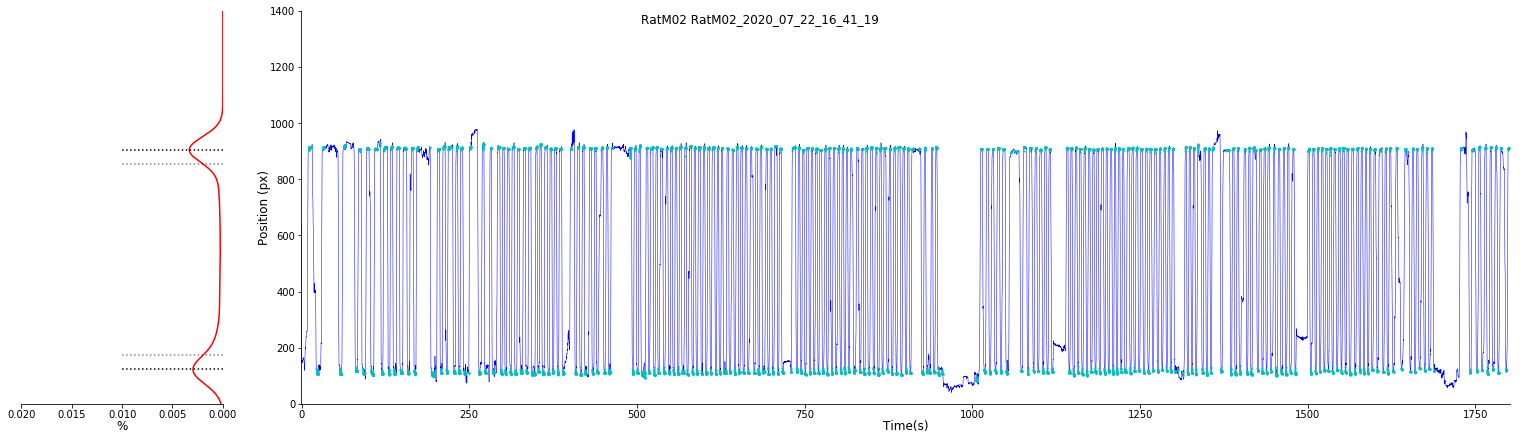

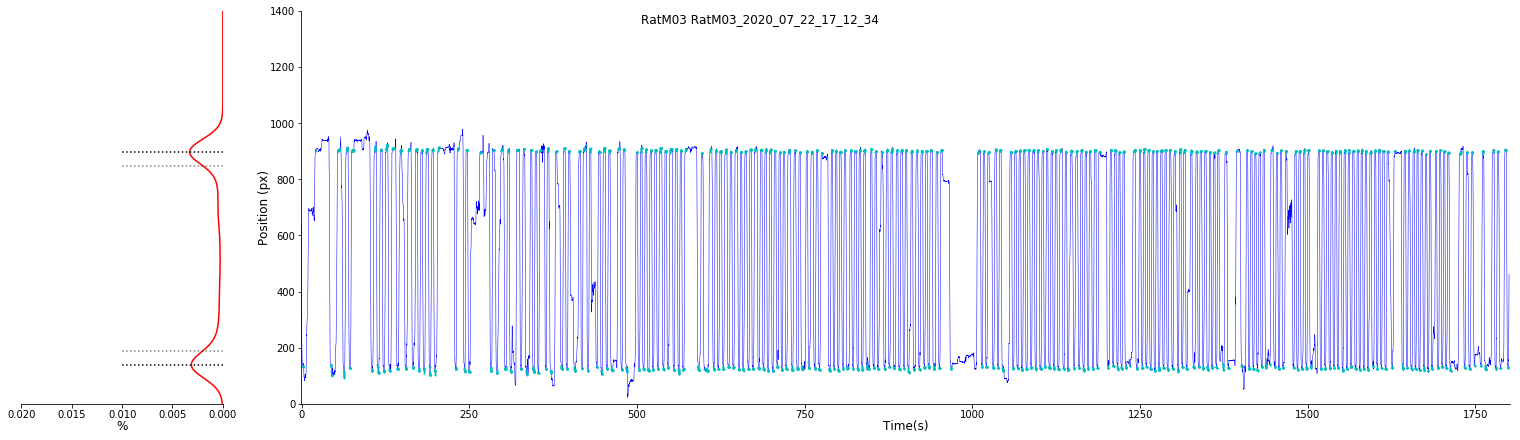

In [13]:
#problem leftBoundaryPEak, rightBoundaryPeak and kde are not created if we read the information from params
leftBoundaryPeak = {}
rightBoundaryPeak = {}
kde = {}
for animal in animalList:
#for animal in animalList[0:2]: # 2 rats for quick testing
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList: 

        if params[animal, session]["boundaries"] == []: #skip computing peaks if there is already a value computed and stored in params (value is [] when setting up all params so when running notebook for the first time peaks are computed)
            border = 50
            leftBoundaryPeak[animal, session], rightBoundaryPeak[animal, session], kde[animal, session]= extract_boundaries(rawPositionX[animal, session], animal, session, height = 0.001)
            params[animal, session]["boundaries"] = [rightBoundaryPeak[animal, session] - border, leftBoundaryPeak[animal, session] + border]

        print("plotting", animal)
        fig = plt.figure(constrained_layout=True, figsize=(21,6))
        fig.suptitle(animal + " " + session)
        widths = [3, 18]
        heights = [6]
        rows = 1
        cols = 2

        spec = fig.add_gridspec(ncols=cols, nrows=rows, width_ratios=widths, height_ratios=heights)
        index =0
        for row in range(rows):
            for col in range(cols):
                ax = fig.add_subplot(spec[row, col])
                
                if index == 0:
                    plot_peak(rawPositionX[animal, session], animal, session, leftBoundaryPeak[animal, session], rightBoundaryPeak[animal, session], kde[animal, session],[0.02, 0, 0],[0,1400,0],  marker = [""], xyLabels=["Position (px)", "%"])
                    index+=1
                    
                elif index == 1:
                    plot_BASEtrajectory(rawTime[animal, session],rawPositionX[animal, session], rawLickLeft1X[animal, session], rawLickRight1X[animal, session], [0,1800,1],[0,1400,1],  color = ["b", "c"], marker = ["", "o", 1], linewidth = [0.5], xyLabels=["Position (px)", "Time(s)"])
                    index+=1
       

RatF00 RatF00_2020_07_22_13_17_25
RatF01 RatF01_2020_07_22_13_49_33
RatF02 RatF02_2020_07_22_14_36_11
RatF03 RatF03_2020_07_22_15_07_14
RatM00 RatM00_2020_07_22_15_38_49
RatM01 RatM01_2020_07_22_16_09_59
RatM02 RatM02_2020_07_22_16_41_19
RatM03 RatM03_2020_07_22_17_12_34


<Figure size 1440x360 with 0 Axes>

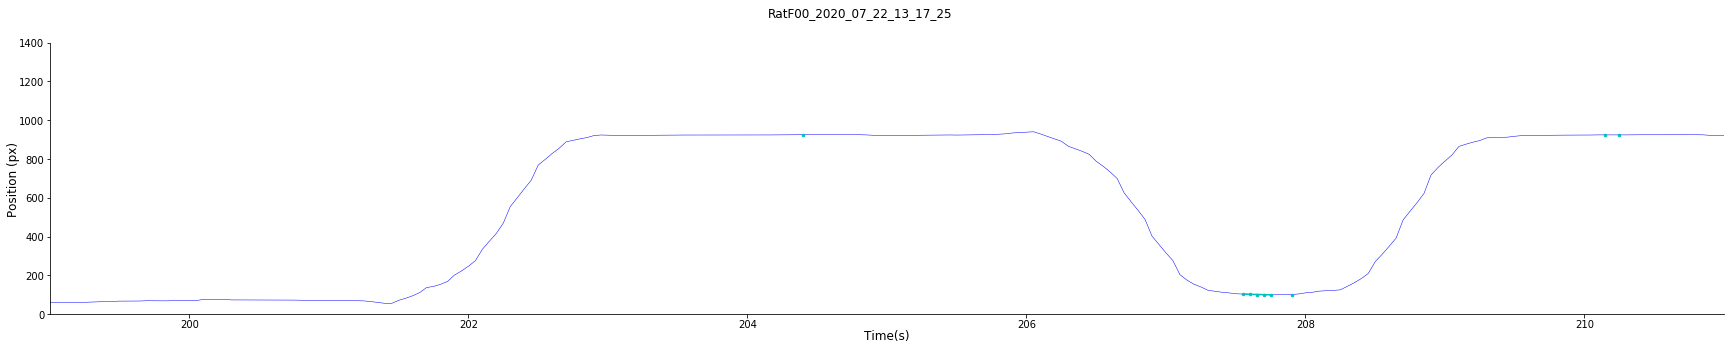

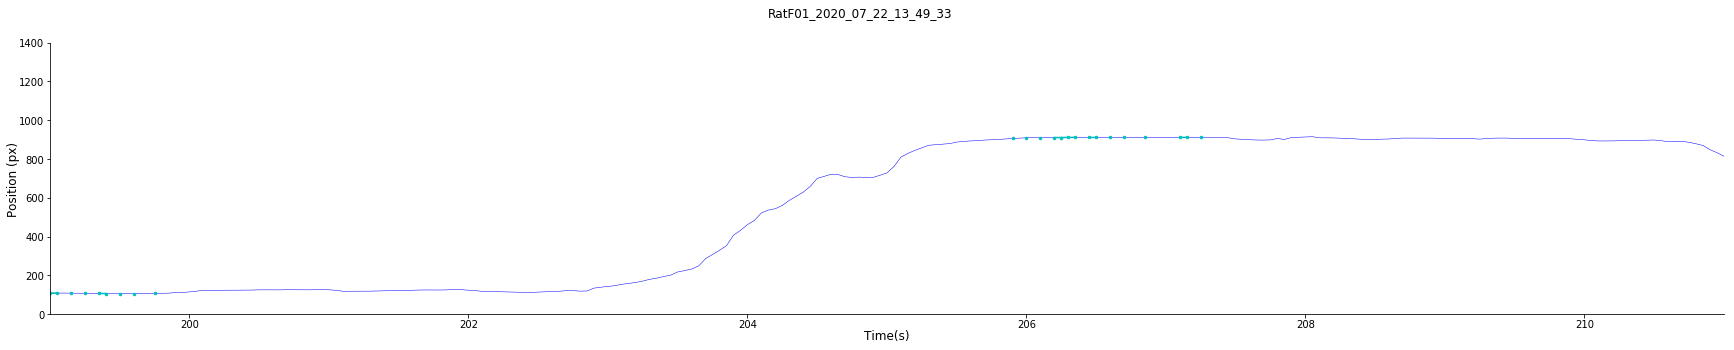

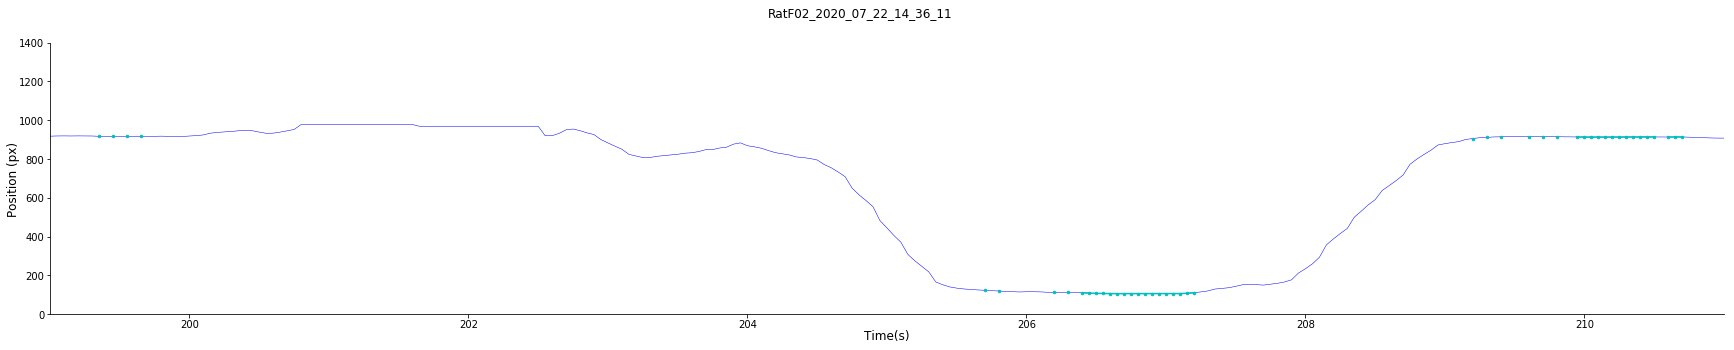

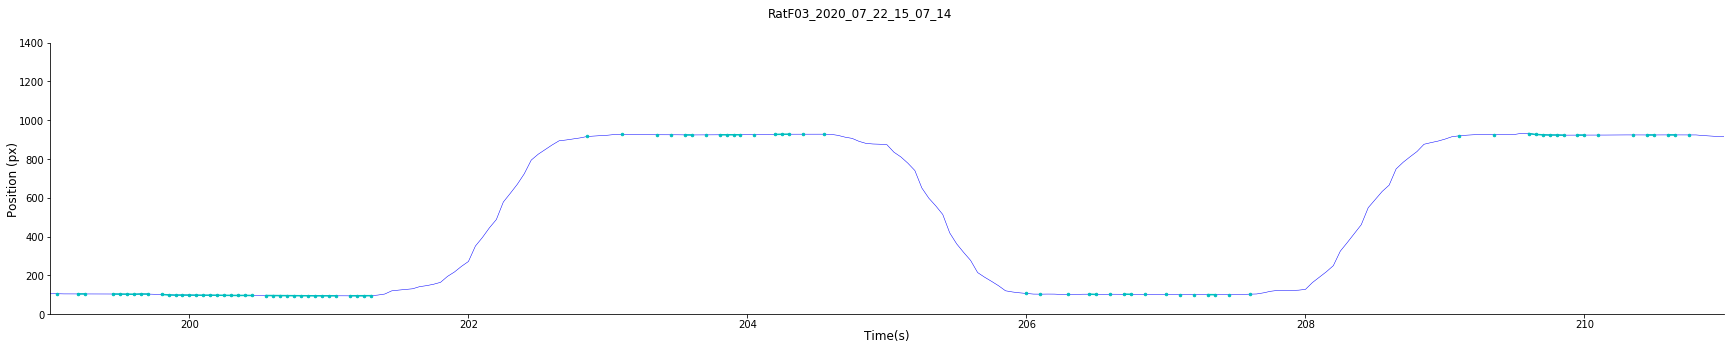

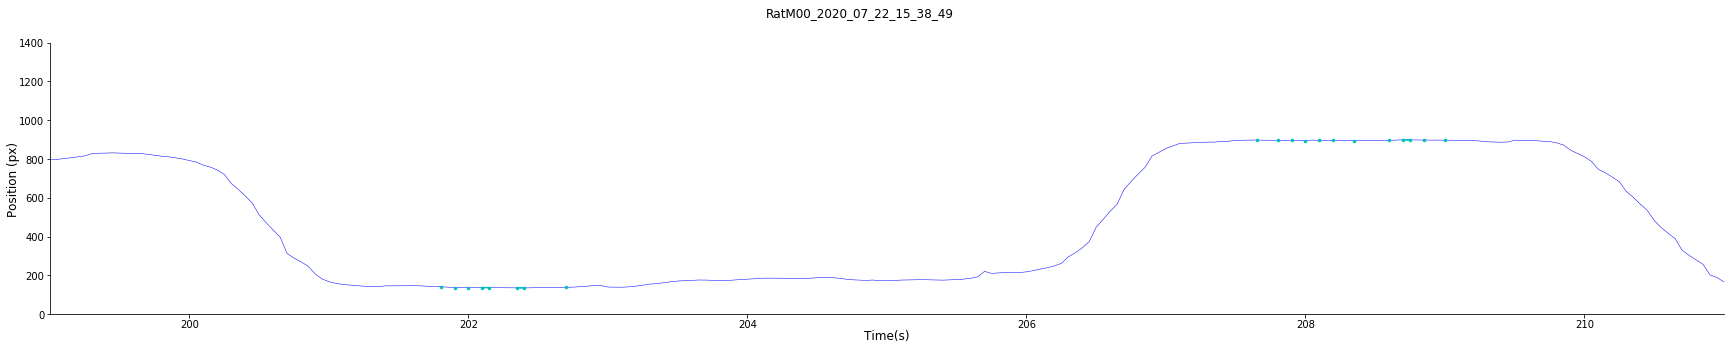

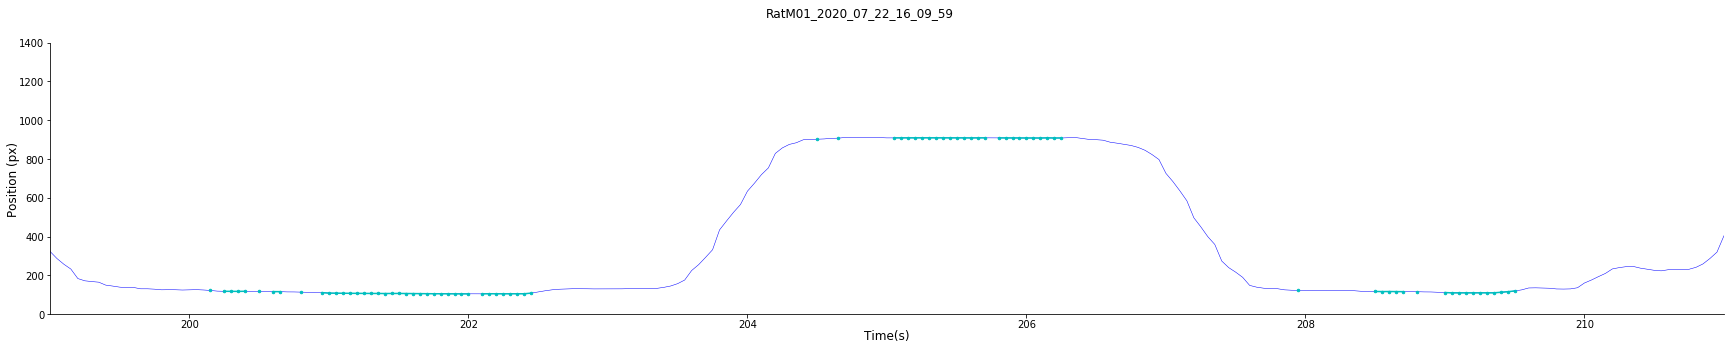

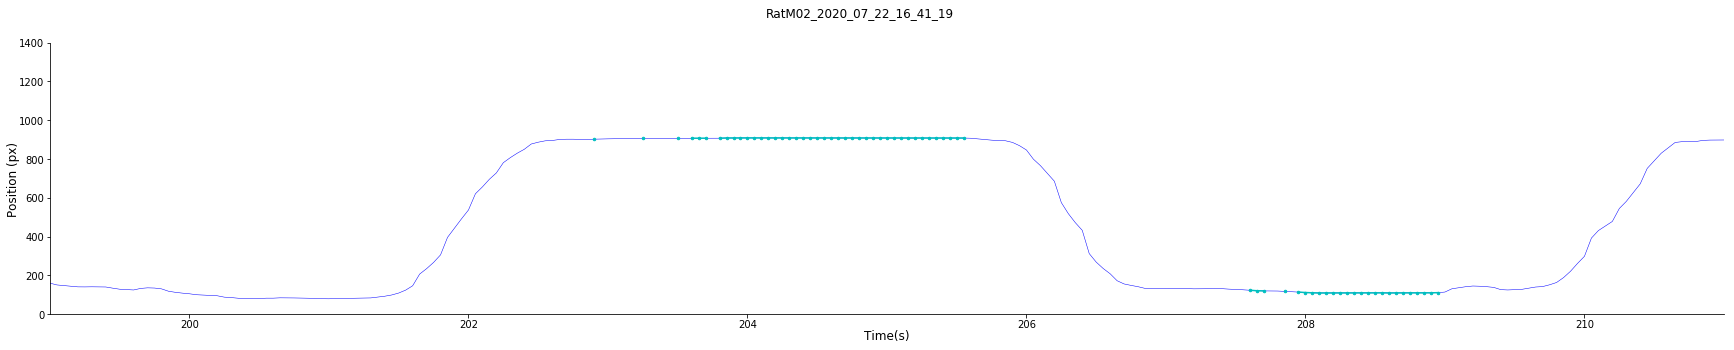

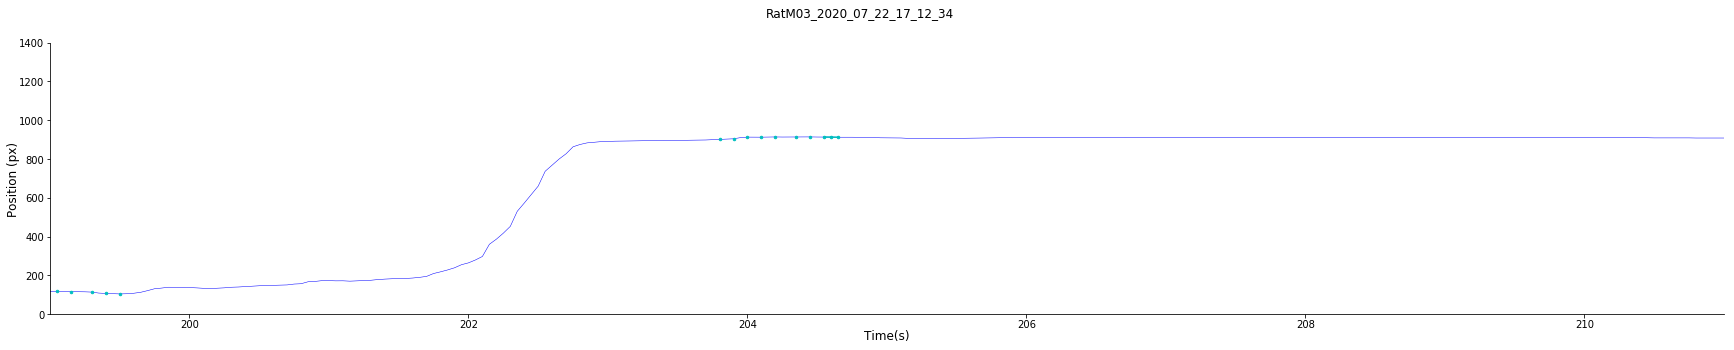

In [14]:
plt.figure(figsize = [20, 5])
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList: 
        plt.figure(figsize = [30, 5])
        plt.suptitle(session)
        print(animal, session)
        plot_BASEtrajectory(rawTime[animal, session],rawPositionX[animal, session], rawLickLeft1X[animal, session], rawLickRight1X[animal, session], [200, 210,1],[0,1400,1],  color = ["b", "c"], marker = ["", "o", 2.5], linewidth = [0.5], xyLabels=["Position (px)", "Time(s)"])

# Define functions
## extract runs and stays
## compute stats function
## plot functions

# Extract Runs and Stays

In [15]:
def extract_runsRightLeftFiltered(dataPos, dataTime, dataLickR, dataLickL, animal, session, boundary, limspeed=None, hasLick=True):

    rawdata_run = {}
    rawdata_stay = {}

    good_speedRunToRight = []
    good_speedRunToLeft = []
    good_XtrackRunToRight = []
    good_XtrackRunToLeft = []
    good_timeRunToRight = []
    good_timeRunToLeft = []

    bad_speedRunToRight = []
    bad_speedRunToLeft = []
    bad_XtrackRunToRight = []
    bad_XtrackRunToLeft = []
    bad_timeRunToRight = []
    bad_timeRunToLeft = []

    all_speedRunToRight = [] 
    all_speedRunToLeft = []
    all_timeRunToRight = [] 
    all_timeRunToLeft = []



    good_timeStayInRight = []
    good_timeStayInLeft = []
    good_XtrackStayInRight = []
    good_XtrackStayInLeft = []
    good_TtrackStayInRight = []
    good_TtrackStayInLeft = []

    bad_timeStayInRight = []
    bad_timeStayInLeft = []
    bad_XtrackStayInRight = []
    bad_XtrackStayInLeft = []
    bad_TtrackStayInRight = []
    bad_TtrackStayInLeft = []

    all_timeStayInRight = []
    all_timeStayInLeft = []
    all_TtrackStayInRight = []
    all_TtrackStayInLeft = []

    lick_arrivalRight = []
    lick_drinkingRight = []
    lick_waitRight = []
    lick_arrivalLeft = []
    lick_drinkingLeft = []
    lick_waitLeft = []

    #crop the complete track at the set boundaries -> keep only the runs and set the rest to 0
    rawdata_run[animal, session] = [[e[0]/13.5, e[1]] if e[0] <= boundary[0] and e[0]>= boundary[1] else 0 for e in [[i , j] for i, j in zip(dataPos[animal, session],dataTime[animal, session])]]
    # use the split a list function to create a new sublist when there is a 0, which we just set up before
    for run in split_a_list_at_zeros(rawdata_run[animal, session]):
        #calculate distance run as the distance between first and last value
        distanceRun = abs(run[0][0]-run[-1][0])
        #calculate time as sum of time interval between frames
        totaltimeRun = []
        xTrackRun = []
        for item in run:
            xTrackRun.append(item[0])
            totaltimeRun.append(item[1])
        speedRun = distanceRun/np.sum(np.diff(totaltimeRun)) #pb number of items ?
        #check if the subsplit starts on the left or the right -> determine if the animal is running left or right
        if run[0][0] < (((boundary[0]+boundary[1])/2) /13.5):
            #check if the subsplit is ending on the other side -> determine if this is a run 
            if run[-1][0] > (((boundary[0]+boundary[1])/2) /13.5):
                #check if there is a limspeed : if no compute all the runs -> used to compute limspeed
                #second pass : there is a computed limspeed, use it to sort good and bad runs
                if limspeed[0] is not None:
                    #check if this is a good or bad run and assign im to the good or bad array accordingly
                    if speedRun > limspeed[0][0] and speedRun < limspeed[0][1]:
                        #good run array
                        good_speedRunToRight.append(speedRun)
                        good_XtrackRunToRight.append(xTrackRun)
                        good_timeRunToRight.append(totaltimeRun)   
                    else:
                        #bad run array
                        bad_speedRunToRight.append(speedRun)
                        bad_XtrackRunToRight.append(xTrackRun)
                        bad_timeRunToRight.append(totaltimeRun)
                else:
                    #all runs array first pass
                    all_speedRunToRight.append(speedRun)
                    all_timeRunToRight.append(totaltimeRun)

        #same thing for the runs that go to the other side
        elif run[0][0]>(((boundary[0]+boundary[1])/2)/13.5):
            if run[-1][0]<(((boundary[0]+boundary[1])/2)/13.5):
                if limspeed[1] is not None:
                    if speedRun > limspeed[1][0] and speedRun < limspeed[1][1]:
                        good_speedRunToLeft.append(speedRun)   
                        good_XtrackRunToLeft.append(xTrackRun)
                        good_timeRunToLeft.append(totaltimeRun)
                    else:
                        bad_speedRunToLeft.append(speedRun)
                        bad_XtrackRunToLeft.append(xTrackRun)
                        bad_timeRunToLeft.append(totaltimeRun)
                else:
                    all_speedRunToLeft.append(speedRun)
                    all_timeRunToLeft.append(totaltimeRun)

    # inverse crop, at the boundaries keep the distal parts, same process as above
    #same principle as packing time and position together
    #put stay : 0=position, 1=time, 2=lickright, 3=lickleft
    rawdata_stay[animal, session]= [[e[0]/13.5, e[1], e[2], e[3]] if e[0] >= boundary[0] or e[0] <= boundary[1] else 0 for e in [[i, j, k, l] for i, j, k, l in zip(dataPos[animal, session], dataTime[animal, session], dataLickR[animal, session], dataLickL[animal, session])]]

    for stay in split_a_list_at_zeros(rawdata_stay[animal, session]):
        tInZone = []
        xTrackStay = []
        lickR = []
        lickL = []
        for item in stay:
            xTrackStay.append(item[0])
            tInZone.append(item[1])
            lickR.append(item[2])
            lickL.append(item[3])
        totaltimeStay = np.sum(np.diff(tInZone))
        #first identify if the subsplit created is on the left or right by comparing to the middle
        if stay[0][0] > (((boundary[0]+boundary[1]) / 2) / 13.5):
            if hasLick == True: #put hasLick as a param
                # if empty put in bad stay
                if all(v == 0 for v in lickR):
                    bad_timeStayInRight.append(totaltimeStay)
                    bad_XtrackStayInRight.append(xTrackStay)
                    bad_TtrackStayInRight.append(tInZone)
                    continue
                pre = []
                drink = []
                post = []
                for t, l in zip(tInZone[0:np.min(np.nonzero(lickR))], lickR[0:np.min(np.nonzero(lickR))]):
                    pre.append(t)
                for t, l in zip(tInZone[np.min(np.nonzero(lickR)):np.max(np.nonzero(lickR))], lickR[np.min(np.nonzero(lickR)):np.max(np.nonzero(lickR))]):
                    drink.append(t)
                for t, l in zip(tInZone[np.max(np.nonzero(lickR)):-1], lickR[np.max(np.nonzero(lickR)):-1]):
                    post.append(t)
                
                #drink <- dig in that later on to have more info on lick (lick rate, number of licks, etc.)

                lick_arrivalRight.append(np.sum(np.diff(pre)))
                lick_drinkingRight.append(np.sum(np.diff(drink)))
                lick_waitRight.append(np.sum(np.diff(post)))

            if limspeed[0] is not None:
                if totaltimeStay > limspeed[0][0] and totaltimeStay < limspeed[0][1]:
                    good_timeStayInRight.append(totaltimeStay)
                    good_XtrackStayInRight.append(xTrackStay)
                    good_TtrackStayInRight.append(tInZone)
                else:
                    bad_timeStayInRight.append(totaltimeStay)
                    bad_XtrackStayInRight.append(xTrackStay)
                    bad_TtrackStayInRight.append(tInZone)
            else:
                all_timeStayInRight.append(totaltimeStay)
                all_TtrackStayInRight.append(tInZone)
      
        elif stay[0][0] < (((boundary[0] + boundary[1]) / 2) / 13.5):
            if hasLick == True: #put hasLick as a param
                if all(v == 0 for v in lickL):
                    bad_timeStayInLeft.append(totaltimeStay)
                    bad_XtrackStayInLeft.append(xTrackStay)
                    bad_TtrackStayInLeft.append(tInZone)
                    continue
                preL = []
                drinkL = []
                postL = []
                for t, l in zip(tInZone[0:np.min(np.nonzero(lickL))], lickR[0:np.min(np.nonzero(lickL))]):
                    preL.append(t)
                for t, l in zip(tInZone[np.min(np.nonzero(lickL)):np.max(np.nonzero(lickL))], lickL[np.min(np.nonzero(lickL)):np.max(np.nonzero(lickL))]):
                    drinkL.append(t)
                for t, l in zip(tInZone[np.max(np.nonzero(lickL)):-1], lickL[np.max(np.nonzero(lickL)):-1]):
                    postL.append(t)

                lick_arrivalLeft.append(np.sum(np.diff(preL)))
                lick_drinkingLeft.append(np.sum(np.diff(drinkL)))
                lick_waitLeft.append(np.sum(np.diff(postL)))

            if limspeed[1] is not None:
                if totaltimeStay > limspeed[1][0] and totaltimeStay < limspeed[1][1]:
                    good_timeStayInLeft.append(totaltimeStay)   
                    good_XtrackStayInLeft.append(xTrackStay)
                    good_TtrackStayInLeft.append(tInZone)
                else:
                    bad_timeStayInLeft.append(totaltimeStay)
                    bad_XtrackStayInLeft.append(xTrackStay)
                    bad_TtrackStayInLeft.append(tInZone)
            else:
                all_timeStayInLeft.append(totaltimeStay)
                all_TtrackStayInRight.append(tInZone)

    return all_speedRunToRight, all_speedRunToLeft, all_timeRunToRight, all_timeRunToLeft, good_speedRunToRight, good_speedRunToLeft, good_XtrackRunToRight, good_XtrackRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, bad_XtrackRunToRight, bad_XtrackRunToLeft, good_timeRunToRight, good_timeRunToLeft, bad_timeRunToRight, bad_timeRunToLeft, all_timeStayInRight, all_timeStayInLeft, all_TtrackStayInRight, all_TtrackStayInLeft, good_timeStayInRight, good_timeStayInLeft, good_XtrackStayInRight, good_XtrackStayInLeft, bad_timeStayInRight, bad_timeStayInLeft, bad_XtrackStayInRight, bad_XtrackStayInLeft, good_TtrackStayInRight, good_TtrackStayInLeft, bad_TtrackStayInRight, bad_TtrackStayInLeft, lick_arrivalRight, lick_drinkingRight, lick_waitRight, lick_arrivalLeft, lick_drinkingLeft, lick_waitLeft

# Stats function

In [16]:
def statsrun(dataRight, dataLeft, animal):
    #define sitistical significance threshold
    sig_threshold = 0.05
    #compute average of speeds
    average_semToRight = [np.mean(dataRight), scipy.stats.sem(dataRight), np.median(dataRight)]
    average_semToLeft = [np.mean(dataLeft), scipy.stats.sem(dataLeft), np.median(dataLeft)]
    #check if the sample is from a normal distribution 
    #normaltest, if p<0.05, reject null hypothesis that sample comes from a normal distribution
    normalToRight = scipy.stats.normaltest(dataRight)
    normalToLeft = scipy.stats.normaltest(dataLeft)

    print(animal)
    #check if the two samples that we are comparing are from a normal distribution; if they both are perform a ttest, if at least one of them is not do a mannwhitney 
    if normalToLeft[1] > sig_threshold and normalToRight[1] > sig_threshold:
        #stat from ttest
        statValue = [scipy.stats.ttest_ind(dataRight, dataLeft)[1], "Ttest"]
    else: 
        #stat from mannwhitney
        statValue = [scipy.stats.mannwhitneyu(dataRight, dataLeft)[1], "MannWhitney"]

    #if the stat value (ttest or mannwhitney) is below statistical signifiance threshold show big arrow to the side they go the faster, print a *, else not
    if statValue[0] > sig_threshold:
        print("----------->", "\t", "<-----------")
    else:
        if average_semToRight[0] > average_semToLeft[0]:
            print("=>=>=>=>=>=>", "\t", "<-----------")
        else:
            print("----------->", "\t", "<=<=<=<=<=<=")

    #fnmatch.fnmatch(animal, 'RatF*')
    #print and format the results
    print("%.2f" % average_semToRight[0],"\u00B1", "%.2f" % average_semToRight[1], "\t" ,"%.2f" % average_semToLeft[0],"\u00B1", "%.2f" % average_semToLeft[1], "     median R - L ", "%.2f" % average_semToRight[2], "%.2f" % average_semToLeft[2])
    print(statValue[0], "" if statValue[0] > sig_threshold else "*", statValue[1])
    print()

# plotting functions

In [17]:
def plot_tracks(animal, session, good_PosdataRight, good_TimedataRight, bad_PosdataRight, bad_TimedataRight, index, xylim, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1 ): 

    for i, j in zip(good_PosdataRight, good_TimedataRight):
        plt.plot(np.subtract(j, j[0]), i, color='g' , linewidth=0.3, label="Good Item" if i == good_PosdataRight[0] and index ==0 else "")
    for k, l in zip(bad_PosdataRight, bad_TimedataRight):
        plt.plot(np.subtract(l, l[0]), k, color='r', linewidth=0.3,  label="Bad Item" if k == bad_PosdataRight[0] and index == 0 else "")
    ax.set_title(title[0], fontsize = title[1])
    ax.set_xlabel(xyLabels[0], fontsize = xyLabels[2])
    ax.set_ylabel(xyLabels[1], fontsize = xyLabels[2])
    ax.set_xlim([xylim[0], xylim[1]])
    ax.set_ylim([xylim[2], xylim[3]])
    ax.spines['top'].set_color("none")
    ax.spines['right'].set_color("none")
    if index == 0:
        ax.legend()
        
def cumul_plot(gooddataRight, gooddataLeft, baddataRight, baddataLeft, barplotaxes, maxminstepbin, scatterplotaxes, legend, xyLabels=["","","",""], title=[None], linewidth = 1):      
    ax1 = plt.gca()
    custom_legend = [Line2D([0], [0], color ='g', lw=legend[3]), Line2D([0], [0], color ='g', lw=legend[2])]
    plt.hist(gooddataRight, np.arange(maxminstepbin[0],maxminstepbin[1], maxminstepbin[2]), weights=np.ones_like(gooddataRight)/float(len(gooddataRight + baddataRight)), color ='g', histtype = 'step', cumulative = True, linewidth = legend[3])
    plt.hist(gooddataLeft, np.arange(maxminstepbin[0],maxminstepbin[1], maxminstepbin[2]), weights=np.ones_like(gooddataLeft)/float(len(gooddataLeft + baddataLeft)), color ='g', histtype = 'step', cumulative = True, linewidth = legend[2])
    ax1.set_title(title[0], fontsize = title[1], pad=50)
    ax1.set_xlabel(xyLabels[0], fontsize = xyLabels[2])
    ax1.set_ylabel(xyLabels[1], fontsize = xyLabels[2])
    ax1.set_xlim([barplotaxes[0], barplotaxes[1]])
    ax1.set_ylim([barplotaxes[2], barplotaxes[3]])
    ax1.spines['bottom'].set_linewidth(linewidth[0])
    ax1.spines['left'].set_linewidth(linewidth[0])
    ax1.spines['top'].set_color("none")
    ax1.spines['right'].set_color("none")
    ax1.tick_params(width=2, labelsize = xyLabels[2]) 
    plt.tight_layout(pad=0.5)
    ax1.legend(custom_legend, [legend[0], legend[1]], bbox_to_anchor = (0., 1.02, 1., .102), loc='lower left', mode="expand", borderaxespad=0., frameon = False)
    return plt

def distribution_plot(gooddataRight, gooddataLeft, baddataRight, baddataLeft, barplotaxes, maxminstepbin, scatterplotaxes, legend, xyLabels=["","","",""], title=[None], linewidth = 1):
    ax2 = plt.gca()
    plt.scatter(np.random.normal(1, 0.05, len(gooddataRight)), gooddataRight, s=20, color = 'g', marker = "$\u25ba$", label=legend[0])
    plt.scatter(np.random.normal(2, 0.05, len(gooddataLeft)), gooddataLeft, s=20, color = 'g', marker = "$\u25c4$", label=legend[1])
    plt.scatter(np.random.normal(1, 0.05, len(baddataRight)), baddataRight, s=20, color = 'r', alpha = 0.2, marker = "$\u25ba$", label=legend[2])
    plt.scatter(np.random.normal(2, 0.05, len(baddataLeft)), baddataLeft, s=20, color = 'r', alpha = 0.2, marker = "$\u25c4$", label=legend[3])
    plt.scatter(1.2, np.mean(gooddataRight), s=25, color = 'g')
    plt.scatter(2.2, np.mean(gooddataLeft), s=25, color = 'g')
    plt.boxplot(gooddataRight, positions = [1.35])
    plt.boxplot(gooddataLeft, positions = [2.35])
    ax2.set_xlabel(xyLabels[1], fontsize = xyLabels[4])
    ax2.set_ylabel(xyLabels[0], fontsize = xyLabels[4])
    ax2.set_title(title[0], fontsize = title[1], pad=50)
    ax2.set_xlim([scatterplotaxes[0], scatterplotaxes[1]])
    ax2.set_ylim([scatterplotaxes[2], scatterplotaxes[3]])
    ax2.set_xticks([1,2])
    ax2.set_xticklabels([xyLabels[2],xyLabels[3]], fontsize = xyLabels[5])
    ax2.spines['bottom'].set_linewidth(linewidth[0])
    ax2.spines['left'].set_linewidth(linewidth[0])
    ax2.spines['top'].set_color("none")
    ax2.spines['right'].set_color("none")
    ax2.tick_params(width=2, labelsize = xyLabels[5])
    handles, labels = ax.get_legend_handles_labels()
    handles = [handles[0], handles[2], handles[1], handles[3]]
    labels = [legend[0], legend[2], legend[1], legend[3]]
    ax.legend(handles, labels, bbox_to_anchor = (0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0., frameon = False)
    return plt

def blank_plot():
    ax3 = plt.gca()
    ax3.axis('off') 

def plot_recap(animal, session, gooddataRight, gooddataLeft, baddataRight, baddataLeft, axes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1): 
    for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            ax3 = plt.gca()
            plt.scatter(1, np.mean(gooddataRight[animal, session]), s=500, color =rat_markers[animal][0], marker=rat_markers[animal][1])
            plt.scatter(2, np.mean(gooddataLeft[animal, session]), s=500, color =rat_markers[animal][0], marker=rat_markers[animal][1])
            plt.plot((1, 2), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), color = rat_markers[animal][0], label=animal)
            plt.scatter(1, np.mean(list(itertools.chain.from_iterable(list(gooddataRight.values())))), s=40, color ='k')
            plt.scatter(2, np.mean(list(itertools.chain.from_iterable(list(gooddataLeft.values())))), s=40, color ='k')
            plt.plot((1, 2), (np.mean(list(itertools.chain.from_iterable(list(gooddataRight.values())))), 
                             np.mean(list(itertools.chain.from_iterable(list(gooddataLeft.values()))))), color='k')
            if baddataRight != [] and baddataLeft != []:
                plt.scatter(1, np.mean(gooddataRight[animal, session] + baddataRight[animal, session]), s=500, color =rat_markers[animal][0], marker=rat_markers[animal][1], alpha = 0.05)
                plt.scatter(2, np.mean(gooddataLeft[animal, session] + baddataLeft[animal, session]), s=500, color =rat_markers[animal][0], marker=rat_markers[animal][1], alpha = 0.05)
                plt.plot((1, 2), (np.mean(gooddataRight[animal, session] + baddataRight[animal, session]), np.mean(gooddataLeft[animal, session] + baddataLeft[animal, session])), color = rat_markers[animal][0], alpha = 0.05)
                plt.scatter(1, np.mean(list(itertools.chain.from_iterable(list(gooddataRight.values()))) + list(itertools.chain.from_iterable(list(baddataRight.values())))), s=40, color ='k', alpha = 0.01)
                plt.scatter(2, np.mean(list(itertools.chain.from_iterable(list(gooddataLeft.values()))) + list(itertools.chain.from_iterable(list(baddataLeft.values())))), s=40, color ='k', alpha = 0.01)
                plt.plot((1, 2), (np.mean(list(itertools.chain.from_iterable(list(gooddataRight.values()))) + list(itertools.chain.from_iterable(list(baddataRight.values())))), np.mean(list(itertools.chain.from_iterable(list(gooddataLeft.values()))) + list(itertools.chain.from_iterable(list(baddataLeft.values()))))), color='k', alpha = 0.01)
            ax3.set_xlabel(xyLabels[2], fontsize = xyLabels[4])
            ax3.set_ylabel(xyLabels[3], fontsize = xyLabels[4])
            ax3.set_title(title[0], fontsize = title[1])
            ax3.set_xlim([axes[0], axes[1]])
            ax3.set_ylim([axes[2], axes[3]])
            ax3.set_xticks([1,2])
            ax3.set_xticklabels([xyLabels[0],xyLabels[1]], fontsize = xyLabels[4])
            ax3.spines['bottom'].set_linewidth(linewidth[0])
            ax3.spines['left'].set_linewidth(linewidth[0])
            ax3.spines['top'].set_color("none")
            ax3.spines['right'].set_color("none")
            ax3.tick_params(width=2, labelsize = xyLabels[5])
            plt.legend()

# Extract Runs and Stays

In [18]:
#careful,same function name used later, can lead to
all_speedRunToRight = {} 
all_speedRunToLeft = {}
all_timeRunToRight = {}# check used ?
all_timeRunToLeft = {}#
limspeedRunToRight = {}
limspeedRunToLeft = {}

good_speedRunToRight = {}
good_speedRunToLeft = {}
good_XtrackRunToRight = {}
good_XtrackRunToLeft = {}
good_timeRunToRight = {}
good_timeRunToLeft = {}

bad_speedRunToRight = {}
bad_speedRunToLeft = {}
bad_XtrackRunToRight = {}
bad_XtrackRunToLeft = {}
bad_timeRunToRight = {}
bad_timeRunToLeft = {}



all_timeStayInRight = {}
all_timeStayInLeft = {}
all_TtrackStayInRight = {} #
all_TtrackStayInLeft = {}#check if used
#all_speedToRight = {}
#all_speedToLeft = {}
limstayRight = {}
limstayLeft = {}

good_timeStayInRight = {}
good_timeStayInLeft = {}
good_XtrackStayInRight = {}
good_XtrackStayInLeft = {}
good_TtrackStayInRight = {}
good_TtrackStayInLeft = {}

bad_timeStayInRight = {}
bad_timeStayInLeft = {}
bad_XtrackStayInRight = {}
bad_XtrackStayInLeft = {}
bad_TtrackStayInRight = {}
bad_TtrackStayInLeft = {}


lick_arrivalRight = {}
lick_drinkingRight = {}
lick_waitRight = {}
lick_arrivalLeft = {}
lick_drinkingLeft = {}
lick_waitLeft = {}


for animal in animalList: 
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            #extract all the runs to compute limspeed
            all_speedRunToRight[animal, session], all_speedRunToLeft[animal, session], all_timeRunToRight[animal, session], all_timeRunToLeft[animal, session] = extract_runsRightLeftFiltered(rawPositionX, rawTime, rawLickRight1X, rawLickLeft1X, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [None, None], hasLick = False)[0:4]
            all_timeStayInRight[animal, session], all_timeStayInLeft[animal, session], all_TtrackStayInRight[animal, session], all_TtrackStayInLeft[animal, session] = extract_runsRightLeftFiltered(rawPositionX, rawTime, rawLickRight1X, rawLickLeft1X, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [None, None], hasLick = False)[16:20]

            #compute limspeed (speed below which we consider that the rats are not running) as the speeds below 2 st dev of the mean speed. can be changed
            #test intervalle de confiance
            limspeedRunToRight[animal, session] = [np.mean(all_speedRunToRight[animal, session]) - 2*statistics.stdev(all_speedRunToRight[animal, session]), np.mean(all_speedRunToRight[animal, session]) + 2*statistics.stdev(all_speedRunToRight[animal, session])]
            limspeedRunToLeft[animal, session]  = [np.mean(all_speedRunToLeft[animal, session]) - 2*statistics.stdev(all_speedRunToLeft[animal, session]), np.mean(all_speedRunToLeft[animal, session]) + 2*statistics.stdev(all_speedRunToLeft[animal, session])]
            limstayRight[animal, session]       = [np.mean(all_timeStayInRight[animal, session]) - 2*statistics.stdev(all_timeStayInRight[animal, session]), np.mean(all_timeStayInRight[animal, session]) + 2*statistics.stdev(all_timeStayInRight[animal, session])]
            limstayLeft[animal, session]        = [np.mean(all_timeStayInLeft[animal, session]) - 2*statistics.stdev(all_timeStayInLeft[animal, session]), np.mean(all_timeStayInLeft[animal, session]) + 2*statistics.stdev(all_timeStayInLeft[animal, session])]

            #extract the run data (good/bad, to left/ to right) 
            good_speedRunToRight[animal, session], good_speedRunToLeft[animal, session], good_XtrackRunToRight[animal, session], good_XtrackRunToLeft[animal, session], bad_speedRunToRight[animal, session], bad_speedRunToLeft[animal, session], bad_XtrackRunToRight[animal, session], bad_XtrackRunToLeft[animal, session], good_timeRunToRight[animal, session], good_timeRunToLeft[animal, session], bad_timeRunToRight[animal, session], bad_timeRunToLeft [animal, session] = extract_runsRightLeftFiltered(rawPositionX, rawTime, rawLickRight1X, rawLickLeft1X, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limspeedRunToRight[animal, session], limspeedRunToLeft[animal, session]], hasLick = params[animal, session]["hasLick"])[4:16]

            good_timeStayInRight[animal, session], good_timeStayInLeft[animal, session], good_XtrackStayInRight[animal, session], good_XtrackStayInLeft[animal, session], bad_timeStayInRight[animal, session], bad_timeStayInLeft[animal, session], bad_XtrackStayInRight[animal, session], bad_XtrackStayInLeft[animal, session], good_TtrackStayInRight[animal, session], good_TtrackStayInLeft[animal, session], bad_TtrackStayInRight[animal, session], bad_TtrackStayInLeft [animal, session] = extract_runsRightLeftFiltered(rawPositionX, rawTime, rawLickRight1X, rawLickLeft1X, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limstayRight[animal, session], limstayLeft[animal, session]], hasLick = params[animal, session]["hasLick"])[20:32]
            if params[animal, session]["hasLick"] == True:
                lick_arrivalRight[animal, session], lick_drinkingRight[animal, session], lick_waitRight[animal, session], lick_arrivalLeft[animal, session], lick_drinkingLeft[animal, session], lick_waitLeft[animal, session] = extract_runsRightLeftFiltered(rawPositionX, rawTime, rawLickRight1X, rawLickLeft1X, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [None, None])[32:38]
            if params[animal, session]["hasLick"] == False:
                lick_arrivalRight[animal, session], lick_drinkingRight[animal, session], lick_waitRight[animal, session], lick_arrivalLeft[animal, session], lick_drinkingLeft[animal, session], lick_waitLeft[animal, session] = [], [], [], [], [], []

            print(animal, "done")

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in double_scalars


RatF00 done
RatF01 done
RatF02 done
RatF03 done
RatM00 done
RatM01 done
RatM02 done
RatM03 done


In [19]:
testR = {}
testL = {}
for animal in animalList: 
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            for run in good_timeRunToRight[animal, session]:
                testR[animal, session] = []
                #print(sum(np.diff(run)))
                testR[animal, session].append(sum(np.diff(run)))
            for run in good_timeRunToLeft[animal, session]:
                testL[animal, session] = []
                #print(sum(np.diff(run)))
                testL[animal, session].append(sum(np.diff(run)))
            print(session, np.mean(testR[animal, session]))
            print(session, np.mean(testL[animal, session]))
            print()

RatF00_2020_07_22_13_17_25 0.75
RatF00_2020_07_22_13_17_25 0.849999999999909

RatF01_2020_07_22_13_49_33 4.349999999999909
RatF01_2020_07_22_13_49_33 2.300000000000182

RatF02_2020_07_22_14_36_11 0.900000000000091
RatF02_2020_07_22_14_36_11 0.7000000000000455

RatF03_2020_07_22_15_07_14 0.75
RatF03_2020_07_22_15_07_14 0.6999999999998181

RatM00_2020_07_22_15_38_49 0.7999999999999545
RatM00_2020_07_22_15_38_49 0.75

RatM01_2020_07_22_16_09_59 0.8000000000001819
RatM01_2020_07_22_16_09_59 0.8999999999998636

RatM02_2020_07_22_16_41_19 1.1000000000001364
RatM02_2020_07_22_16_41_19 1.699999999999818

RatM03_2020_07_22_17_12_34 1.099999999999909
RatM03_2020_07_22_17_12_34 0.900000000000091



In [20]:
both = {}
for animal in animalList: 
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            both[animal, session] = []
            testR[animal, session] = np.mean(testR[animal, session])
            testL[animal, session] = np.mean(testL[animal, session])
            both[animal, session] = (testR[animal, session] + testL[animal, session])/2

# COMPUTE STATISTICS

In [21]:
print("**************RUNS***********")
print("*********NOT_FILTERED********")
#idea : do stats as statsrun(rightdata, leftdata, "", [rat1, rat2, rat3, Rat4], [etc]for groups or [Rat1], [rat2], [etc] for individuals)
#pool all data
all_speedRunToRightPooled = list(itertools.chain.from_iterable(list(all_speedRunToRight.values())))
all_speedRunToLeftPooled = list(itertools.chain.from_iterable(list(all_speedRunToLeft.values())))
good_speedRunToRightPooled = list(itertools.chain.from_iterable(list(good_speedRunToRight.values())))
good_speedRunToLeftPooled = list(itertools.chain.from_iterable(list(good_speedRunToLeft.values())))
bad_speedRunToRightPooled = list(itertools.chain.from_iterable(list(bad_speedRunToRight.values())))
bad_speedRunToLeftPooled = list(itertools.chain.from_iterable(list(bad_speedRunToLeft.values())))

for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:   
            #compute stats for individual animals
            statsrun(all_speedRunToRight[animal, session], all_speedRunToLeft[animal, session], animal)
print()
print("************POOLED***********")
#compute stats for the group
statsrun(all_speedRunToRightPooled, all_speedRunToLeftPooled, "")
print()
print("*****************************")
print("***********FILTERED**********")
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:   
            statsrun(good_speedRunToRight[animal, session], good_speedRunToLeft[animal, session], animal)
print()
print("************POOLED***********")
statsrun(good_speedRunToRightPooled, good_speedRunToLeftPooled, "")

**************RUNS***********
*********NOT_FILTERED********
RatF00
=>=>=>=>=>=> 	 <-----------
58.86 ± 1.19 	 52.68 ± 1.45      median R - L  62.98 58.87
0.00046410315764749304 * MannWhitney

RatF01
-----------> 	 <-----------
24.68 ± 1.54 	 24.20 ± 1.73      median R - L  23.98 22.69
0.8384356433895395  Ttest

RatF02
-----------> 	 <=<=<=<=<=<=
46.12 ± 1.11 	 50.70 ± 1.12      median R - L  50.63 54.98
4.303776969709744e-05 * MannWhitney

RatF03
-----------> 	 <=<=<=<=<=<=
67.12 ± 0.92 	 71.11 ± 0.70      median R - L  71.82 73.38
0.0004833438390641587 * MannWhitney

RatM00
-----------> 	 <-----------
53.55 ± 0.98 	 54.10 ± 0.99      median R - L  57.53 57.86
0.27929641462948485  MannWhitney

RatM01
-----------> 	 <-----------
59.13 ± 0.94 	 60.21 ± 0.81      median R - L  63.13 62.32
0.3772674294014029  MannWhitney

RatM02
-----------> 	 <=<=<=<=<=<=
49.50 ± 1.10 	 52.50 ± 0.98      median R - L  49.70 53.74
0.013090478036502234 * MannWhitney

RatM03
-----------> 	 <=<=<=<=<=<=
46.35

In [22]:
print("*************STAYS***********")
print("*********NOT_FILTERED********")
#pool all data
all_timeStayInRightPooled = list(itertools.chain.from_iterable(list(all_timeStayInRight.values())))
all_timeStayInLeftPooled = list(itertools.chain.from_iterable(list(all_timeStayInLeft.values())))
good_timeStayInRightPooled = list(itertools.chain.from_iterable(list(good_timeStayInRight.values())))
good_timeStayInLeftPooled = list(itertools.chain.from_iterable(list(good_timeStayInLeft.values())))
bad_timeStayInRightPooled = list(itertools.chain.from_iterable(list(bad_timeStayInRight.values())))
bad_timeStayInLeftPooled = list(itertools.chain.from_iterable(list(bad_timeStayInLeft.values())))
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:   
            #compute stats for individual animals
            statsrun(all_timeStayInRight[animal, session], all_timeStayInLeft[animal, session], animal)
print()
print("************POOLED***********")
#compute stats for the group
statsrun(all_timeStayInRightPooled, all_timeStayInLeftPooled, "")
print()
print("*****************************")
print("***********FILTERED**********")
#idea : do stats as statsrun(rightdata, leftdata, "", [rat1, rat2, rat3, Rat4], [etc]for groups or [Rat1], [rat2], [etc] for individuals)
#pool all data

for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:   
            #compute stats for individual animals
            statsrun(good_timeStayInRight[animal, session], good_timeStayInLeft[animal, session], animal)
print()
print("************POOLED***********")
#compute stats for the group
statsrun(good_timeStayInRightPooled, good_timeStayInLeftPooled, "")

*************STAYS***********
*********NOT_FILTERED********
RatF00
=>=>=>=>=>=> 	 <-----------
2.92 ± 0.25 	 2.77 ± 0.31      median R - L  1.90 1.55
7.501564625617748e-05 * MannWhitney

RatF01
-----------> 	 <-----------
8.56 ± 1.28 	 8.91 ± 1.44      median R - L  4.80 5.05
0.29424251124966905  MannWhitney

RatF02
-----------> 	 <-----------
3.52 ± 0.23 	 3.13 ± 0.19      median R - L  2.35 2.35
0.45837735263734436  MannWhitney

RatF03
-----------> 	 <=<=<=<=<=<=
2.43 ± 0.10 	 2.49 ± 0.15      median R - L  2.00 1.90
0.01768785608660683 * MannWhitney

RatM00
=>=>=>=>=>=> 	 <-----------
3.95 ± 0.35 	 3.66 ± 0.27      median R - L  2.70 2.60
0.028561408471565287 * MannWhitney

RatM01
=>=>=>=>=>=> 	 <-----------
2.71 ± 0.14 	 2.51 ± 0.13      median R - L  2.15 2.05
0.002407322345951089 * MannWhitney

RatM02
=>=>=>=>=>=> 	 <-----------
3.40 ± 0.24 	 3.21 ± 0.37      median R - L  2.45 2.25
4.832816161661199e-05 * MannWhitney

RatM03
=>=>=>=>=>=> 	 <-----------
3.26 ± 0.23 	 3.07 ± 0.23 

# VISUALISE TRACKS

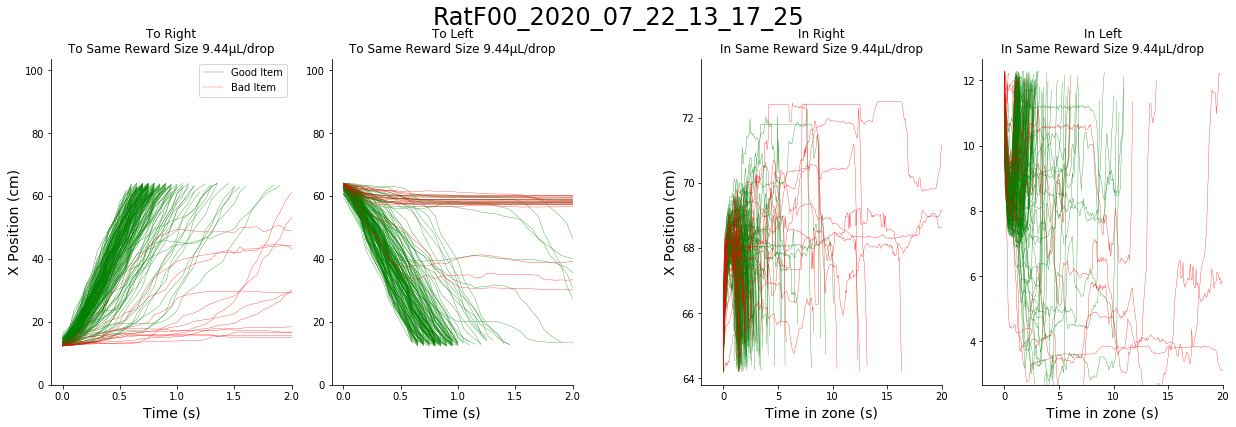

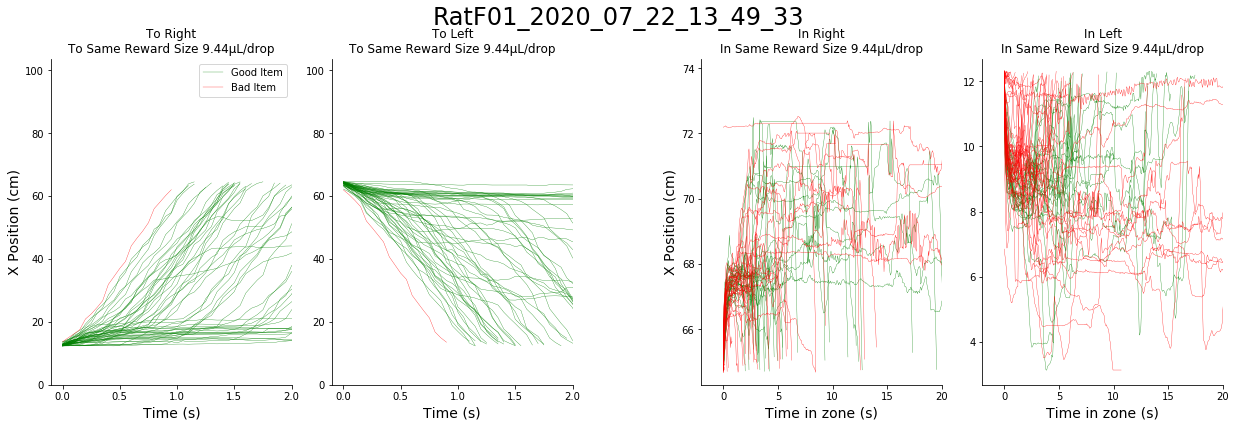

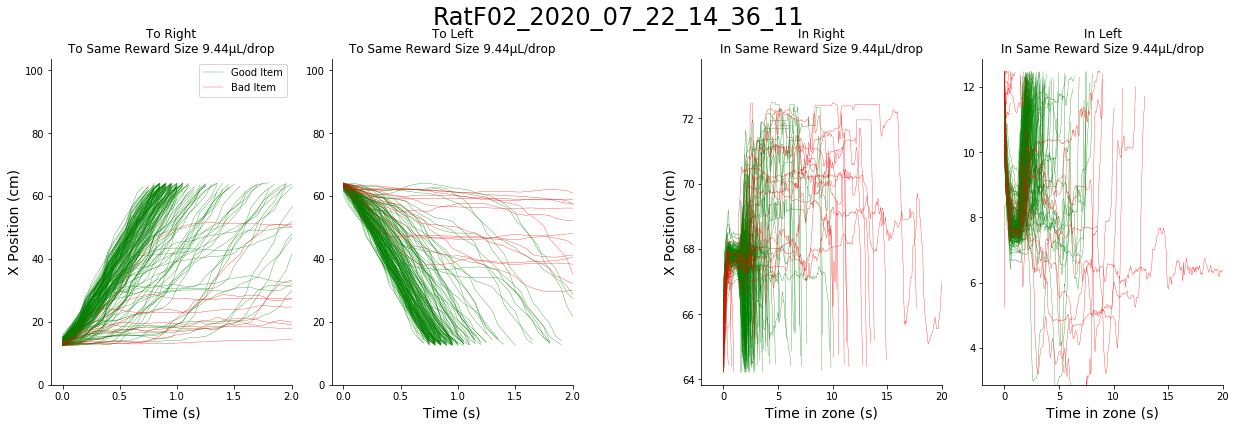

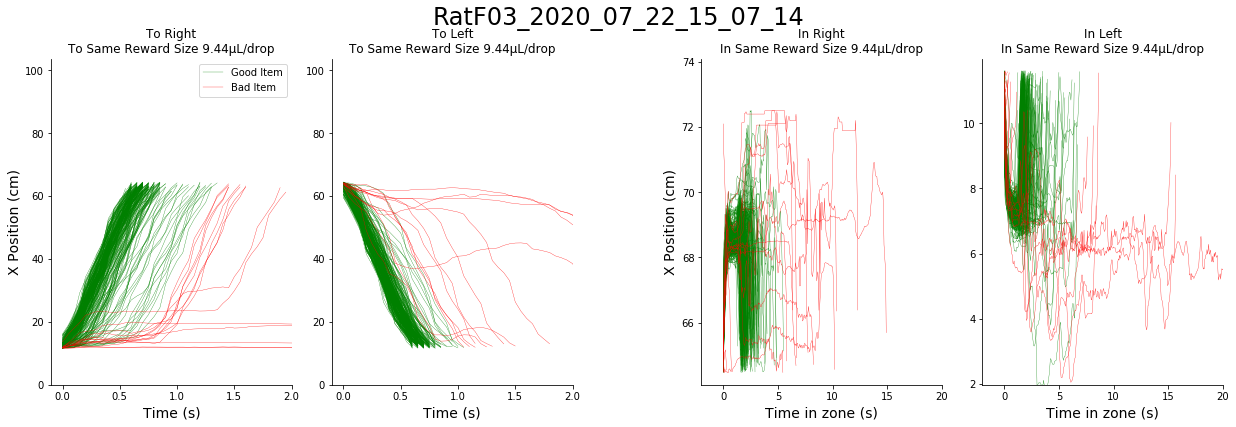

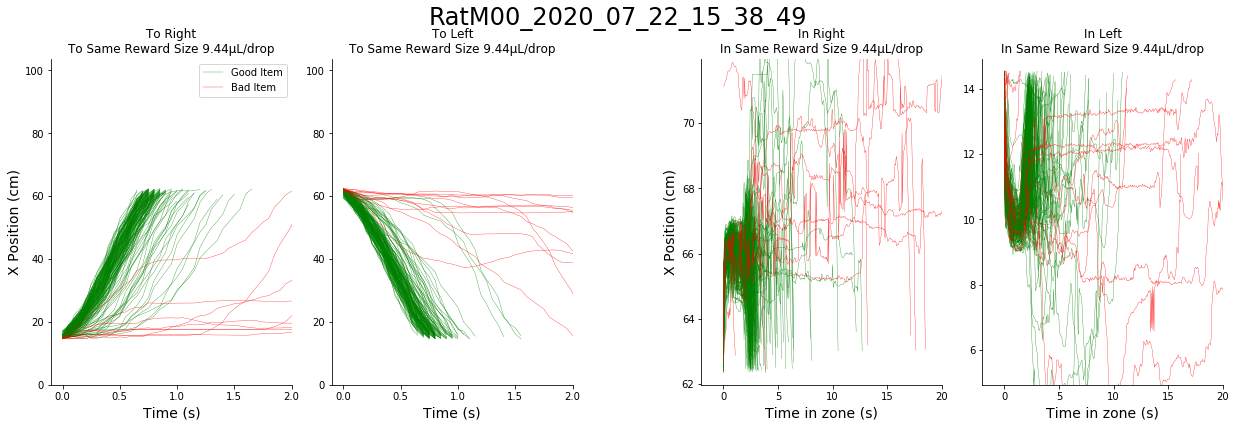

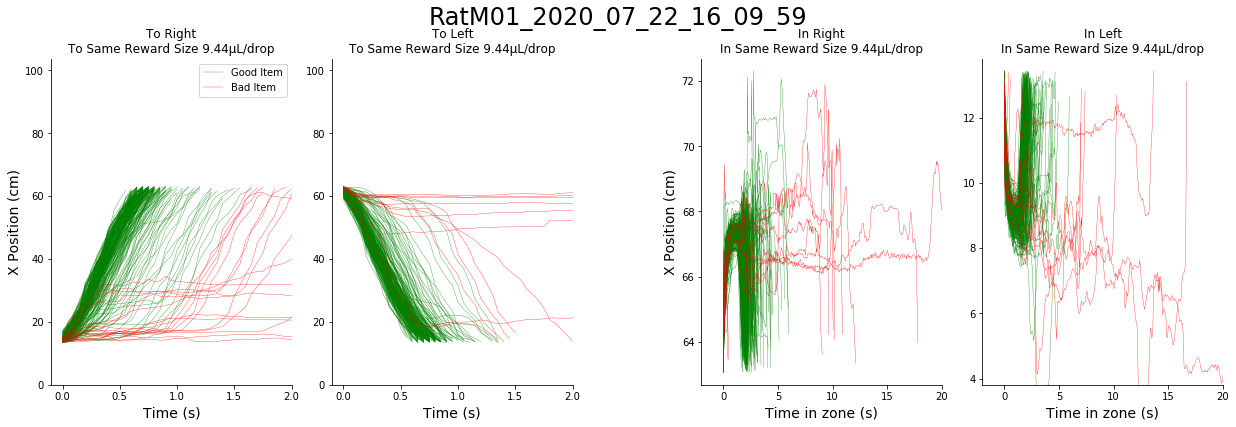

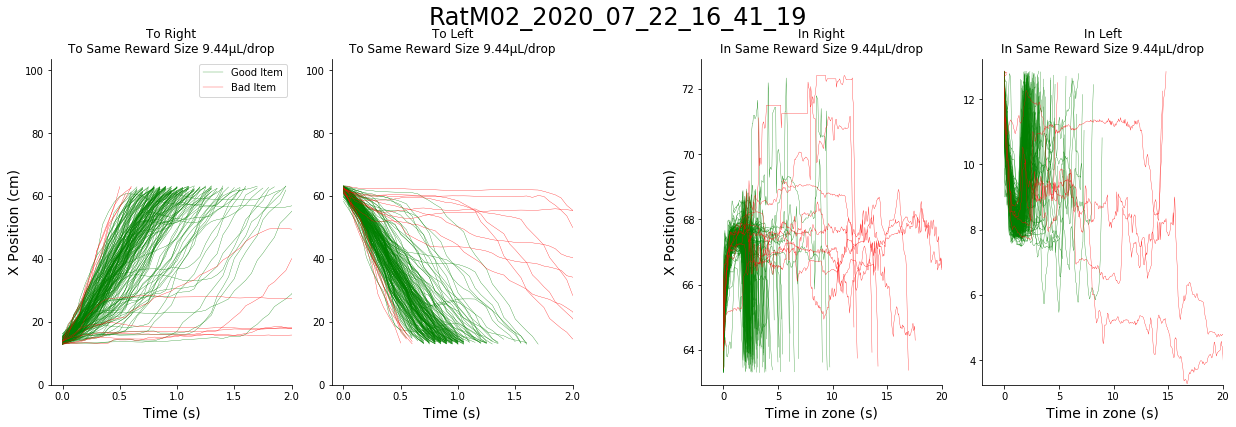

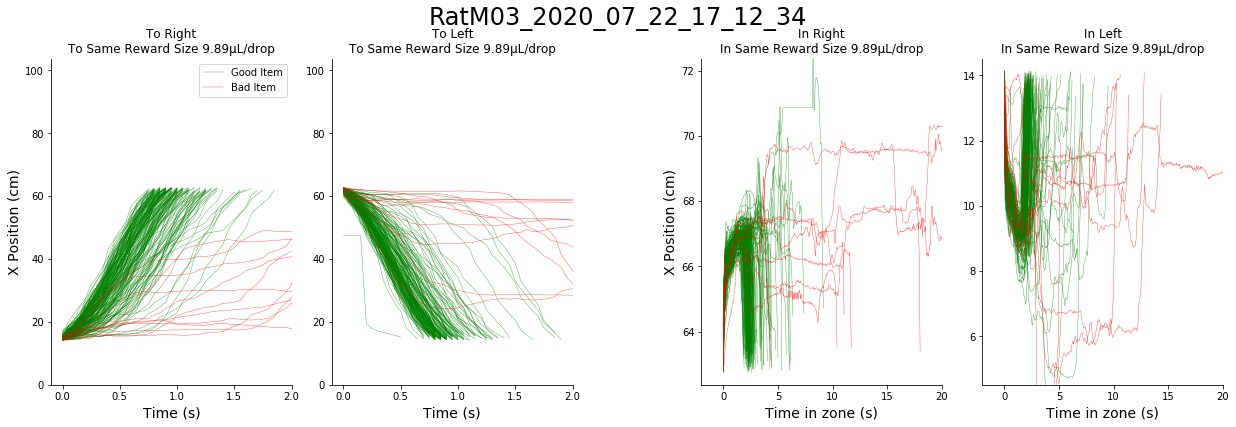

In [23]:
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            fig = plt.figure(constrained_layout = False, figsize=(21, 6))
            plt.suptitle(session, y= 1, fontsize = 24)
            widths, heights = [5, 5, 1, 5, 5], [6]
            rows, cols = 1, 5
            spec = fig.add_gridspec(ncols=cols, nrows=rows, width_ratios=widths, height_ratios=heights)
            index=0
            sub = spec[0,2].subgridspec(2,1)

            for row in range(rows):
                for col in range(cols):
                    ax=fig.add_subplot(spec[row, col])              
                    if index == 0:
                        plot_tracks(animal, session, good_XtrackRunToRight[animal, session], good_timeRunToRight[animal, session], bad_XtrackRunToRight[animal, session], bad_timeRunToRight[animal, session], index, xylim = [-0.1, 2, 0/13.5, 1400/13.5], xyLabels=["Time (s)","X Position (cm)", 14], title=["To Right" + "\n" + "To " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", 12], linewidth = [1.5])
                        index+=1
                    elif index ==1:
                        plot_tracks(animal, session, good_XtrackRunToLeft[animal, session], good_timeRunToLeft[animal, session], bad_XtrackRunToLeft[animal, session], bad_timeRunToLeft[animal, session], index, xylim = [-0.1, 2, 0/13.5, 1400/13.5], xyLabels=["Time (s)","", 14], title=["To Left" + "\n" + "To " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", 12], linewidth = [1.5])
                        index+=1
                    elif index ==2:
                        blank_plot()
                        index+=1
                    elif index ==3:
                        plot_tracks(animal, session, good_XtrackStayInRight[animal, session], good_TtrackStayInRight[animal, session], bad_XtrackStayInRight[animal, session], bad_TtrackStayInRight[animal, session], index, xylim = [-2, 20, (params[animal, session]["boundaries"][0] - 5)/13.5, (params[animal, session]["boundaries"][0] + 130)/13.5], xyLabels=["Time in zone (s)","X Position (cm)", 14, 12], title=["In Right" + "\n" + "In " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", 12], linewidth = [1.5])
                        index+=1
                    elif index ==4:
                        plot_tracks(animal, session, good_XtrackStayInLeft[animal, session], good_TtrackStayInLeft[animal, session], bad_XtrackStayInLeft[animal, session], bad_TtrackStayInLeft[animal, session], index, xylim = [-2, 20, (params[animal, session]["boundaries"][1] - 130)/13.5, (params[animal, session]["boundaries"][1] + 5)/13.5], xyLabels=["Time in zone (s)","", 14, 12], title=["In Left" + "\n" + "In " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", 12], linewidth = [1.5])
                        index+=1

# PLOT DISTRIBUTION 

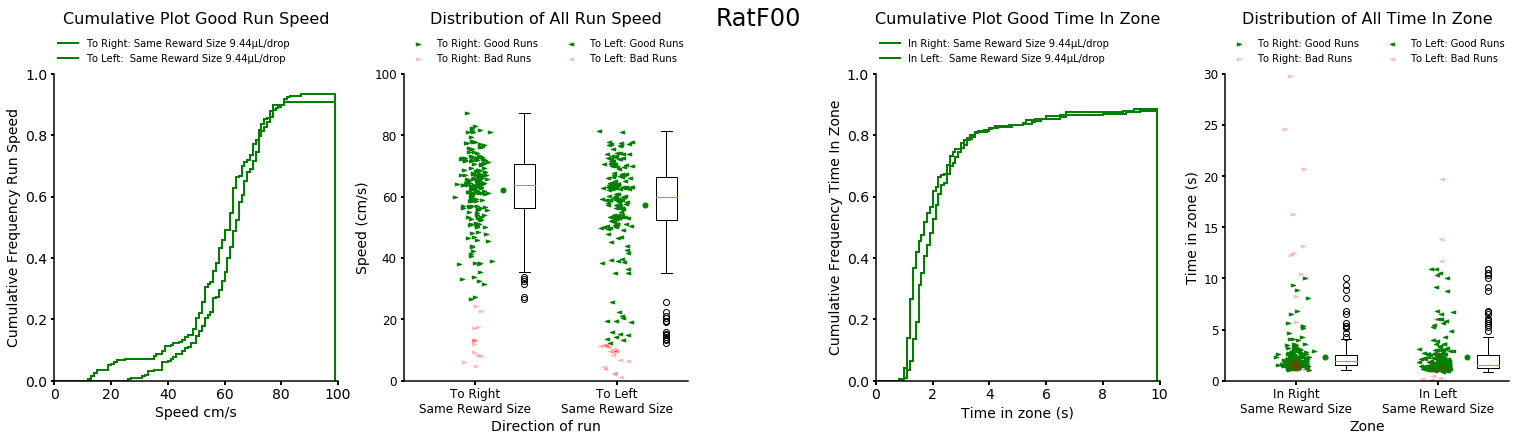

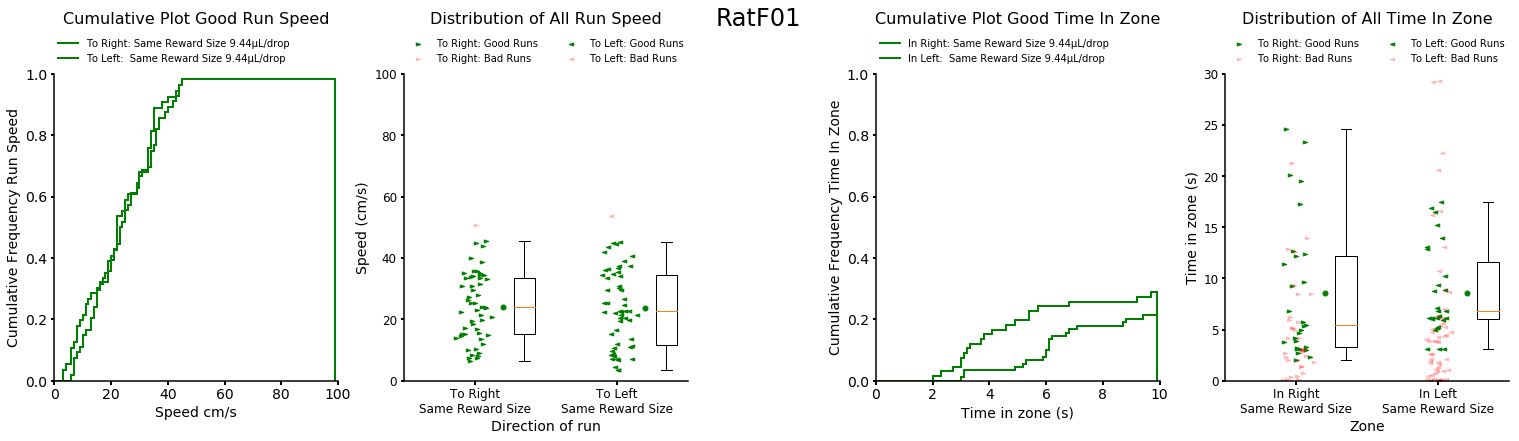

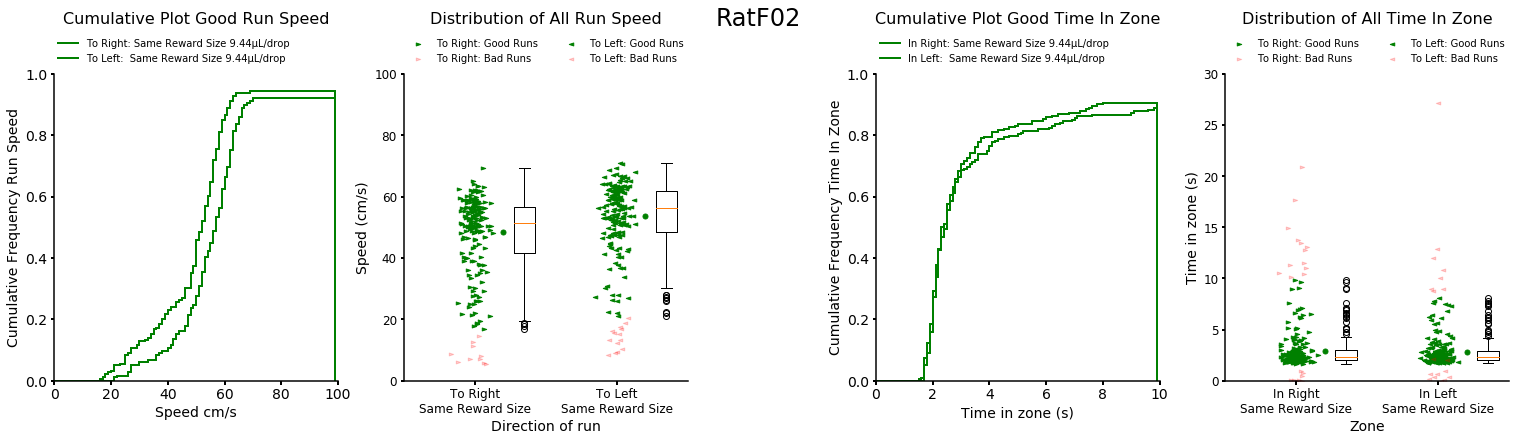

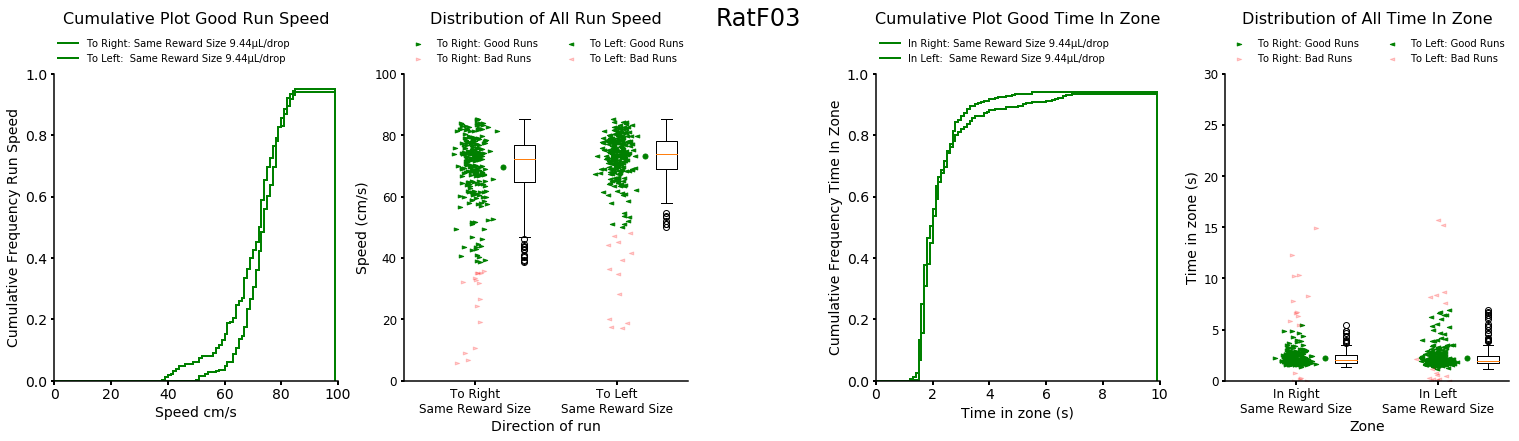

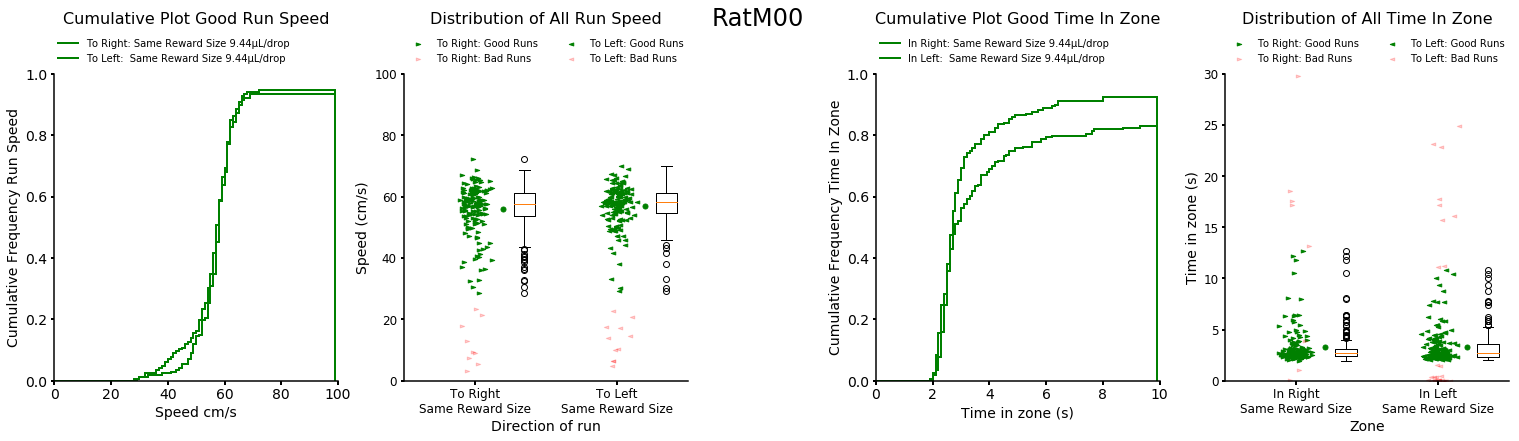

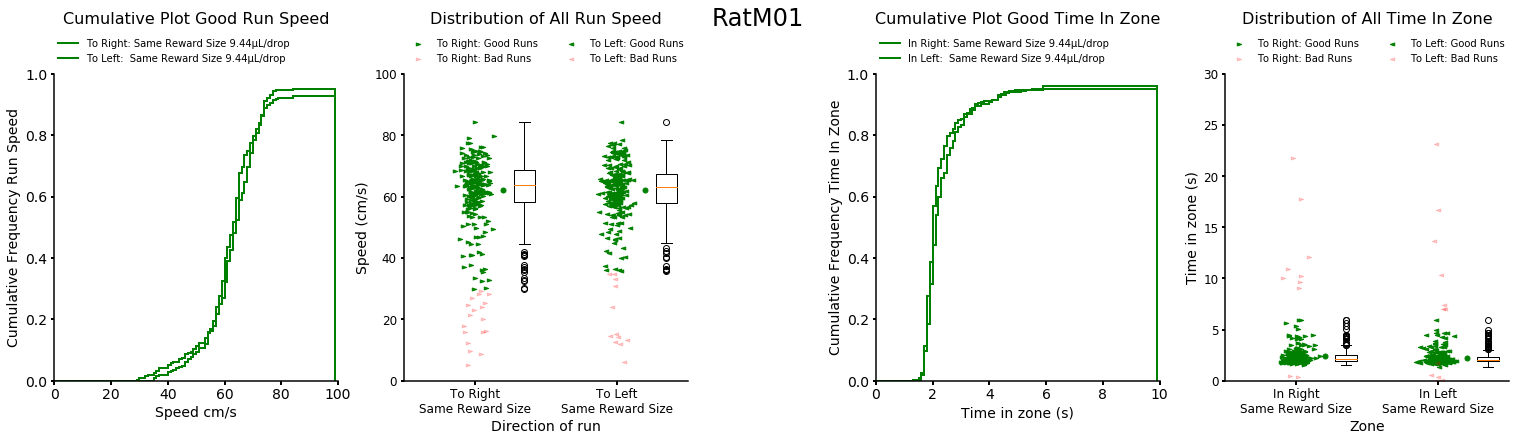

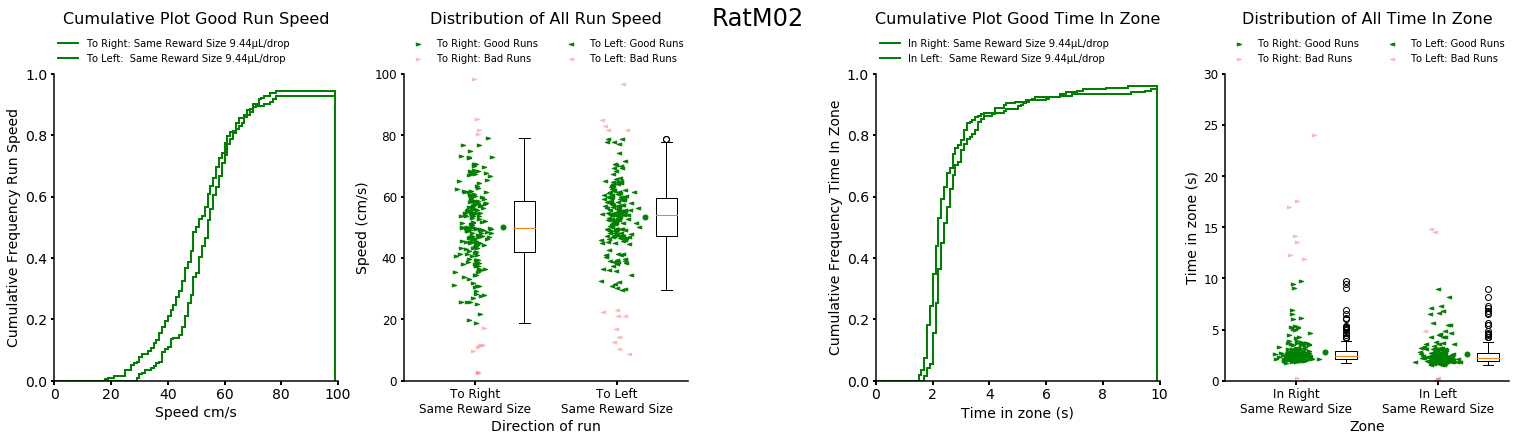

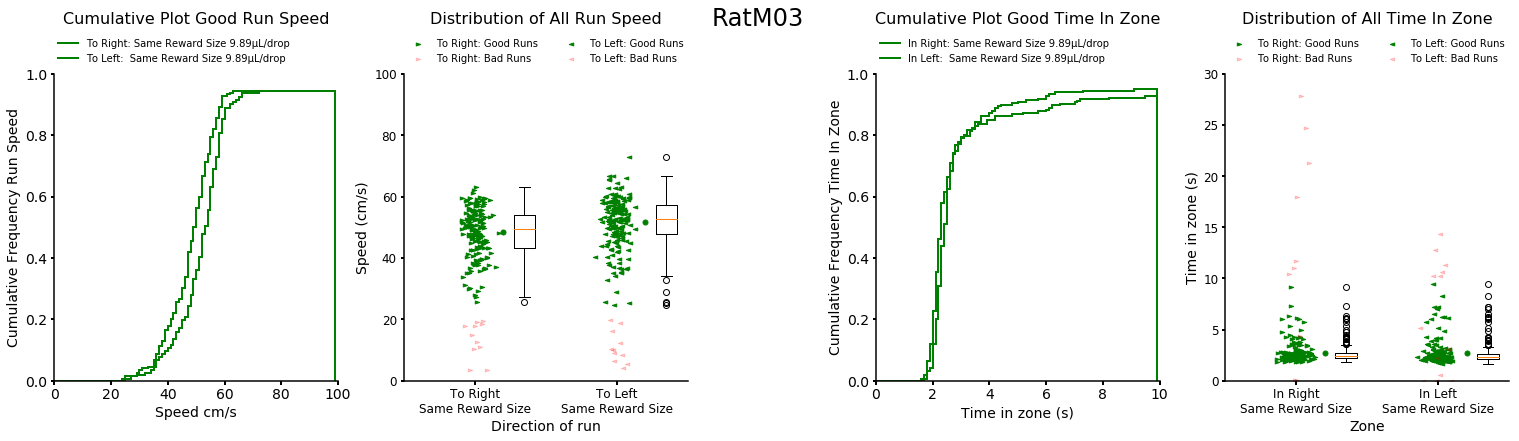

In [24]:
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            fig = plt.figure(constrained_layout = False, figsize=(21, 6))
            plt.suptitle(animal, y= 1, fontsize = 24)
            widths, heights = [5, 5, 1, 5, 5], [6]
            rows, cols = 1, 5
            spec = fig.add_gridspec(ncols=cols, nrows=rows, width_ratios=widths, height_ratios=heights)
            index=0
            sub = spec[0,2].subgridspec(2,1)

            for row in range(rows):
                for col in range(cols):
                    ax=fig.add_subplot(spec[row, col])              
                    if index == 0:
                        cumul_plot(good_speedRunToRight[animal, session], good_speedRunToLeft[animal, session], bad_speedRunToRight[animal, session], bad_speedRunToLeft[animal, session], barplotaxes = [0, 100, 0, 1], maxminstepbin = [0,100,1], scatterplotaxes = [0.5, 2.5, 0, 100], xyLabels=["Speed cm/s","Cumulative Frequency Run Speed", 14, 12], title=["Cumulative Plot Good Run Speed", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
                        index+=1
                    elif index ==1:
                        distribution_plot(good_speedRunToRight[animal, session], good_speedRunToLeft[animal, session], bad_speedRunToRight[animal, session], bad_speedRunToLeft[animal, session], barplotaxes = [0, 100, 0, 1], maxminstepbin = [0, 100, 1], scatterplotaxes = [0.5, 2.5, 0, 100], xyLabels=["Speed (cm/s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title=["Distribution of All Run Speed", 16], linewidth = [1.5], legend = ["To Right: Good Runs ", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
                        index+=1
                    elif index ==2:
                        blank_plot()
                        index+=1
                    elif index ==3:
                        cumul_plot(good_timeStayInRight[animal, session], good_timeStayInLeft[animal, session], bad_timeStayInRight[animal, session], bad_timeStayInLeft[animal, session], barplotaxes = [0, 10, 0, 1], maxminstepbin = [0, 10, 0.1], scatterplotaxes = [0.5, 2.5, 0, 30], xyLabels=["Time in zone (s)","Cumulative Frequency Time In Zone", 14, 12], title=["Cumulative Plot Good Time In Zone", 16], linewidth = [1.5], legend = ["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
                        index+=1
                    elif index ==4:
                        distribution_plot(good_timeStayInRight[animal, session], good_timeStayInLeft[animal, session], bad_timeStayInRight[animal, session], bad_timeStayInLeft[animal, session], barplotaxes = [0, 30, 0, 1], maxminstepbin = [0,30,1], scatterplotaxes = [0.5, 2.5, 0, 30], xyLabels=["Time in zone (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title=["Distribution of All Time In Zone", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
                        index+=1

plt.show()

# Pooled cumul plot

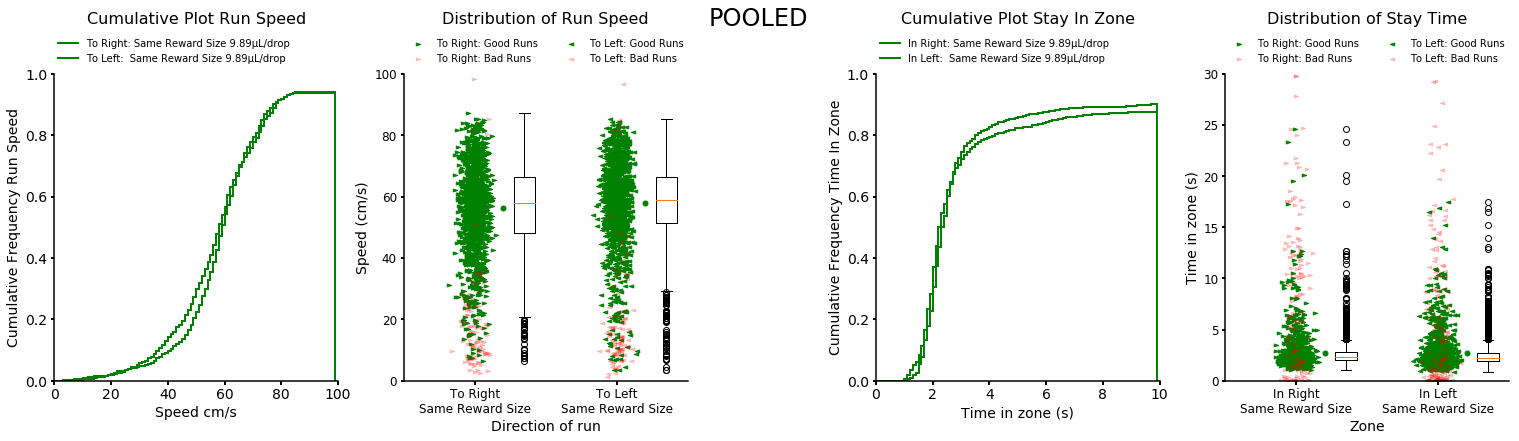

In [25]:
fig = plt.figure(constrained_layout = False, figsize=(21, 6))
plt.suptitle("POOLED", y= 1, fontsize = 24)
widths, heights = [5, 5, 1, 5, 5], [6]
rows, cols = 1, 5
spec = fig.add_gridspec(ncols=cols, nrows=rows, width_ratios=widths, height_ratios=heights)
index=0
sub = spec[0,2].subgridspec(2,1)

for row in range(rows):
    for col in range(cols):
        ax=fig.add_subplot(spec[row, col])    
        if index == 0:
            cumul_plot(good_speedRunToRightPooled, good_speedRunToLeftPooled, bad_speedRunToRightPooled, bad_speedRunToLeftPooled, barplotaxes = [0, 100, 0, 1], maxminstepbin = [0,100,1], scatterplotaxes = [0.5, 2.5, 0, 100], xyLabels=["Speed cm/s","Cumulative Frequency Run Speed", 14, 12], title=["Cumulative Plot Run Speed", 16], linewidth = [1.5], legend = ["To Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
            index+=1
        elif index ==1:
            distribution_plot(good_speedRunToRightPooled, good_speedRunToLeftPooled, bad_speedRunToRightPooled, bad_speedRunToLeftPooled, barplotaxes = [0, 100, 0, 1], maxminstepbin = [0, 100, 1], scatterplotaxes = [0.5, 2.5, 0, 100], xyLabels=["Speed (cm/s)", "Direction of run", "To Right" + "\n" + water[animal, session][1], "To Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distribution of Run Speed", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
            index+=1
        elif index ==2:
            blank_plot()
            index+=1
        elif index ==3:
            cumul_plot(good_timeStayInRightPooled, good_timeStayInLeftPooled, bad_timeStayInRightPooled, bad_timeStayInLeftPooled, barplotaxes = [0, 10, 0, 1], maxminstepbin = [0, 10, 0.1], scatterplotaxes = [0.5, 2.5, 0, 30], xyLabels=["Time in zone (s)","Cumulative Frequency Time In Zone", 14, 12], title=["Cumulative Plot Stay In Zone", 16], linewidth = [1.5], legend = ["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
            index+=1
        elif index ==4:
            distribution_plot(good_timeStayInRightPooled, good_timeStayInLeftPooled, bad_timeStayInRightPooled, bad_timeStayInLeftPooled, barplotaxes = [0, 30, 0, 1], maxminstepbin = [0,30,1], scatterplotaxes = [0.5, 2.5, 0, 30], xyLabels=["Time in zone (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title=["Distribution of Stay Time", 16], linewidth = [1.5], legend = ["To Right: Good Runs", "To Left: Good Runs", "To Right: Bad Runs", "To Left: Bad Runs"])
            index+=1

# lick data

In [26]:
prePooledL = list(itertools.chain.from_iterable(list(lick_arrivalLeft.values())))
prePooledR = list(itertools.chain.from_iterable(list(lick_arrivalRight.values())))
drinkPooledL = list(itertools.chain.from_iterable(list(lick_drinkingLeft.values())))
drinkPooledR = list(itertools.chain.from_iterable(list(lick_drinkingRight.values())))
waitPooledL = list(itertools.chain.from_iterable(list(lick_waitLeft.values())))
waitPooledR = list(itertools.chain.from_iterable(list(lick_waitRight.values())))

for animal in animalList: 
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList:  
        if params[animal, session]["hasLick"] == True:
            print(animal)     

            print("pre   ", "L", "%.2f" % np.mean(lick_arrivalLeft[animal, session]), "\u00B1", "%.2f" % scipy.stats.sem(lick_arrivalLeft[animal, session]), "  R", "%.2f" % np.mean(lick_arrivalRight[animal, session]), "\u00B1", "%.2f" % scipy.stats.sem(lick_arrivalRight[animal, session]))
            print("drink ", "L", "%.2f" % np.mean(lick_drinkingLeft[animal, session]), "\u00B1", "%.2f" % scipy.stats.sem(lick_drinkingLeft[animal, session]), "  R", "%.2f" % np.mean(lick_drinkingRight[animal, session]), "\u00B1", "%.2f" % scipy.stats.sem(lick_drinkingRight[animal, session]))
            print("wait  ", "L", "%.2f" % np.mean(lick_waitLeft[animal, session]), "\u00B1", "%.2f" % scipy.stats.sem(lick_waitLeft[animal, session]), "  R", "%.2f" % np.mean(lick_waitRight[animal, session]), "\u00B1", "%.2f" % scipy.stats.sem(lick_waitRight[animal, session]))
            print()
print()
print("POOLED")
print("pre   ", "L", "%.2f" % np.mean(prePooledL), "\u00B1", "%.2f" % scipy.stats.sem(prePooledL), "  R", "%.2f" % np.mean(prePooledR), "\u00B1", "%.2f" % scipy.stats.sem(prePooledR))
print("drink ", "L", "%.2f" % np.mean(drinkPooledL), "\u00B1", "%.2f" % scipy.stats.sem(drinkPooledL), "  R", "%.2f" % np.mean(drinkPooledR), "\u00B1", "%.2f" % scipy.stats.sem(drinkPooledR))
print("wait  ", "L", "%.2f" % np.mean(waitPooledL), "\u00B1", "%.2f" % scipy.stats.sem(waitPooledL), "  R", "%.2f" % np.mean(waitPooledR), "\u00B1", "%.2f" % scipy.stats.sem(waitPooledR))

RatF00
pre    L 0.33 ± 0.03   R 0.38 ± 0.02
drink  L 0.61 ± 0.06   R 0.79 ± 0.13
wait   L 1.48 ± 0.22   R 1.65 ± 0.22

RatF01
pre    L 1.86 ± 0.52   R 2.20 ± 0.71
drink  L 3.97 ± 2.02   R 5.10 ± 1.97
wait   L 7.86 ± 2.00   R 5.15 ± 1.09

RatF02
pre    L 0.20 ± 0.01   R 0.22 ± 0.01
drink  L 1.51 ± 0.06   R 1.50 ± 0.11
wait   L 1.41 ± 0.18   R 1.79 ± 0.20

RatF03
pre    L 0.23 ± 0.01   R 0.26 ± 0.01
drink  L 1.52 ± 0.13   R 1.45 ± 0.08
wait   L 0.67 ± 0.08   R 0.61 ± 0.05

RatM00
pre    L 0.61 ± 0.04   R 0.53 ± 0.01
drink  L 1.69 ± 0.23   R 1.74 ± 0.25
wait   L 1.62 ± 0.15   R 1.58 ± 0.17

RatM01
pre    L 0.28 ± 0.01   R 0.30 ± 0.01
drink  L 1.23 ± 0.07   R 1.24 ± 0.07
wait   L 0.89 ± 0.11   R 1.04 ± 0.11

RatM02
pre    L 0.46 ± 0.01   R 0.51 ± 0.02
drink  L 1.91 ± 0.35   R 1.64 ± 0.16
wait   L 0.72 ± 0.06   R 1.13 ± 0.16

RatM03
pre    L 0.92 ± 0.02   R 0.88 ± 0.01
drink  L 0.81 ± 0.04   R 0.82 ± 0.03
wait   L 1.26 ± 0.22   R 1.43 ± 0.23


POOLED
pre    L 0.45 ± 0.02   R 0.47 ± 0.02
dri

In [27]:
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:   
            if params[animal, session]["hasLick"] == True:
            #compute stats for individual animals
                print("arrival")
                statsrun(lick_arrivalRight[animal, session], lick_arrivalLeft[animal, session], animal)
                print("drink")
                statsrun(lick_drinkingRight[animal, session], lick_drinkingLeft[animal, session], animal)
                print("wait")
                statsrun(lick_waitRight[animal, session], lick_waitLeft[animal, session], animal)
                print()
print()
print("************POOLED***********")
#compute stats for the group
statsrun(prePooledL, prePooledR, "")
statsrun(drinkPooledL, drinkPooledR, "")
statsrun(waitPooledL, waitPooledR, "")

arrival
RatF00
=>=>=>=>=>=> 	 <-----------
0.38 ± 0.02 	 0.33 ± 0.03      median R - L  0.30 0.25
1.2283727023445321e-05 * MannWhitney

drink
RatF00
-----------> 	 <-----------
0.79 ± 0.13 	 0.61 ± 0.06      median R - L  0.35 0.35
0.14257730383052275  MannWhitney

wait
RatF00
=>=>=>=>=>=> 	 <-----------
1.65 ± 0.22 	 1.48 ± 0.22      median R - L  0.80 0.60
8.235294238714048e-05 * MannWhitney


arrival
RatF01
-----------> 	 <-----------
2.20 ± 0.71 	 1.86 ± 0.52      median R - L  0.75 0.80
0.46628603246409983  MannWhitney

drink
RatF01
-----------> 	 <-----------
5.10 ± 1.97 	 3.97 ± 2.02      median R - L  1.65 1.22
0.18173585227783773  MannWhitney

wait
RatF01
-----------> 	 <=<=<=<=<=<=
5.15 ± 1.09 	 7.86 ± 2.00      median R - L  2.68 4.58
0.007550643218097952 * MannWhitney


arrival
RatF02
=>=>=>=>=>=> 	 <-----------
0.22 ± 0.01 	 0.20 ± 0.01      median R - L  0.20 0.15
0.04015063748252562 * MannWhitney

drink
RatF02
-----------> 	 <=<=<=<=<=<=
1.50 ± 0.11 	 1.51 ± 0.06      me

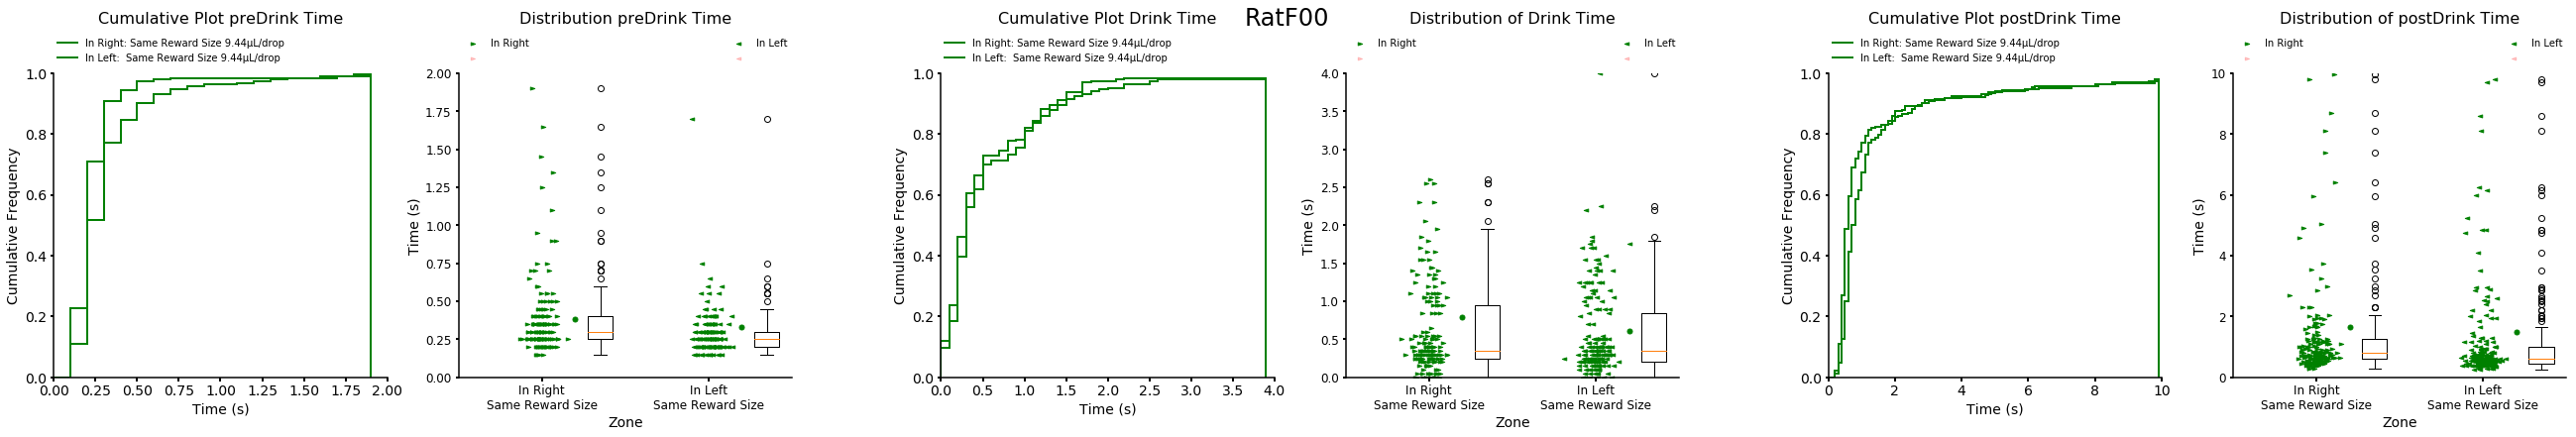

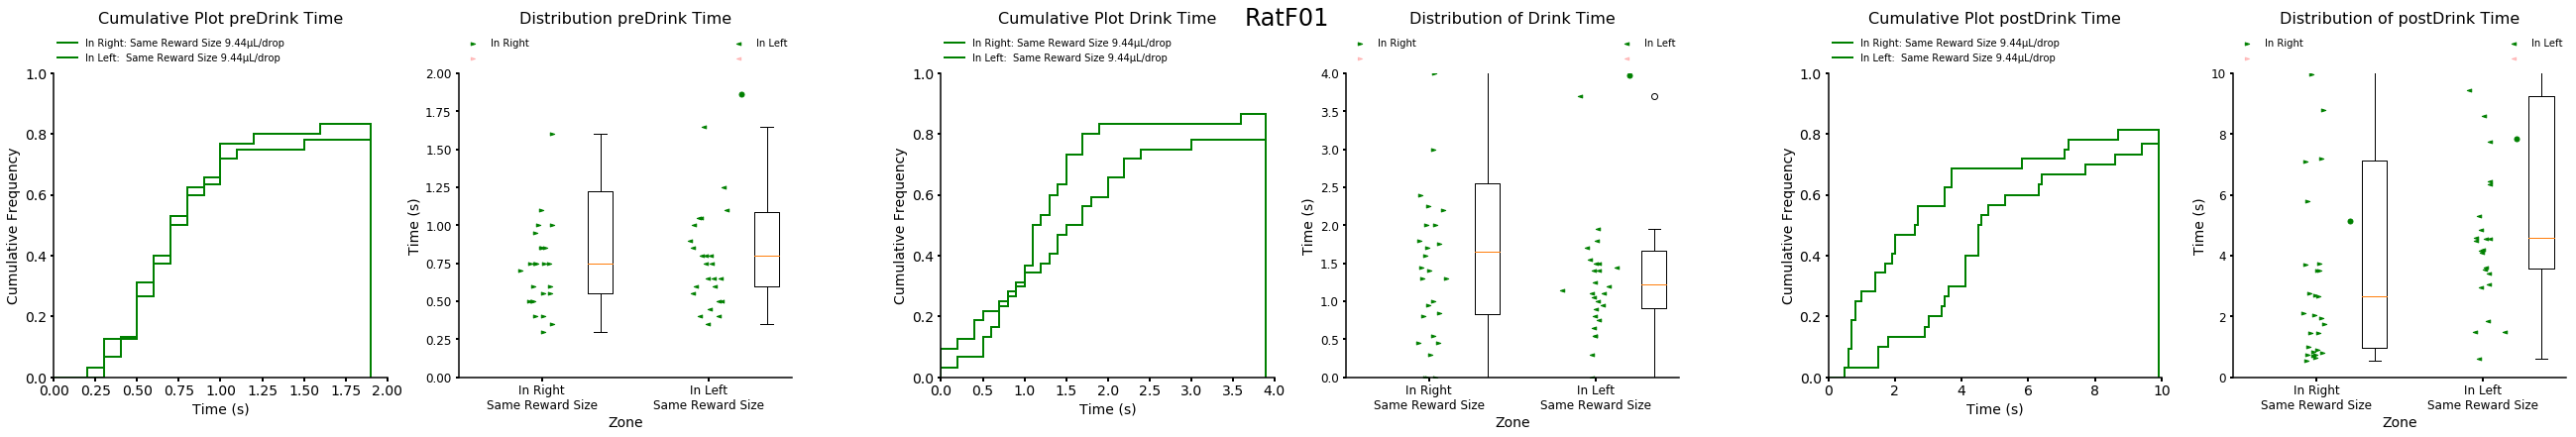

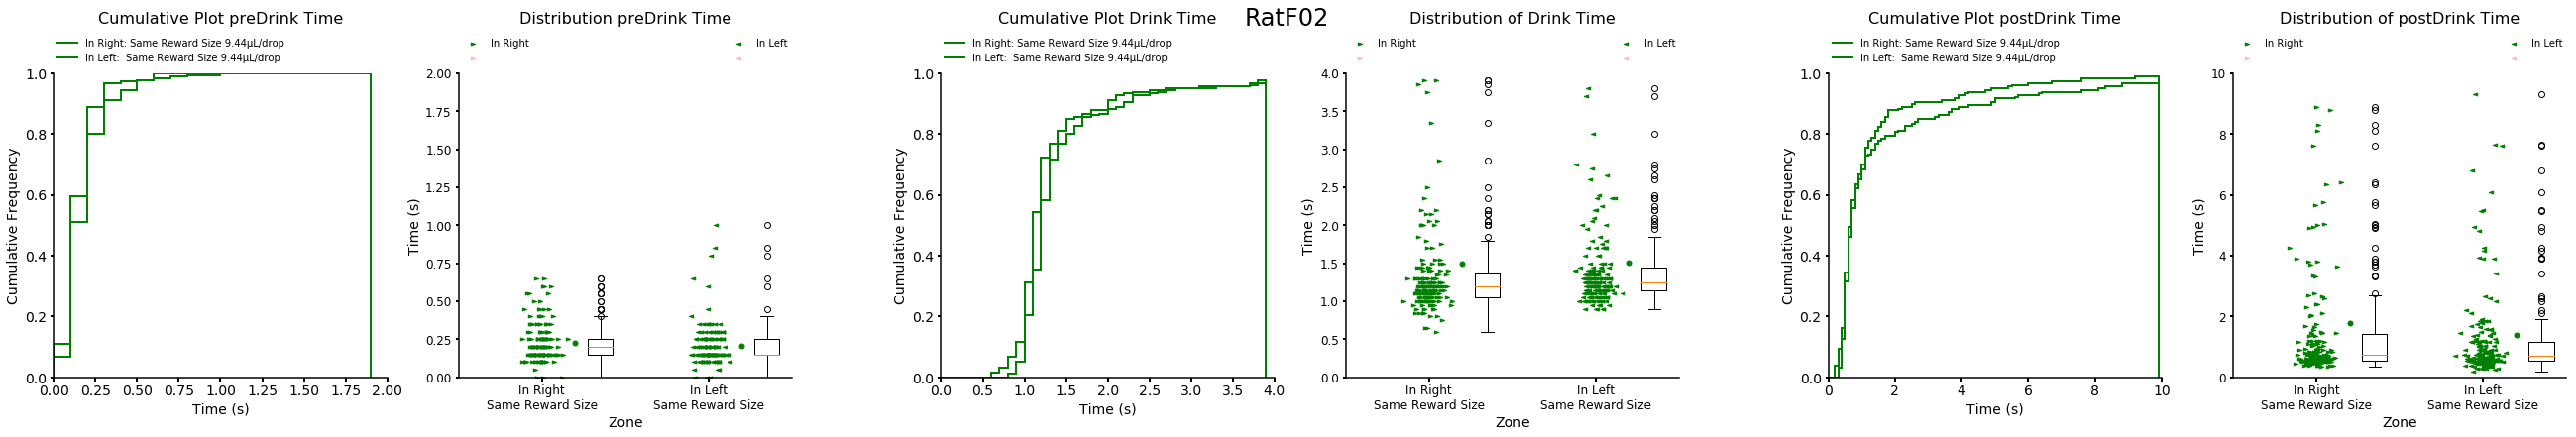

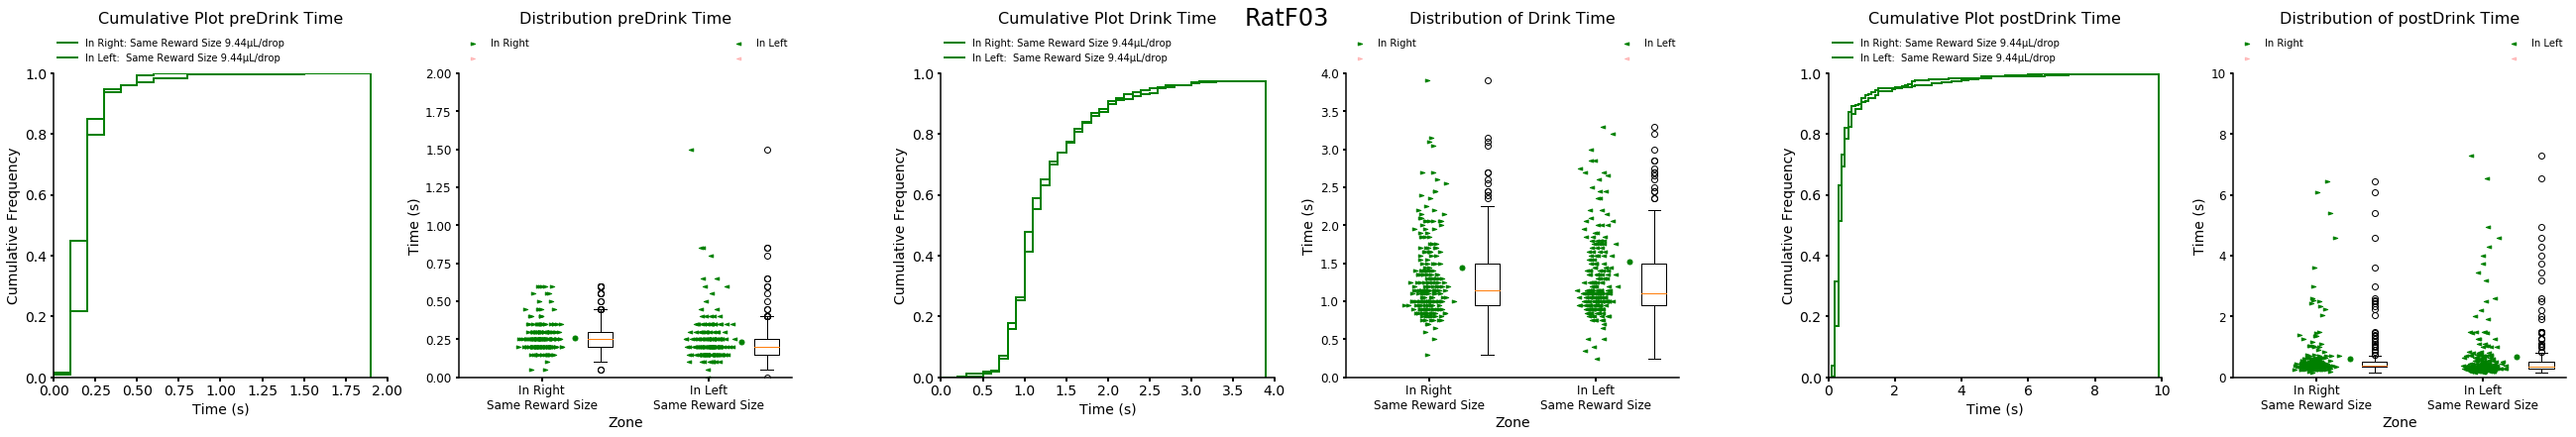

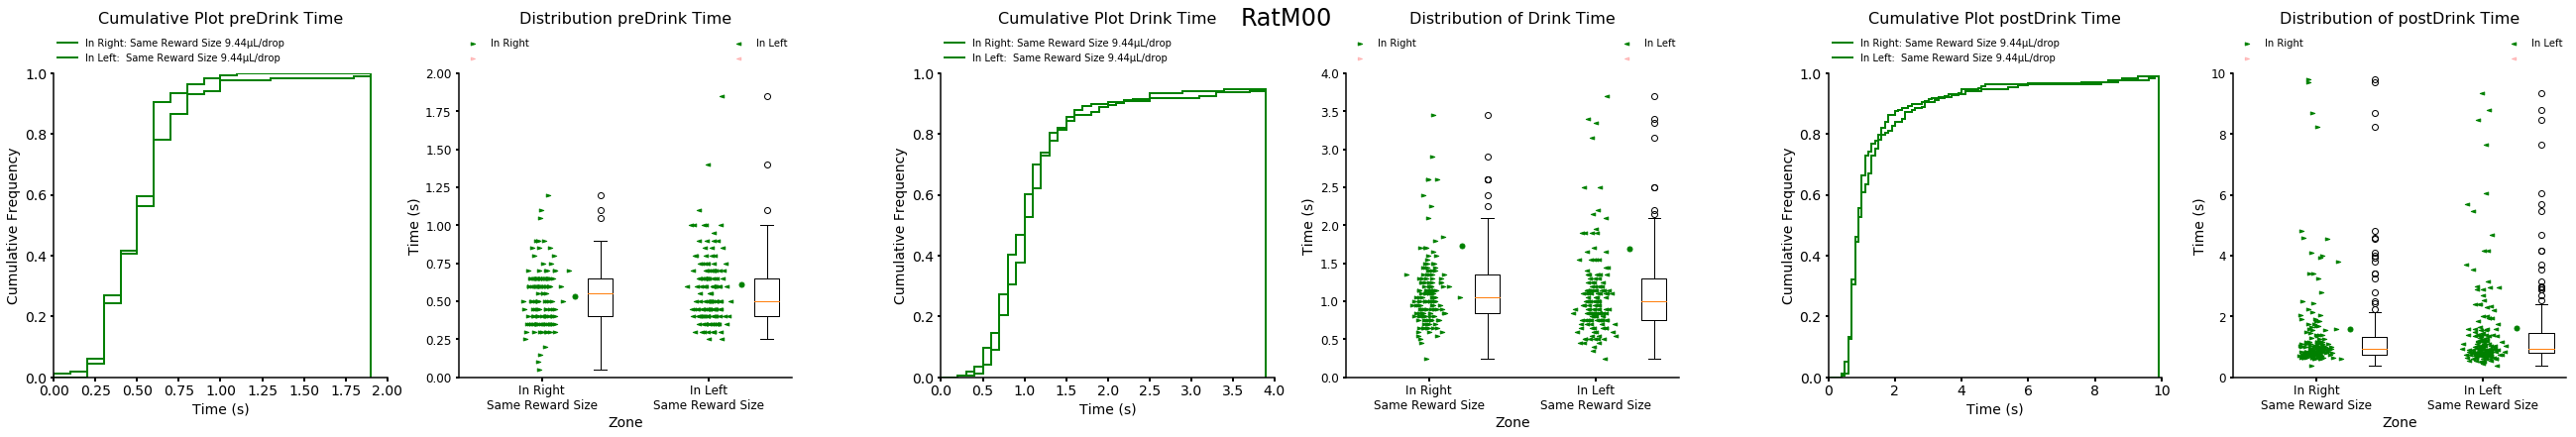

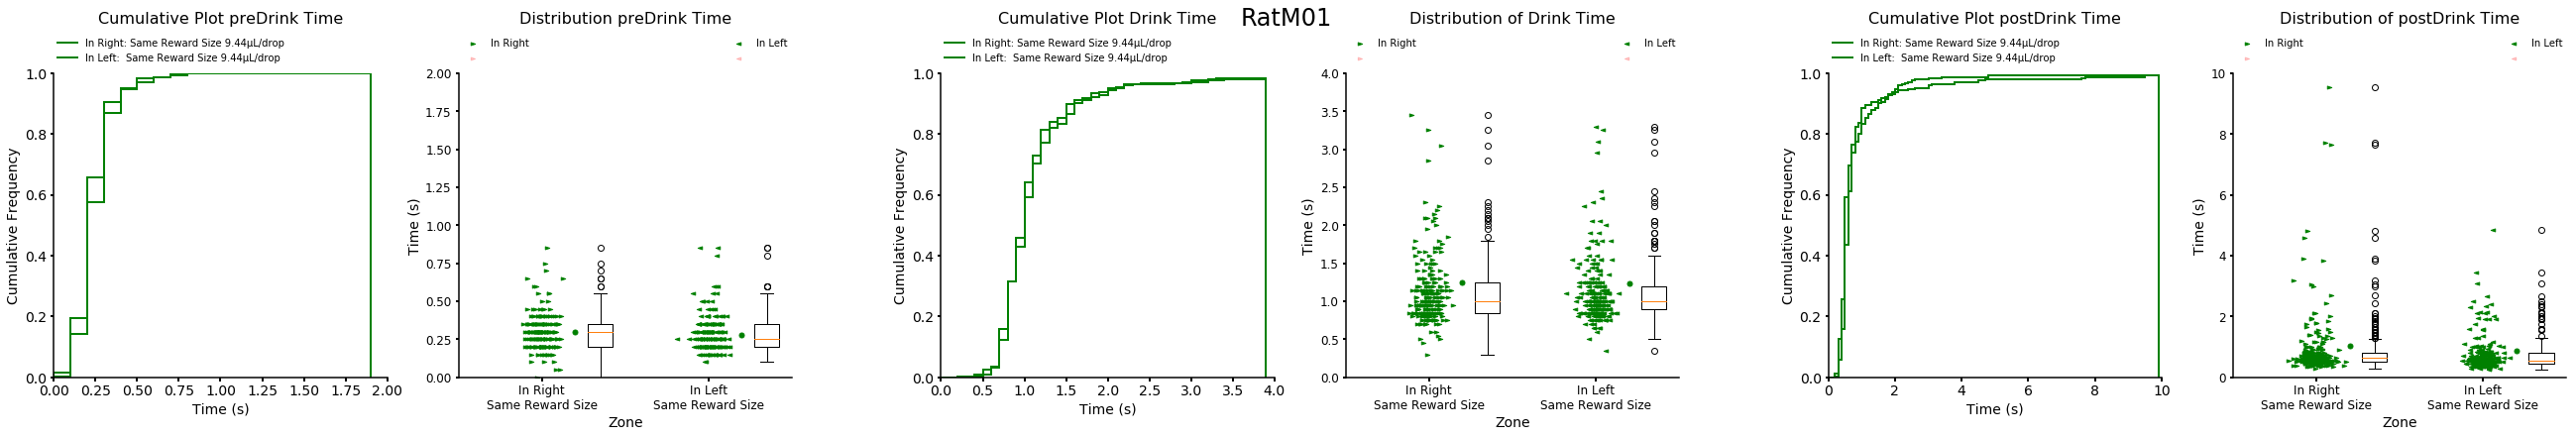

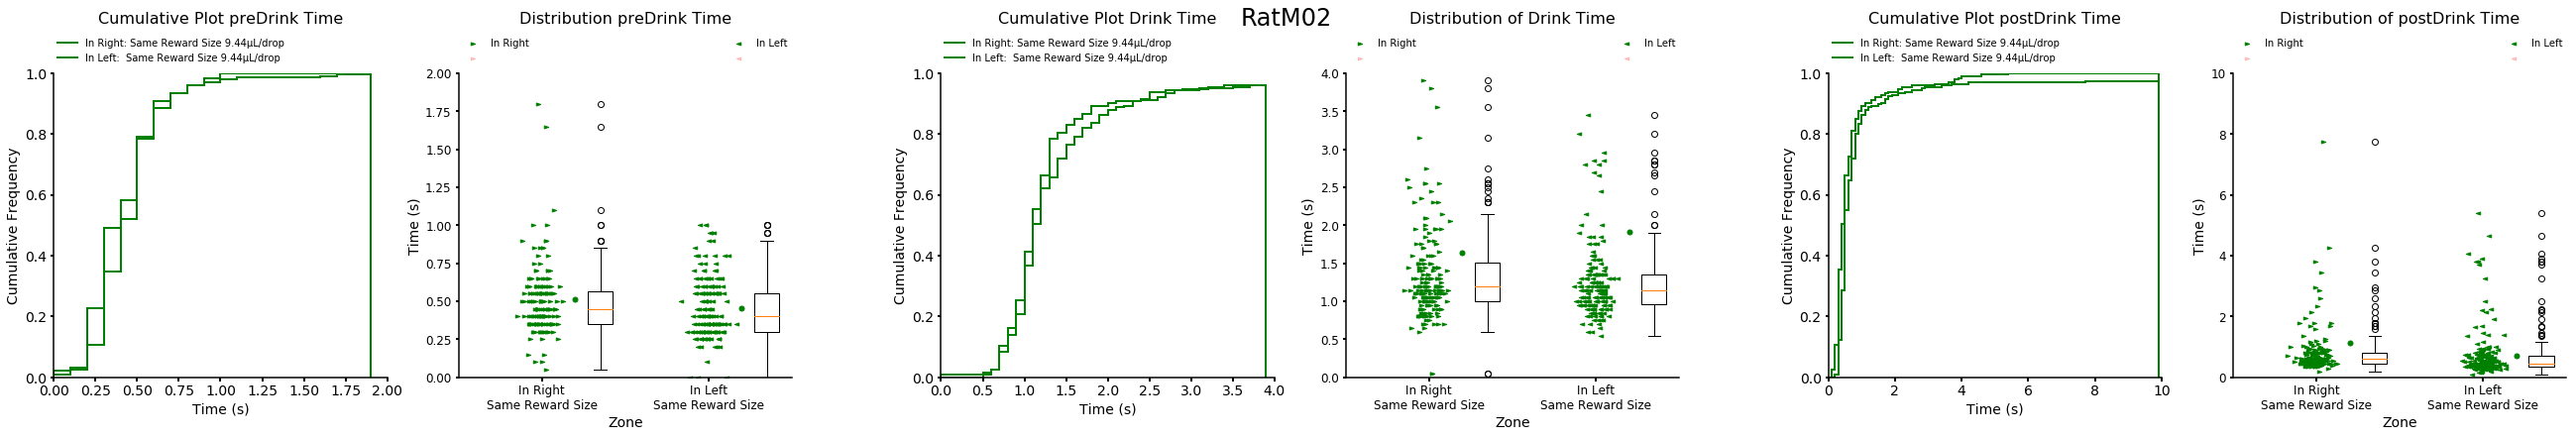

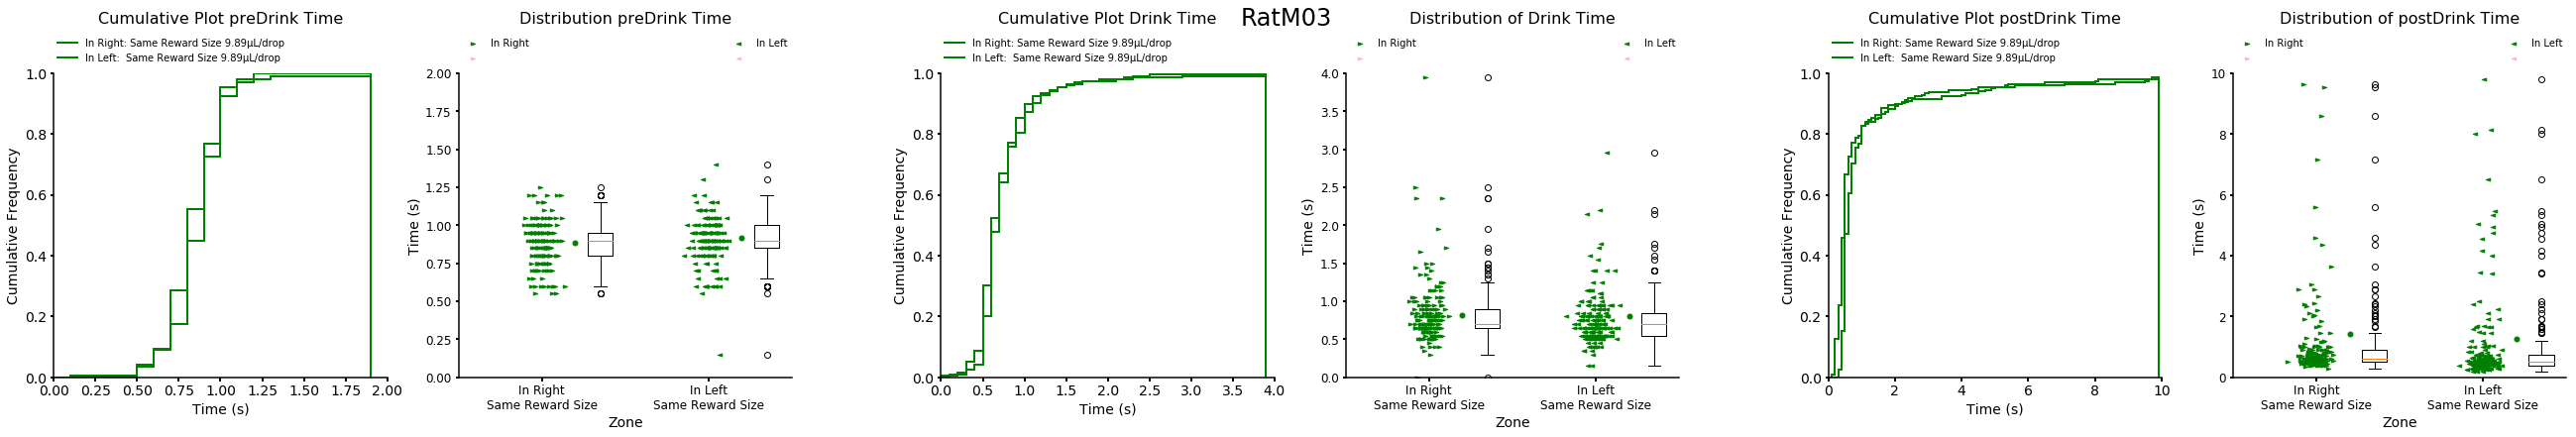

In [28]:
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            #if params[animal, session]["hasLick"] == True:
                fig = plt.figure(constrained_layout = False, figsize=(36, 6))
                plt.suptitle(animal, y= 1, fontsize = 24)
                widths, heights = [5, 5, 0.1, 5, 5, 0.1, 5, 5], [6]
                rows, cols = 1, 8
                spec = fig.add_gridspec(ncols=cols, nrows=rows, width_ratios=widths, height_ratios=heights)
                index=0
                sub = spec[0,2].subgridspec(2,1)

                for row in range(rows):
                    for col in range(cols):
                        ax=fig.add_subplot(spec[row, col])              
                        if index == 0:
                            cumul_plot(lick_arrivalRight[animal, session], lick_arrivalLeft[animal, session], [], [], barplotaxes = [0, 2, 0, 1], maxminstepbin = [0,2,0.1], scatterplotaxes = [0.5, 2.5, 0, 100], xyLabels=["Time (s)","Cumulative Frequency", 14, 12], title=["Cumulative Plot preDrink Time", 16], linewidth = [1.5], legend = ["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
                            index+=1

                        elif index ==1:
                            distribution_plot(lick_arrivalRight[animal, session], lick_arrivalLeft[animal, session], [], [], barplotaxes = [0, 100, 0, 1], maxminstepbin = [0, 100, 1], scatterplotaxes = [0.5, 2.5, 0, 2], xyLabels=["Time (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title=["Distribution preDrink Time", 16], linewidth = [1.5], legend = ["In Right", "In Left", " ", " "])
                            index+=1

                        elif index ==2:
                            blank_plot()
                            index+=1

                        elif index ==3:
                            cumul_plot(lick_drinkingRight[animal, session], lick_drinkingLeft[animal, session], [], [], barplotaxes = [0, 4, 0, 1], maxminstepbin = [0,4,0.1], scatterplotaxes = [0.5, 2.5, 0, 100], xyLabels=["Time (s)","Cumulative Frequency", 14, 12], title=["Cumulative Plot Drink Time", 16], linewidth = [1.5], legend = ["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
                            index +=1

                        elif index ==4:
                            distribution_plot(lick_drinkingRight[animal, session], lick_drinkingLeft[animal, session], [], [], barplotaxes = [0, 100, 0, 1], maxminstepbin = [0, 100, 1], scatterplotaxes = [0.5, 2.5, 0, 4], xyLabels=["Time (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distribution of Drink Time", 16], linewidth = [1.5], legend = ["In Right", "In Left", " ", " "])
                            index+=1

                        elif index ==5:
                            blank_plot()
                            index+=1

                        elif index ==6:
                            cumul_plot(lick_waitRight[animal, session], lick_waitLeft[animal, session], [], [], barplotaxes = [0, 10, 0, 1], maxminstepbin = [0,10,0.1], scatterplotaxes = [0.5, 2.5, 0, 100], xyLabels=["Time (s)","Cumulative Frequency", 14, 12], title=["Cumulative Plot postDrink Time", 16], linewidth = [1.5], legend = ["In Right: " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left:  " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", water[animal, session][2], water[animal, session][3]])
                            index +=1

                        elif index ==7:
                            distribution_plot(lick_waitRight[animal, session], lick_waitLeft[animal, session], [], [], barplotaxes = [0, 100, 0, 1], maxminstepbin = [0, 100, 1], scatterplotaxes = [0.5, 2.5, 0, 10], xyLabels=["Time (s)", "Zone", "In Right" + "\n" + water[animal, session][1], "In Left" + "\n" + water[animal, session][0], 14, 12], title = ["Distribution of postDrink Time", 16], linewidth = [1.5], legend = ["In Right", "In Left", " ", " "])

plt.show()

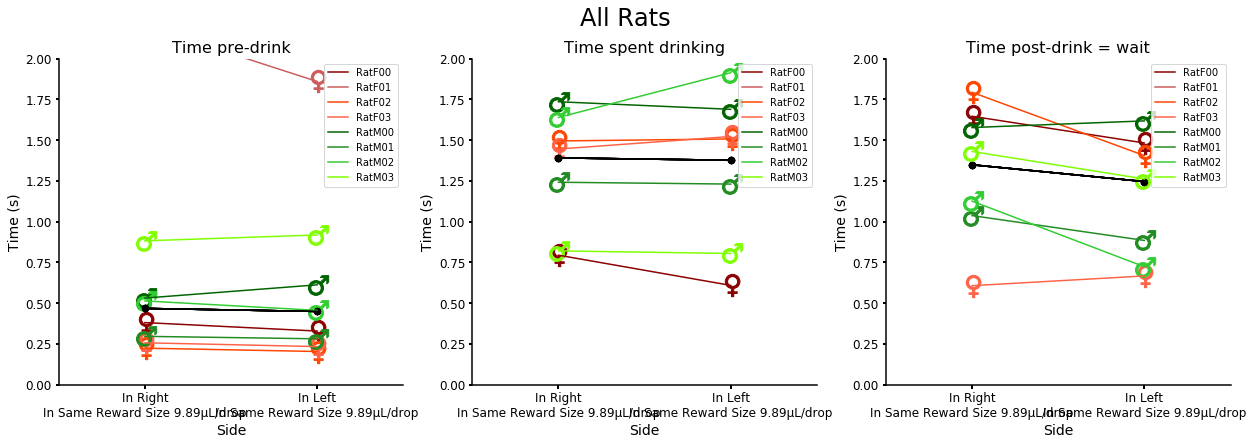

In [29]:
fig = plt.figure(constrained_layout = False, figsize=(21, 6))
plt.suptitle("All Rats", y= 1, fontsize = 24)
widths, heights = [5, 5, 5], [6]
rows, cols = 1, 3
spec = fig.add_gridspec(ncols=cols, nrows=rows, width_ratios=widths, height_ratios=heights)
index=0
sub = spec[0,2].subgridspec(2,1)

for row in range(rows):
    for col in range(cols):
        ax=fig.add_subplot(spec[row, col])              
        if index == 0:
            plot_recap(animal, session, lick_arrivalRight, lick_arrivalLeft, [], [], axes = [0.5, 2.5, 0, 2], xyLabels=["In Right" + "\n" + "In " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left" + "\n" + "In " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", "Side", "Time (s)", 14, 12], title=["Time pre-drink", 16], linewidth = [1.5])
            index+=1
        elif index ==1:
            plot_recap(animal, session, lick_drinkingRight, lick_drinkingLeft, [], [], axes = [0.5, 2.5, 0, 2], xyLabels=["In Right" + "\n" + "In " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left" + "\n" + "In " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", "Side", "Time (s)", 14, 12], title=["Time spent drinking", 16], linewidth = [1.5])
            index+=1
        elif index ==2:
            plot_recap(animal, session, lick_waitRight, lick_waitLeft, [], [], axes = [0.5, 2.5, 0, 2], xyLabels=["In Right" + "\n" + "In " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left" + "\n" + "In " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", "Side", "Time (s)", 14, 12], title=["Time post-drink = wait", 16], linewidth = [1.5])

# PLOT RECAPS

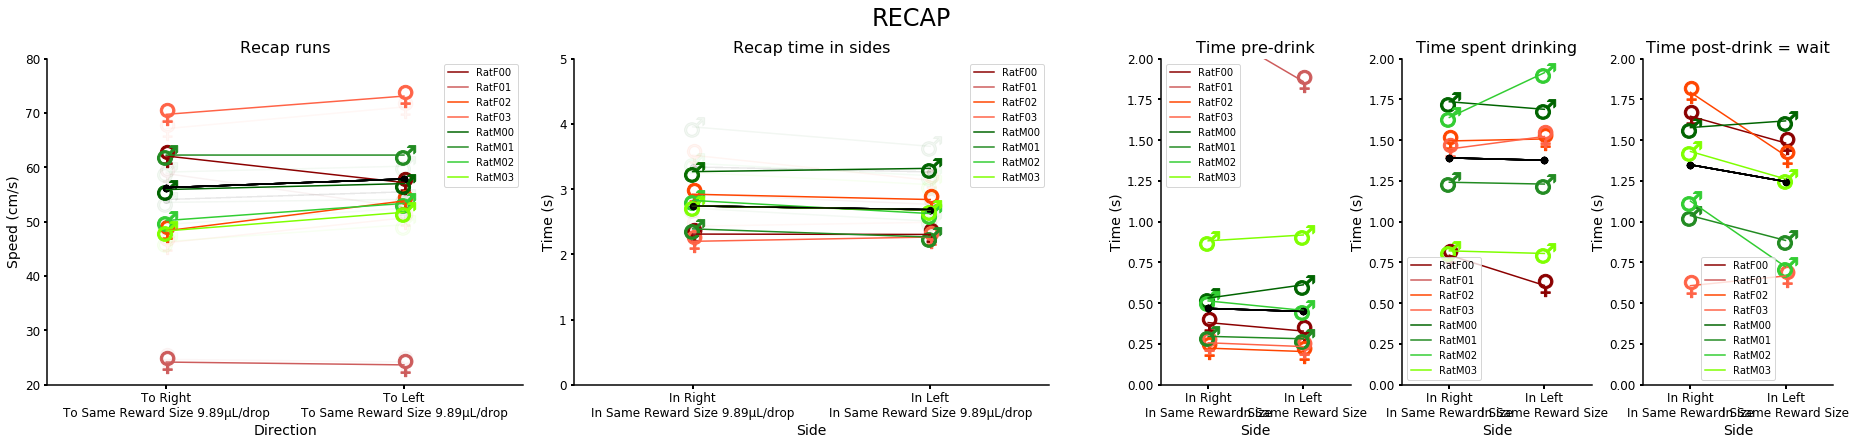

In [30]:

fig = plt.figure(constrained_layout = False, figsize=(32, 6))
plt.suptitle("RECAP", y= 1, fontsize = 24)
widths, heights = [5, 5, 0.1, 2, 2, 2], [6]
rows, cols = 1, 6
spec = fig.add_gridspec(ncols=cols, nrows=rows, width_ratios=widths, height_ratios=heights)
index=0
#sub = spec[0,2].subgridspec(2,1)

for row in range(rows):
    for col in range(cols):
        ax=fig.add_subplot(spec[row, col])              
        if index == 0:
            plot_recap(animal, session, good_speedRunToRight, good_speedRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, axes = [0.5, 2.5, 20, 80], xyLabels=["To Right" + "\n" + "To " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left" + "\n" + "To " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", "Direction", "Speed (cm/s)", 14, 12], title=["Recap runs", 16], linewidth = [1.5])
            index+=1
        elif index ==1:
            plot_recap(animal, session, good_timeStayInRight, good_timeStayInLeft, bad_timeStayInRight, bad_timeStayInLeft, axes = [0.5, 2.5, 0, 5], xyLabels=["In Right" + "\n" + "In " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left" + "\n" + "In " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", "Side", "Time (s)", 14, 12], title=["Recap time in sides", 16], linewidth = [1.5])
            index += 1
        elif index ==2:
            blank_plot()
            index+=1
        elif index ==3:
            plot_recap(animal, session, lick_arrivalRight, lick_arrivalLeft, [], [], axes = [0.5, 2.5, 0, 2], xyLabels=["In Right" + "\n" + "In " + water[animal, session][1], "In Left" + "\n" + "In " + water[animal, session][0], "Side", "Time (s)", 14, 12], title=["Time pre-drink", 16], linewidth = [1.5])
            index+=1
        elif index ==4:
            plot_recap(animal, session, lick_drinkingRight, lick_drinkingLeft, [], [], axes = [0.5, 2.5, 0, 2], xyLabels=["In Right" + "\n" + "In " + water[animal, session][1], "In Left" + "\n" + "In " + water[animal, session][0], "Side", "Time (s)", 14, 12], title=["Time spent drinking", 16], linewidth = [1.5])
            index+=1
        elif index ==5:
            plot_recap(animal, session, lick_waitRight, lick_waitLeft, [], [], axes = [0.5, 2.5, 0, 2], xyLabels=["In Right" + "\n" + "In " + water[animal, session][1], "In Left" + "\n" + "In " + water[animal, session][0], "Side", "Time (s)", 14, 12], title=["Time post-drink = wait", 16], linewidth = [1.5])


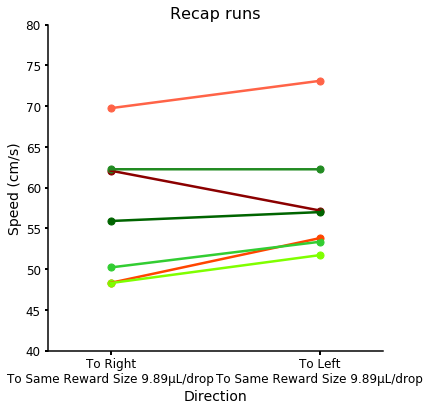

In [31]:
def plot_recapfigDavid(animal, session, gooddataRight, gooddataLeft, baddataRight, baddataLeft, axes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1): 
    for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            ax3 = plt.gca()
            plt.scatter(1, np.mean(gooddataRight[animal, session]), s=50, color =rat_markers[animal][0])
            plt.scatter(2, np.mean(gooddataLeft[animal, session]), s=50, color =rat_markers[animal][0])
            plt.plot((1, 2), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), color = rat_markers[animal][0], linewidth = 2.5)

            ax3.set_xlabel(xyLabels[2], fontsize = xyLabels[4])
            ax3.set_ylabel(xyLabels[3], fontsize = xyLabels[4])
            ax3.set_title(title[0], fontsize = title[1])
            ax3.set_xlim([axes[0], axes[1]])
            ax3.set_ylim([axes[2], axes[3]])
            ax3.set_xticks([1,2])
            ax3.set_xticklabels([xyLabels[0],xyLabels[1]], fontsize = xyLabels[4])
            ax3.spines['bottom'].set_linewidth(linewidth[0])
            ax3.spines['left'].set_linewidth(linewidth[0])
            ax3.spines['top'].set_color("none")
            ax3.spines['right'].set_color("none")
            ax3.tick_params(width=2, labelsize = xyLabels[5])
            #plt.legend()
fig = plt.figure(constrained_layout = False, figsize=(6, 6))
plot_recapfigDavid(animal, session, good_speedRunToRight, good_speedRunToLeft, [], [], axes = [0.7, 2.3, 40, 80], xyLabels=["To Right" + "\n" + "To " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left" + "\n" + "To " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", "Direction", "Speed (cm/s)", 14, 12], title=["Recap runs", 16], linewidth = [1.5])

In [32]:
#palette = ['r', 'm', 'y', 'c', 'firebrick', 'darkorange', 'limegreen', 'darkolivegreen']

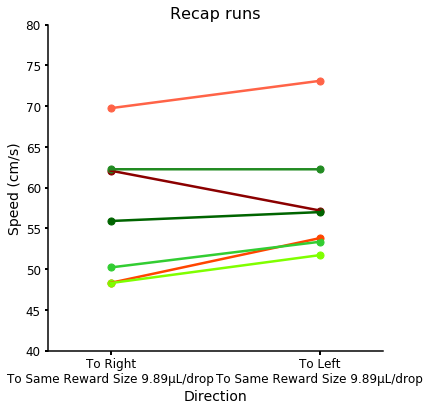

In [33]:
def plot_recapfigDavid(animal, session, gooddataRight, gooddataLeft, baddataRight, baddataLeft, axes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1): 
    for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            ax3 = plt.gca()
            plt.scatter(1, np.mean(gooddataRight[animal, session]), s=50, color =rat_markers[animal][0])
            plt.scatter(2, np.mean(gooddataLeft[animal, session]), s=50, color =rat_markers[animal][0])
            plt.plot((1, 2), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), color = rat_markers[animal][0], linewidth = 2.5)

            ax3.set_xlabel(xyLabels[2], fontsize = xyLabels[4])
            ax3.set_ylabel(xyLabels[3], fontsize = xyLabels[4])
            ax3.set_title(title[0], fontsize = title[1])
            ax3.set_xlim([axes[0], axes[1]])
            ax3.set_ylim([axes[2], axes[3]])
            ax3.set_xticks([1,2])
            ax3.set_xticklabels([xyLabels[0],xyLabels[1]], fontsize = xyLabels[4])
            ax3.spines['bottom'].set_linewidth(linewidth[0])
            ax3.spines['left'].set_linewidth(linewidth[0])
            ax3.spines['top'].set_color("none")
            ax3.spines['right'].set_color("none")
            ax3.tick_params(width=2, labelsize = xyLabels[5])
            #plt.legend()
fig = plt.figure(constrained_layout = False, figsize=(6, 6))
plot_recapfigDavid(animal, session, good_speedRunToRight, good_speedRunToLeft, [], [], axes = [0.7, 2.3, 40, 80], xyLabels=["To Right" + "\n" + "To " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left" + "\n" + "To " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", "Direction", "Speed (cm/s)", 14, 12], title=["Recap runs", 16], linewidth = [1.5])

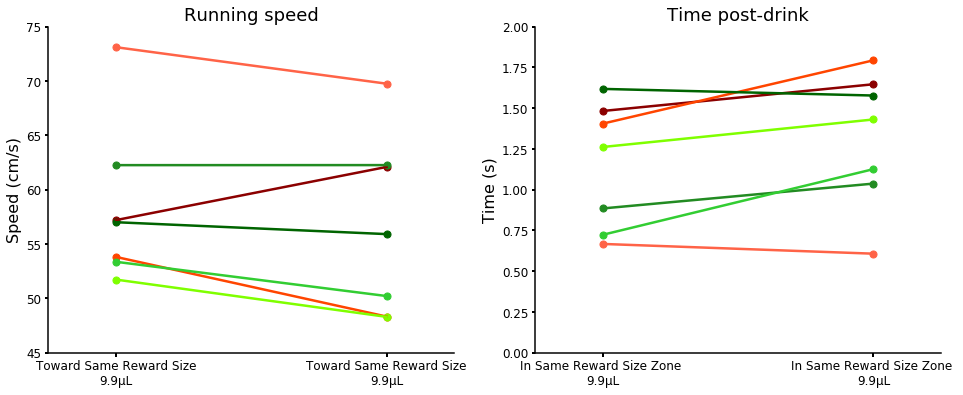

In [34]:
fig = plt.figure(constrained_layout = False, figsize=(16, 6))
#plt.suptitle("RECAP", y= 1, fontsize = 24)
widths, heights = [5, 5], [6]
rows, cols = 1, 2
spec = fig.add_gridspec(ncols=cols, nrows=rows, width_ratios=widths, height_ratios=heights)
index=0

for row in range(rows):
    for col in range(cols):
        ax=fig.add_subplot(spec[row, col])              
        if index == 0:
            plot_recapfigDavid(animal, session, good_speedRunToRight, good_speedRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, axes = [2.25, 0.75, 45, 75], xyLabels=["Toward " + water[animal, session][1] + "\n" + str(round(params[animal, session]["waterRight"], 1)) + "µL", "Toward " + water[animal, session][0] + "\n" + str(round(params[animal, session]["waterLeft"], 1)) + "µL", "", "Speed (cm/s)", 16, 12], title=["Running speed", 18], linewidth = [1.5])
            index+=1
        elif index ==1:
            plot_recapfigDavid(animal, session, lick_waitRight, lick_waitLeft, [], [], axes = [2.25, 0.75, 0, 2], xyLabels=["In " + water[animal, session][1] + " Zone \n" + str(round(params[animal, session]["waterRight"], 1)) + "µL", "In " + water[animal, session][0] + " Zone \n" + str(round(params[animal, session]["waterLeft"], 1)) + "µL", "", "Time (s)", 16, 12], title=["Time post-drink", 18], linewidth = [1.5])

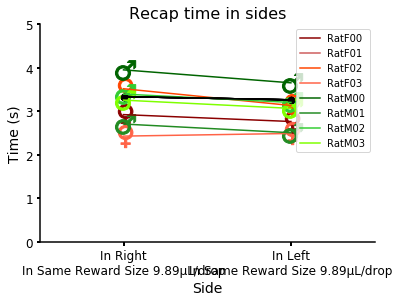

In [35]:
plot_recap(animal, session, all_timeStayInRight, all_timeStayInLeft, [], [], axes = [0.5, 2.5, 0, 5], xyLabels=["In Right" + "\n" + "In " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "In Left" + "\n" + "In " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", "Side", "Time (s)", 14, 12], title=["Recap time in sides", 16], linewidth = [1.5])

In [36]:
for animal in animalList: 
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList:  
        print(session, np.mean(all_speedRunToLeft[animal, session]) ,  np.mean(all_speedRunToRight[animal, session]))
    print()

RatF00_2020_07_22_13_17_25 52.6753373292263 58.85810945650116

RatF01_2020_07_22_13_49_33 24.201982533300615 24.677048956824837

RatF02_2020_07_22_14_36_11 50.69565130756707 46.12233949348447

RatF03_2020_07_22_15_07_14 71.11237209305719 67.1218060550565

RatM00_2020_07_22_15_38_49 54.10482978504592 53.55392771129326

RatM01_2020_07_22_16_09_59 60.214391317710295 59.13220218466526

RatM02_2020_07_22_16_41_19 52.49659975006274 49.49767181403198

RatM03_2020_07_22_17_12_34 49.446748497912864 46.346326096738274



In [37]:
# Time bins is essentially the same thing except that we divide the session in 6 sub sessions of 5 min, and loop through the 6 sub sessions --> put evrything together as the 30 min session would be equal to one subsession timeBins == 1

# TimeBins

In [38]:

timeBins = 6
binPositionX={}
binTime={}
binLickLeft1X={}
binLickRight1X={}
for animal in animalList: 
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            #create the N time bins
            binTime[animal, session] = bin_session(rawTime, rawTime, 0, acquisitionCutOff, timeBins)
            binPositionX[animal, session] = bin_session(rawPositionX, rawTime, 0, acquisitionCutOff, timeBins)
            binLickLeft1X[animal, session] = bin_session(rawLickLeft1X, rawTime, 0, acquisitionCutOff, timeBins)
            binLickRight1X[animal, session] = bin_session(rawLickRight1X, rawTime, 0, acquisitionCutOff, timeBins) 

In [39]:
def extract_runsRightLeftFilteredBin(dataPos, dataTime, dataLickR, dataLickL, animal, session, boundary, limspeed=None):

    rawdata_run = {}
    rawdata_stay = {}
    rawdata_run[animal, session] = {}
    rawdata_stay[animal, session] = {}

    good_speedRunToRight = {}
    good_speedRunToLeft = {}
    good_XtrackRunToRight = {}
    good_XtrackRunToLeft = {}
    good_timeRunToRight = {}
    good_timeRunToLeft = {}

    bad_speedRunToRight = {}
    bad_speedRunToLeft = {}
    bad_XtrackRunToRight = {}
    bad_XtrackRunToLeft = {}
    bad_timeRunToRight = {}
    bad_timeRunToLeft = {}

    all_speedRunToRight = {}
    all_speedRunToLeft = {}
    all_timeRunToRight = {}
    all_timeRunToLeft = {}



    good_timeStayInRight = {}
    good_timeStayInLeft = {}
    good_XtrackStayInRight = {}
    good_XtrackStayInLeft = {}
    good_TtrackStayInRight = {}
    good_TtrackStayInLeft = {}

    bad_timeStayInRight = {}
    bad_timeStayInLeft = {}
    bad_XtrackStayInRight = {}
    bad_XtrackStayInLeft = {}
    bad_TtrackStayInRight = {}
    bad_TtrackStayInLeft = {}

    all_timeStayInRight = {}
    all_timeStayInLeft = {}
    all_TtrackStayInRight = {}
    all_TtrackStayInLeft = {}

    lick_arrivalRight = {}
    lick_drinkingRight = {}
    lick_waitRight = {}
    lick_arrivalLeft = {}
    lick_drinkingLeft = {}
    lick_waitLeft = {}

    for i in range(0, timeBins):
        rawdata_run[animal, session][i] = {}
        rawdata_stay[animal, session][i] = {}

        good_speedRunToRight[i] = []
        good_speedRunToLeft[i] = []
        good_XtrackRunToRight[i] = []
        good_XtrackRunToLeft[i] = []
        good_timeRunToRight[i] = []
        good_timeRunToLeft[i] = []

        bad_speedRunToRight[i] = []
        bad_speedRunToLeft[i] = []
        bad_XtrackRunToRight[i] = []
        bad_XtrackRunToLeft[i] = []
        bad_timeRunToRight[i] = []
        bad_timeRunToLeft[i] = []

        all_speedRunToRight[i] = [] 
        all_speedRunToLeft[i] = []
        all_timeRunToRight[i] = [] 
        all_timeRunToLeft[i] = []



        good_timeStayInRight[i] = []
        good_timeStayInLeft[i] = []
        good_XtrackStayInRight[i] = []
        good_XtrackStayInLeft[i] = []
        good_TtrackStayInRight[i] = []
        good_TtrackStayInLeft[i] = []

        bad_timeStayInRight[i] = []
        bad_timeStayInLeft[i] = []
        bad_XtrackStayInRight[i] = []
        bad_XtrackStayInLeft[i] = []
        bad_TtrackStayInRight[i] = []
        bad_TtrackStayInLeft[i] = []

        all_timeStayInRight[i] = []
        all_timeStayInLeft[i] = []
        all_TtrackStayInRight[i] = []
        all_TtrackStayInLeft[i] = []

        lick_arrivalRight[i] = []
        lick_drinkingRight[i] = []
        lick_waitRight[i] = []
        lick_arrivalLeft[i] = []
        lick_drinkingLeft[i] = []
        lick_waitLeft[i] = []

        #crop the complete track at the set boundaries -> keep only the runs and set the rest to 0
        rawdata_run[animal, session][i] = [[e[0]/13.5, e[1]] if e[0] <= boundary[0] and e[0]>= boundary[1] else 0 for e in [[i , j] for i, j in zip(dataPos[animal, session][i],dataTime[animal, session][i])]]
        # use the split a list function to create a new sublist when there is a 0, which we just set up before
        for run in split_a_list_at_zeros(rawdata_run[animal, session][i]):
            #calculate distance run as the distance between first and last value
            distanceRun = abs(run[0][0]-run[-1][0])
            #calculate time as sum of time interval between frames
            totaltimeRun = []
            xTrackRun = []
            for item in run:
                xTrackRun.append(item[0])
                totaltimeRun.append(item[1])
            speedRun = distanceRun/np.sum(np.diff(totaltimeRun)) #pb number of items ?
            #check if the subsplit starts on the left or the right -> determine if the animal is running left or right
            if run[0][0] < (((boundary[0]+boundary[1])/2) /13.5):
                #check if the subsplit is ending on the other side -> determine if this is a run 
                if run[-1][0] > (((boundary[0]+boundary[1])/2) /13.5):
                    #check if there is a limspeed : if no compute all the runs -> used to compute limspeed
                    #second pass : there is a computed limspeed, use it to sort good and bad runs
                    if limspeed[0] is not None:
                        #check if this is a good or bad run and assign im to the good or bad array accordingly
                        if speedRun > limspeed[0][0] and speedRun < limspeed[0][1]:
                            #good run array
                            good_speedRunToRight[i].append(speedRun)
                            good_XtrackRunToRight[i].append(xTrackRun)
                            good_timeRunToRight[i].append(totaltimeRun)   
                        else:
                            #bad run array
                            bad_speedRunToRight[i].append(speedRun)
                            bad_XtrackRunToRight[i].append(xTrackRun)
                            bad_timeRunToRight[i].append(totaltimeRun)
                    else:
                        #all runs array first pass
                        all_speedRunToRight[i].append(speedRun)
                        all_timeRunToRight[i].append(totaltimeRun)

            #same thing for the runs that go to the other side
            elif run[0][0] > (((boundary[0]+boundary[1])/2)/13.5):
                if run[-1][0] < (((boundary[0]+boundary[1])/2)/13.5):
                    if limspeed[1] is not None:
                        if speedRun > limspeed[1][0] and speedRun < limspeed[1][1]:
                            good_speedRunToLeft[i].append(speedRun)   
                            good_XtrackRunToLeft[i].append(xTrackRun)
                            good_timeRunToLeft[i].append(totaltimeRun)
                        else:
                            bad_speedRunToLeft[i].append(speedRun)
                            bad_XtrackRunToLeft[i].append(xTrackRun)
                            bad_timeRunToLeft[i].append(totaltimeRun)
                    else:
                        all_speedRunToLeft[i].append(speedRun)
                        all_timeRunToLeft[i].append(totaltimeRun)

        # inverse crop, at the boundaries keep the distal parts, same process as above
        #same principle as packing time and position together
        #put stay : 0=position, 1=time, 2=lickright, 3=lickleft
        rawdata_stay[animal, session][i]= [[e[0]/13.5, e[1], e[2], e[3]] if e[0] >= boundary[0] or e[0] <= boundary[1] else 0 for e in [[i, j, k, l] for i, j, k, l in zip(dataPos[animal, session][i], dataTime[animal, session][i], dataLickR[animal, session][i], dataLickL[animal, session][i])]] #ooooook guuuud

        for stay in split_a_list_at_zeros(rawdata_stay[animal, session][i]):
            tInZone = []
            xTrackStay = []
            lickR = []
            lickL = []
            for item in stay:
                xTrackStay.append(item[0])
                tInZone.append(item[1])
                lickR.append(item[2])
                lickL.append(item[3])
            totaltimeStay = np.sum(np.diff(tInZone))
            #first identify if the subsplit created is on the left or right by comparing to the middle
            if stay[0][0] > (((boundary[0]+boundary[1]) / 2) / 13.5):
                # if empty put in bad stay
                if all(v == 0 for v in lickR):
                    bad_timeStayInRight[i].append(totaltimeStay)
                    bad_XtrackStayInRight[i].append(xTrackStay)
                    bad_TtrackStayInRight[i].append(tInZone)
                    continue
                pre = []
                drink = []
                post = []
                for t, l in zip(tInZone[0:np.min(np.nonzero(lickR))], lickR[0:np.min(np.nonzero(lickR))]):
                    pre.append(t)
                for t, l in zip(tInZone[np.min(np.nonzero(lickR)):np.max(np.nonzero(lickR))], lickR[np.min(np.nonzero(lickR)):np.max(np.nonzero(lickR))]):
                    drink.append(t)
                for t, l in zip(tInZone[np.max(np.nonzero(lickR)):-1], lickR[np.max(np.nonzero(lickR)):-1]):
                    post.append(t)
                
                #drink <- dig in that later on to have more info on lick (lick rate, number of licks, etc.)

                lick_arrivalRight[i].append(np.sum(np.diff(pre)))
                lick_drinkingRight[i].append(np.sum(np.diff(drink)))
                lick_waitRight[i].append(np.sum(np.diff(post)))

                if limspeed[0] is not None:
                    if totaltimeStay > limspeed[0][0] and totaltimeStay < limspeed[0][1]:
                        good_timeStayInRight[i].append(totaltimeStay)
                        good_XtrackStayInRight[i].append(xTrackStay)
                        good_TtrackStayInRight[i].append(tInZone)
                    else:
                        bad_timeStayInRight[i].append(totaltimeStay)
                        bad_XtrackStayInRight[i].append(xTrackStay)
                        bad_TtrackStayInRight[i].append(tInZone)
                else:
                    all_timeStayInRight[i].append(totaltimeStay)
                    all_TtrackStayInRight[i].append(tInZone)
        
            elif stay[0][0] < (((boundary[0] + boundary[1]) / 2) / 13.5):
                if all(v == 0 for v in lickL):
                    bad_timeStayInLeft[i].append(totaltimeStay)
                    bad_XtrackStayInLeft[i].append(xTrackStay)
                    bad_TtrackStayInLeft[i].append(tInZone)
                    continue
                preL = []
                drinkL = []
                postL = []
                for t, l in zip(tInZone[0:np.min(np.nonzero(lickL))], lickR[0:np.min(np.nonzero(lickL))]):
                    preL.append(t)
                for t, l in zip(tInZone[np.min(np.nonzero(lickL)):np.max(np.nonzero(lickL))], lickL[np.min(np.nonzero(lickL)):np.max(np.nonzero(lickL))]):
                    drinkL.append(t)
                for t, l in zip(tInZone[np.max(np.nonzero(lickL)):-1], lickL[np.max(np.nonzero(lickL)):-1]):
                    postL.append(t)

                lick_arrivalLeft[i].append(np.sum(np.diff(preL)))
                lick_drinkingLeft[i].append(np.sum(np.diff(drinkL)))
                lick_waitLeft[i].append(np.sum(np.diff(postL)))

                if limspeed[1] is not None:
                    if totaltimeStay > limspeed[1][0] and totaltimeStay < limspeed[1][1]:
                        good_timeStayInLeft[i].append(totaltimeStay)   
                        good_XtrackStayInLeft[i].append(xTrackStay)
                        good_TtrackStayInLeft[i].append(tInZone)
                    else:
                        bad_timeStayInLeft[i].append(totaltimeStay)
                        bad_XtrackStayInLeft[i].append(xTrackStay)
                        bad_TtrackStayInLeft[i].append(tInZone)
                else:
                    all_timeStayInLeft[i].append(totaltimeStay)
                    all_TtrackStayInRight[i].append(tInZone)

    return all_speedRunToRight, all_speedRunToLeft, all_timeRunToRight, all_timeRunToLeft, good_speedRunToRight, good_speedRunToLeft, good_XtrackRunToRight, good_XtrackRunToLeft, bad_speedRunToRight, bad_speedRunToLeft, bad_XtrackRunToRight, bad_XtrackRunToLeft, good_timeRunToRight, good_timeRunToLeft, bad_timeRunToRight, bad_timeRunToLeft, all_timeStayInRight, all_timeStayInLeft, all_TtrackStayInRight, all_TtrackStayInLeft, good_timeStayInRight, good_timeStayInLeft, good_XtrackStayInRight, good_XtrackStayInLeft, bad_timeStayInRight, bad_timeStayInLeft, bad_XtrackStayInRight, bad_XtrackStayInLeft, good_TtrackStayInRight, good_TtrackStayInLeft, bad_TtrackStayInRight, bad_TtrackStayInLeft, lick_arrivalRight, lick_drinkingRight, lick_waitRight, lick_arrivalLeft, lick_drinkingLeft, lick_waitLeft

In [40]:
all_speedRunToRightBin = {} 
all_speedRunToLeftBin = {}
all_timeRunToRightBin = {}# check used ?
all_timeRunToLeftBin = {}#
limspeedRunToRightBin = {}
limspeedRunToLeftBin = {}

good_speedRunToRightBin = {}
good_speedRunToLeftBin = {}
good_XtrackRunToRightBin = {}
good_XtrackRunToLeftBin = {}
good_timeRunToRightBin = {}
good_timeRunToLeftBin = {}

bad_speedRunToRightBin = {}
bad_speedRunToLeftBin = {}
bad_XtrackRunToRightBin = {}
bad_XtrackRunToLeftBin = {}
bad_timeRunToRightBin = {}
bad_timeRunToLeftBin = {}



all_timeStayInRightBin = {}
all_timeStayInLeftBin = {}
all_TtrackStayInRightBin = {} #
all_TtrackStayInLeftBin = {}#check if used
#all_speedToRightBin = {}
#all_speedToLeftBin = {}
limstayRightBin = {}
limstayLeftBin = {}

good_timeStayInRightBin = {}
good_timeStayInLeftBin = {}
good_XtrackStayInRightBin = {}
good_XtrackStayInLeftBin = {}
good_TtrackStayInRightBin = {}
good_TtrackStayInLeftBin = {}

bad_timeStayInRightBin = {}
bad_timeStayInLeftBin = {}
bad_XtrackStayInRightBin = {}
bad_XtrackStayInLeftBin = {}
bad_TtrackStayInRightBin = {}
bad_TtrackStayInLeftBin = {}


lick_arrivalRightBin = {}
lick_drinkingRightBin = {}
lick_waitRightBin = {}
lick_arrivalLeftBin = {}
lick_drinkingLeftBin = {}
lick_waitLeftBin = {}


for animal in animalList: 
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            #extract all the runs to compute limspeed
            all_speedRunToRightBin[animal, session], all_speedRunToLeftBin[animal, session], all_timeRunToRightBin[animal, session], all_timeRunToLeftBin[animal, session] = extract_runsRightLeftFilteredBin(binPositionX, binTime, binLickRight1X, binLickLeft1X, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [None, None])[0:4]
            all_timeStayInRightBin[animal, session], all_timeStayInLeftBin[animal, session], all_TtrackStayInRightBin[animal, session], all_TtrackStayInLeftBin[animal, session] = extract_runsRightLeftFilteredBin(binPositionX, binTime, binLickRight1X, binLickLeft1X, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [None, None])[16:20]

            #compute limspeed (speed below which we consider that the rats are not running) as the speeds below 2 st dev of the mean speed. can be changed
            #test intervalle de confiance
            limspeedRunToRightBin[animal, session] = limspeedRunToRight[animal, session]
            limspeedRunToLeftBin[animal, session]  = limspeedRunToLeft[animal, session]
            limstayRightBin[animal, session]       = limstayRight[animal, session]
            limstayLeftBin[animal, session]        = limstayLeft[animal, session] 

            #extract the run data (good/bad, to left/ to right) 
            good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session], good_XtrackRunToRightBin[animal, session], good_XtrackRunToLeftBin[animal, session], bad_speedRunToRightBin[animal, session], bad_speedRunToLeftBin[animal, session], bad_XtrackRunToRightBin[animal, session], bad_XtrackRunToLeftBin[animal, session], good_timeRunToRightBin[animal, session], good_timeRunToLeftBin[animal, session], bad_timeRunToRightBin[animal, session], bad_timeRunToLeftBin[animal, session] = extract_runsRightLeftFilteredBin(binPositionX, binTime, binLickRight1X, binLickLeft1X, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limspeedRunToRight[animal, session], limspeedRunToLeft[animal, session]])[4:16]

            good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], good_TtrackStayInRightBin[animal, session], good_TtrackStayInLeftBin[animal, session], bad_TtrackStayInRightBin[animal, session], bad_TtrackStayInLeftBin[animal, session] = extract_runsRightLeftFilteredBin(binPositionX, binTime, binLickRight1X, binLickLeft1X, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limstayRight[animal, session], limstayLeft[animal, session]])[20:32]

            lick_arrivalRightBin[animal, session], lick_drinkingRightBin[animal, session], lick_waitRightBin[animal, session], lick_arrivalLeftBin[animal, session], lick_drinkingLeftBin[animal, session], lick_waitLeftBin[animal, session] = extract_runsRightLeftFilteredBin(binPositionX, binTime, binLickRight1X, binLickLeft1X, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [None, None])[32:38]

            print(animal, "done")


all_speedRunToRightPooledBin = {} 
all_speedRunToLeftPooledBin = {}
all_timeRunToRightPooledBin = {}# check used ?
all_timeRunToLeftPooledBin = {}#
limspeedRunToRightPooledBin = {}
limspeedRunToLeftPooledBin = {}

good_speedRunToRightPooledBin = {}
good_speedRunToLeftPooledBin = {}
good_XtrackRunToRightPooledBin = {}
good_XtrackRunToLeftPooledBin = {}
good_timeRunToRightPooledBin = {}
good_timeRunToLeftPooledBin = {}

bad_speedRunToRightPooledBin = {}
bad_speedRunToLeftPooledBin = {}
bad_XtrackRunToRightPooledBin = {}
bad_XtrackRunToLeftPooledBin = {}
bad_timeRunToRightPooledBin = {}
bad_timeRunToLeftPooledBin = {}



all_timeStayInRightPooledBin = {}
all_timeStayInLeftPooledBin = {}
all_TtrackStayInRightPooledBin = {} #
all_TtrackStayInLeftPooledBin = {}#check if used
all_speedToRightPooledBin = {}
all_speedToLeftPooledBin = {}
limstayRightPooledBin = {}
limstayLeftPooledBin = {}

good_timeStayInRightPooledBin = {}
good_timeStayInLeftPooledBin = {}
good_XtrackStayInRightPooledBin = {}
good_XtrackStayInLeftPooledBin = {}
good_TtrackStayInRightPooledBin = {}
good_TtrackStayInLeftPooledBin = {}

bad_timeStayInRightPooledBin = {}
bad_timeStayInLeftPooledBin = {}
bad_XtrackStayInRightPooledBin = {}
bad_XtrackStayInLeftPooledBin = {}
bad_TtrackStayInRightPooledBin = {}
bad_TtrackStayInLeftPooledBin = {}


lick_arrivalRightPooledBin = {}
lick_drinkingRightPooledBin = {}
lick_waitRightPooledBin = {}
lick_arrivalLeftPooledBin = {}
lick_drinkingLeftPooledBin = {}
lick_waitLeftPooledBin = {}

for i in range(0, timeBins):
    all_speedRunToRightPooledBin[i] = []
    all_speedRunToLeftPooledBin[i] = []
    all_timeRunToRightPooledBin[i] = []# check used ?
    all_timeRunToLeftPooledBin[i] = []#

    good_speedRunToRightPooledBin[i] = []
    good_speedRunToLeftPooledBin[i] = []
    good_XtrackRunToRightPooledBin[i] = []
    good_XtrackRunToLeftPooledBin[i] = []
    good_timeRunToRightPooledBin[i] = []
    good_timeRunToLeftPooledBin[i] = []

    bad_speedRunToRightPooledBin[i] = []
    bad_speedRunToLeftPooledBin[i] = []
    bad_XtrackRunToRightPooledBin[i] = []
    bad_XtrackRunToLeftPooledBin[i] = []
    bad_timeRunToRightPooledBin[i] = []
    bad_timeRunToLeftPooledBin[i] = []



    all_timeStayInRightPooledBin[i] = []
    all_timeStayInLeftPooledBin[i] = []
    all_TtrackStayInRightPooledBin[i] = [] #
    all_TtrackStayInLeftPooledBin[i] = []#check if used
    #all_speedToRightPooledBin[i] = []
    #all_speedToLeftPooledBin[i] = []

    good_timeStayInRightPooledBin[i] = []
    good_timeStayInLeftPooledBin[i] = []
    good_XtrackStayInRightPooledBin[i] = []
    good_XtrackStayInLeftPooledBin[i] = []
    good_TtrackStayInRightPooledBin[i] = []
    good_TtrackStayInLeftPooledBin[i] = []

    bad_timeStayInRightPooledBin[i] = []
    bad_timeStayInLeftPooledBin[i] = []
    bad_XtrackStayInRightPooledBin[i] = []
    bad_XtrackStayInLeftPooledBin[i] = []
    bad_TtrackStayInRightPooledBin[i] = []
    bad_TtrackStayInLeftPooledBin[i] = []


    lick_arrivalRightPooledBin[i] = []
    lick_drinkingRightPooledBin[i] = []
    lick_waitRightPooledBin[i] = []
    lick_arrivalLeftPooledBin[i] = []
    lick_drinkingLeftPooledBin[i] = []
    lick_waitLeftPooledBin[i] = []    
    
    
    for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:


            all_speedRunToRightPooledBin[i].extend(all_speedRunToRightBin[animal, session][i])
            all_speedRunToLeftPooledBin[i].extend(all_speedRunToLeftBin[animal, session][i])
            all_timeRunToRightPooledBin[i].extend(all_timeRunToRightBin[animal, session][i])# check used ?
            all_timeRunToLeftPooledBin[i].extend(all_timeRunToLeftBin[animal, session][i])#

            good_speedRunToRightPooledBin[i].extend(good_speedRunToRightBin[animal, session][i])
            good_speedRunToLeftPooledBin[i].extend(good_speedRunToLeftBin[animal, session][i])
            good_XtrackRunToRightPooledBin[i].extend(good_XtrackRunToRightBin[animal, session][i])
            good_XtrackRunToLeftPooledBin[i].extend(good_XtrackRunToLeftBin[animal, session][i])
            good_timeRunToRightPooledBin[i].extend(good_timeRunToRightBin[animal, session][i])
            good_timeRunToLeftPooledBin[i].extend(good_timeRunToLeftBin[animal, session][i])

            bad_speedRunToRightPooledBin[i].extend(bad_speedRunToRightBin[animal, session][i])
            bad_speedRunToLeftPooledBin[i].extend(bad_speedRunToLeftBin[animal, session][i])
            bad_XtrackRunToRightPooledBin[i].extend(bad_XtrackRunToRightBin[animal, session][i])
            bad_XtrackRunToLeftPooledBin[i].extend(bad_XtrackRunToLeftBin[animal, session][i])
            bad_timeRunToRightPooledBin[i].extend(bad_timeRunToRightBin[animal, session][i])
            bad_timeRunToLeftPooledBin[i].extend(bad_timeRunToLeftBin[animal, session][i])



            all_timeStayInRightPooledBin[i].extend(all_timeStayInRightBin[animal, session][i])
            all_timeStayInLeftPooledBin[i].extend(all_timeStayInLeftBin[animal, session][i])
            all_TtrackStayInRightPooledBin[i].extend(all_TtrackStayInRightBin[animal, session][i]) #
            all_TtrackStayInLeftPooledBin[i].extend(all_TtrackStayInLeftBin[animal, session][i])#check if used
            #all_speedToRightPooledBin[i].extend(all_speedToRightBin[animal, session][i])
            #all_speedToLeftPooledBin[i].extend(all_speedToLeftBin[animal, session][i])

            good_timeStayInRightPooledBin[i].extend(good_timeStayInRightBin[animal, session][i])
            good_timeStayInLeftPooledBin[i].extend(good_timeStayInLeftBin[animal, session][i])
            good_XtrackStayInRightPooledBin[i].extend(good_XtrackStayInRightBin[animal, session][i])
            good_XtrackStayInLeftPooledBin[i].extend(good_XtrackStayInLeftBin[animal, session][i])
            good_TtrackStayInRightPooledBin[i].extend(good_TtrackStayInRightBin[animal, session][i])
            good_TtrackStayInLeftPooledBin[i].extend(good_TtrackStayInLeftBin[animal, session][i])

            bad_timeStayInRightPooledBin[i].extend(bad_timeStayInRightBin[animal, session][i])
            bad_timeStayInLeftPooledBin[i].extend(bad_timeStayInLeftBin[animal, session][i])
            bad_XtrackStayInRightPooledBin[i].extend(bad_XtrackStayInRightBin[animal, session][i])
            bad_XtrackStayInLeftPooledBin[i].extend(bad_XtrackStayInLeftBin[animal, session][i])
            bad_TtrackStayInRightPooledBin[i].extend(bad_TtrackStayInRightBin[animal, session][i])
            bad_TtrackStayInLeftPooledBin[i].extend(bad_TtrackStayInLeftBin[animal, session][i])


            lick_arrivalRightPooledBin[i].extend(lick_arrivalRightBin[animal, session][i])
            lick_drinkingRightPooledBin[i].extend(lick_drinkingRightBin[animal, session][i])
            lick_waitRightPooledBin[i].extend(lick_waitRightBin[animal, session][i])
            lick_arrivalLeftPooledBin[i].extend(lick_arrivalLeftBin[animal, session][i])
            lick_drinkingLeftPooledBin[i].extend(lick_drinkingLeftBin[animal, session][i])
            lick_waitLeftPooledBin[i].extend(lick_waitLeftBin[animal, session][i])

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in double_scalars


RatF00 done
RatF01 done
RatF02 done
RatF03 done
RatM00 done
RatM01 done
RatM02 done
RatM03 done


# stats

In [41]:
def plot_tracks2(animal, session, gooddataRight, gooddataLeft, baddataRight, baddataLeft, xylim, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], suptitle = [""], linewidth = 1): 
    plt.figure(figsize = [5*timeBins, 5])
    for m in range(0, timeBins):
            
        
        plt.suptitle(suptitle[0], fontsize = suptitle[1])
        ax = plt.subplot(2, timeBins, m+1)
        for i in gooddataRight[m]:
            plt.plot(np.linspace(0, len(i)*0.04, len(i)), i, color='g' , linewidth=0.3)
        for k in baddataRight[m]:
            plt.plot(np.linspace(0, len(k)*0.04, len(k)), k, color='r', linewidth=0.3)

        ax.set_title(title[0], fontsize = title[2])
        ax.set_xlabel(xyLabels[0], fontsize = xyLabels[3])
        ax.set_ylabel(xyLabels[1], fontsize = xyLabels[3])
        ax.set_xlim([xylim[0], xylim[1]])
        ax.set_ylim([xylim[2], xylim[3]])
        ax.spines['top'].set_color("none")
        ax.spines['right'].set_color("none")

    plt.figure(figsize = [5*timeBins, 5])
    for n in range(0, timeBins):   
        ax2 = plt.subplot(2, timeBins, n+1)
        for j in gooddataLeft[n]:
            plt.plot(np.linspace(0, len(j)*0.04, len(j)), j, color='g', linewidth=0.3)
        for l in baddataLeft[n]:
            plt.plot(np.linspace(0, len(l)*0.04, len(l)), l, color='r', linewidth=0.3)

        ax2.set_title(title[1], fontsize = title[2])
        ax2.set_xlabel(xyLabels[0], fontsize = xyLabels[3])
        ax2.set_ylabel(xyLabels[1], fontsize = xyLabels[3])
        ax2.set_xlim([xylim[0], xylim[1]])
        ax2.set_ylim([xylim[4], xylim[5]])
        ax2.spines['top'].set_color("none")
        ax2.spines['right'].set_color("none")

In [42]:
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            #plot_tracks2(animal, session, good_XtrackRunToRightBin[animal, session], good_XtrackRunToLeftBin[animal, session], bad_XtrackRunToRightBin[animal, session], bad_XtrackRunToLeftBin[animal, session], xylim = [-0.1, 2, 0/13.5, 1400/13.5, 0/13.5, 1400/13.5], xyLabels=["Run length (s)","X Position (cm)", 14, 12], title=["Run to Right", "Run to Left", 12], suptitle = [animal + " Run Tracks", 16], linewidth = [1.5])
            plt.show()

In [43]:
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            #plot_tracks2(animal, session, good_XtrackStayInRightBin[animal, session], good_XtrackStayInLeftBin[animal, session], bad_XtrackStayInRightBin[animal, session], bad_XtrackStayInLeftBin[animal, session], xylim = [-2, 20, (params[animal, session]["boundaries"][0] - 5)/13.5, (params[animal, session]["boundaries"][0] + 130)/13.5, (params[animal, session]["boundaries"][1] - 130)/13.5, (params[animal, session]["boundaries"][1] + 5)/13.5], xyLabels=["Time in zone (s)","X Position (cm)", 14, 12], title=["Time in Right", "Time in Left", 12], suptitle = [animal + " Time in extremities", 16], linewidth = [1.5])
            plt.show()

In [44]:
  def plot_runs2(gooddataRight, gooddataLeft, baddataRight, baddataLeft, barplotaxes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1):

    for i in range(0, timeBins):

        ax1 = plt.subplot(1,2,1)
        plt.scatter(np.full((1, 1), i+1), np.mean(gooddataRight[i]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0],label = animal if i == 0 else "")
        for i in range(0, timeBins-1):
            plt.plot(([i+1], [i+2]), (np.mean(gooddataRight[i]), np.mean(gooddataRight[i+1])), color = rat_markers[animal][0], linewidth = 0.5)

        ax1.set_title(title[0], fontsize = title[3])
        ax1.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
        ax1.set_ylabel(xyLabels[1], fontsize = xyLabels[6])
        ax1.set_xlim([barplotaxes[0], barplotaxes[1]])
        ax1.set_ylim([barplotaxes[2], barplotaxes[3]])
        ax1.spines['bottom'].set_linewidth(linewidth[0])
        ax1.spines['left'].set_linewidth(linewidth[0])
        ax1.spines['top'].set_color("none")
        ax1.spines['right'].set_color("none")
        ax1.tick_params(width=2, labelsize = xyLabels[7])
        #plt.legend()

    for i in range(0, timeBins):

        ax3 = plt.subplot(1,2,2)
        plt.scatter(np.full((1, 1), i+1), np.mean(gooddataLeft[i]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        for i in range(0, timeBins-1):
            plt.plot(([i+1], [i+2]), (np.mean(gooddataLeft[i]), np.mean(gooddataLeft[i+1])), color = rat_markers[animal][0], linewidth = 0.5)

        ax3.set_title(title[1], fontsize = title[3])
        ax3.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
        ax3.set_ylabel(xyLabels[1], fontsize = xyLabels[6])
        ax3.set_xlim([barplotaxes[0], barplotaxes[1]])
        ax3.set_ylim([barplotaxes[2], barplotaxes[3]])
        ax3.spines['bottom'].set_linewidth(linewidth[0])
        ax3.spines['left'].set_linewidth(linewidth[0])
        ax3.spines['top'].set_color("none")
        ax3.spines['right'].set_color("none")
        ax3.tick_params(width=2, labelsize = xyLabels[7])
        #plt.legend()
    plt.tight_layout(pad=1.5)
    return plt

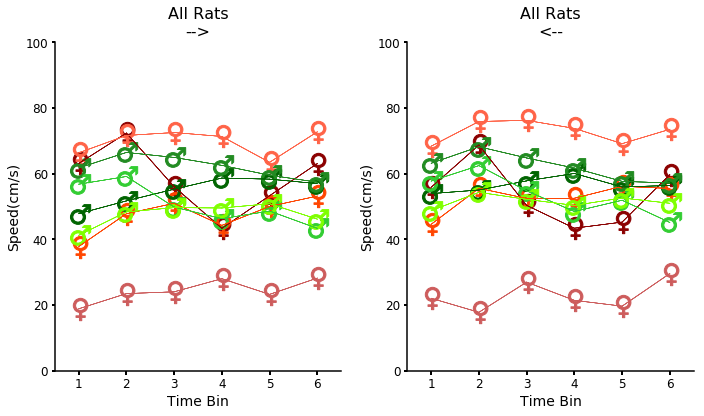

/home/david/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/david/.local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


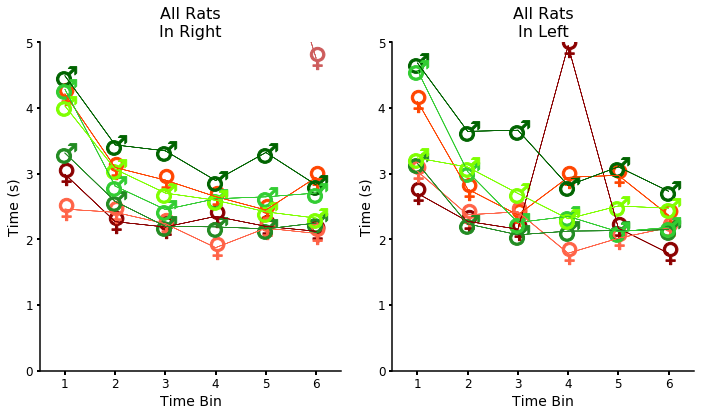

In [45]:
#SR BR
plt.figure(figsize = [10, 6])
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
           
            plot_runs2(good_speedRunToRightBin[animal, session], good_speedRunToLeftBin[animal, session], bad_speedRunToRightBin[animal, session], bad_speedRunToLeftBin[animal, session], barplotaxes = [0.5, 6.5, 0, 100], xyLabels=["Time Bin","Speed(cm/s)", "Time Bin", "Speed(cm/s)", "To Right", "To Left", 14, 12], title=["All Rats"+"\n"+ "-->", "All Rats"+"\n"+ "<--", "", 16], linewidth = [1.5])
plt.show()  

plt.figure(figsize = [10, 6])
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            plot_runs2(good_timeStayInRightBin[animal, session], good_timeStayInLeftBin[animal, session], bad_timeStayInRightBin[animal, session], bad_timeStayInLeftBin[animal, session], barplotaxes = [0.5, 6.5, 0, 5], xyLabels=["Time Bin","Time (s)", "Time Bin", "Time (s)", "To Right", "To Left", 14, 12], title=["All Rats"+"\n"+ "In Right", "All Rats"+"\n"+ "In Left", "", 16], linewidth = [1.5])

plt.show()

In [46]:
def plot_runs3(gooddataRight, gooddataLeft, baddataRight, baddataLeft, barplotaxes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1):

    for i in range(0, timeBins):
        ax2 = plt.gca()
        plt.scatter(np.full((1, 1), i+1), np.mean(gooddataRight[i]), s=25, color = 'c', label = "Right" if i == 0 else "")
        plt.scatter(np.full((1, 1), i+1), np.mean(gooddataLeft[i]), s=25, color = 'b', label = "Left" if i == 0 else "")
        for i in range(0, timeBins-1):
            plt.plot(([i+1], [i+2]), (np.mean(gooddataRight[i]), np.mean(gooddataRight[i+1])), color = 'c', linewidth = 0.5)
        for i in range(0, timeBins-1):
            plt.plot(([i+1], [i+2]), (np.mean(gooddataLeft[i]), np.mean(gooddataLeft[i+1])), color = 'b', linewidth = 0.5)
        
        plt.scatter(np.full((1, 1), i+1), np.mean(gooddataRight[i] + baddataRight[i]), s=25, color = 'c', label = "Right" if i == 0 else "", alpha = 0.1)
        plt.scatter(np.full((1, 1), i+1), np.mean(gooddataLeft[i] + baddataLeft[i]), s=25, color = 'b', label = "Left" if i == 0 else "", alpha = 0.1)
        for i in range(0, timeBins-1):
            plt.plot(([i+1], [i+2]), (np.mean(gooddataRight[i] + baddataRight[i]), np.mean(gooddataRight[i+1] + baddataRight[i+1])), color = 'c', linewidth = 0.5, alpha = 0.1)
        for i in range(0, timeBins-1):
            plt.plot(([i+1], [i+2]), (np.mean(gooddataLeft[i] + baddataLeft[i]), np.mean(gooddataLeft[i+1] + baddataLeft[i+1])), color = 'b', linewidth = 0.5, alpha = 0.1)

        ax2.set_title(title[0], fontsize = title[3])
        ax2.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
        ax2.set_ylabel(xyLabels[1], fontsize = xyLabels[6])
        ax2.set_xlim([barplotaxes[0], barplotaxes[1]])
        ax2.set_ylim([barplotaxes[2], barplotaxes[3]])
        ax2.spines['bottom'].set_linewidth(linewidth[0])
        ax2.spines['left'].set_linewidth(linewidth[0])
        ax2.spines['top'].set_color("none")
        ax2.spines['right'].set_color("none")
        ax2.tick_params(width=2, labelsize = xyLabels[7])
        plt.legend()
        
    plt.tight_layout(pad=0.5)
    return plt

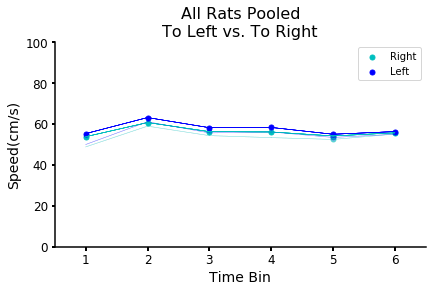

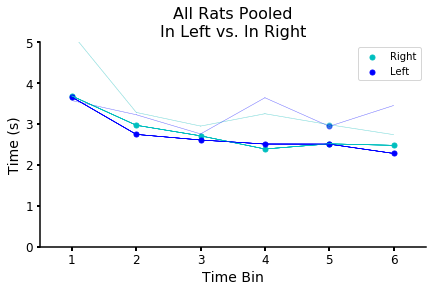

In [47]:
#add alpha in params to merge the graphs with the bad runs 
plot_runs3(good_speedRunToRightPooledBin, good_speedRunToLeftPooledBin, bad_speedRunToRightPooledBin, bad_speedRunToLeftPooledBin, barplotaxes = [0.5, 6.5, 0, 100], xyLabels=["Time Bin","Speed(cm/s)", "Time Bin", "Speed(cm/s)", "", "", 14, 12], title=["All Rats Pooled"+"\n"+ "To Left vs. To Right", "All Rats Pooled"+"\n"+ "In Left vs. In Right", "", 16], linewidth = [1.5])
plt.show()
plot_runs3(good_timeStayInRightPooledBin, good_timeStayInLeftPooledBin, bad_timeStayInRightPooledBin, bad_timeStayInLeftPooledBin, barplotaxes = [0.5, 6.5, 0, 5], xyLabels=["Time Bin","Time (s)", "Time Bin", "Speed(cm/s)", "", "", 14, 12], title=["All Rats Pooled"+"\n"+ "In Left vs. In Right", "All Rats Pooled"+"\n"+ "In Left vs. In Right", "", 16], linewidth = [1.5])
plt.show()

# Number of runs per 5 min 

In [48]:
nb_trials_to_right = {}
nb_trials_to_left = {}
nb_trials = {}

for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList:
        nb_trials_to_right[animal, session] = {}
        nb_trials_to_left[animal, session] = {}  
        nb_trials[animal, session] = {}  
        for i in range (0, timeBins):
            nb_trials_to_right[animal, session][i] = []
            nb_trials_to_left[animal, session][i] = []
            nb_trials[animal, session][i] = []

            nb_trials_to_right[animal, session][i] = len(good_speedRunToRightBin[animal, session][i])
            nb_trials_to_left[animal, session][i] = len(good_speedRunToLeftBin[animal, session][i])
            nb_trials[animal, session][i] = len(good_speedRunToRightBin[animal, session][i]) + len(good_speedRunToLeftBin[animal, session][i])
            #print(animal, i,  "ToRight", len(good_speedToRightBin[animal, session][i]), "ToLeft", len(good_speedToLeftBin[animal, session][i]))
        #print()

poolR = {}
poolL = {}
pool = {}
for i in range(0, timeBins):
    poolR[i] = []
    poolL[i] = []
    pool[i] = []
    for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            poolR[i].append(nb_trials_to_right[animal, session][i])
            poolL[i].append(nb_trials_to_left[animal, session][i])
            pool[i].append(nb_trials_to_right[animal, session][i]+nb_trials_to_left[animal, session][i])

In [49]:
def plot_runs4(gooddataRight, gooddataLeft, baddataRight, baddataLeft, barplotaxes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1):

    for i in range(0, timeBins):
        ax2 = plt.gca()
        plt.scatter(np.full((1, 1), i+1), gooddataRight[animal, session][i], s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0],label = animal if i == 0 else "")
        plt.scatter(np.full((1, 1), i+1), gooddataLeft[animal, session][i], s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        for i in range(0, timeBins-1):
            plt.plot(([i+1], [i+2]), (gooddataRight[animal, session][i], gooddataRight[animal, session][i+1]), color = rat_markers[animal][0], linewidth = 1, linestyle = '-.')
        for i in range(0, timeBins-1):
            plt.plot(([i+1], [i+2]), (gooddataLeft[animal, session][i], gooddataLeft[animal, session][i+1]), color = rat_markers[animal][0], linewidth = 1)

        ax2.set_title(title[0], fontsize = title[3])
        ax2.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
        ax2.set_ylabel(xyLabels[1], fontsize = xyLabels[6])
        ax2.set_xlim([barplotaxes[0], barplotaxes[1]])
        ax2.set_ylim([barplotaxes[2], barplotaxes[3]])
        ax2.spines['bottom'].set_linewidth(linewidth[0])
        ax2.spines['left'].set_linewidth(linewidth[0])
        ax2.spines['top'].set_color("none")
        ax2.spines['right'].set_color("none")
        ax2.tick_params(width=2, labelsize = xyLabels[7])
        plt.legend()

    plt.tight_layout(pad=0.5)
    return plt


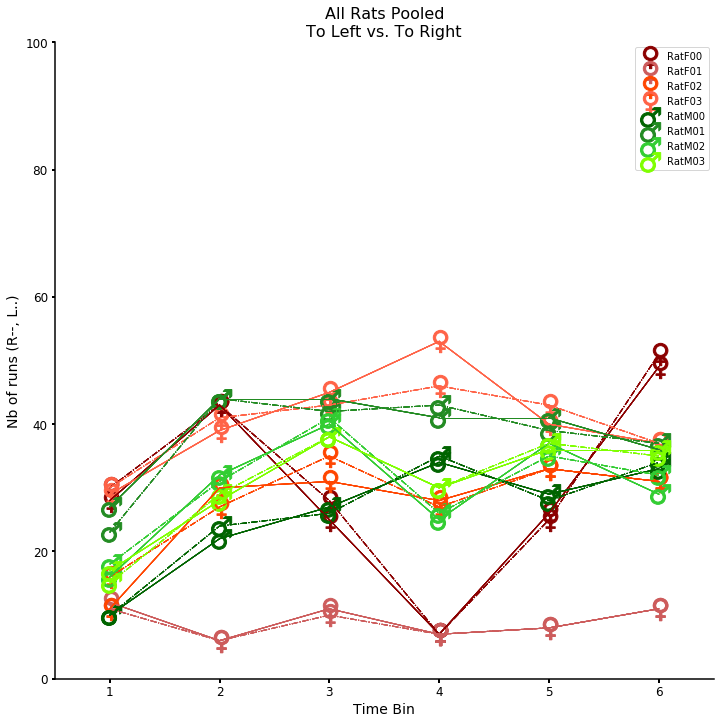

In [50]:
plt.figure(figsize = [10, 10])
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            plot_runs4(nb_trials_to_right, nb_trials_to_left, [], [], barplotaxes = [0.5, 6.5, 0, 100], xyLabels=["Time Bin","Nb of runs (R--, L..)", "Time Bin", "Speed(cm/s)", "", "", 14, 12], title=["All Rats Pooled"+"\n"+ "To Left vs. To Right", "All Rats Pooled"+"\n"+ "In Left vs. In Right", "", 16], linewidth = [1.5])
plt.show()

In [51]:
def plot_runs5(gooddataRight, gooddataLeft, baddataRight, baddataLeft, barplotaxes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1):
    for i in range(0, timeBins):

        ax2 = plt.gca()
        plt.scatter(np.full((1, 1), i+1), gooddataRight[animal, session][i], s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0],label = animal if i == 0 else "")
        plt.scatter(np.full((1, 1), i+1), np.mean(gooddataLeft[i]), s=100, color = 'k', label = "Average" if i == 0 and animal == "RatM03" else "")
        for i in range(0, timeBins-1):
            plt.plot(([i+1], [i+2]), (gooddataRight[animal, session][i], gooddataRight[animal, session][i+1]), color = rat_markers[animal][0], linewidth = 1)
            plt.plot(([i+1], [i+2]), (np.mean(gooddataLeft[i]), np.mean(gooddataLeft[i+1])), color = 'k', linewidth = 1)
        
        ax2.set_title(title[0], fontsize = title[3])
        ax2.set_xlabel(xyLabels[0], fontsize = xyLabels[6])
        ax2.set_ylabel(xyLabels[1], fontsize = xyLabels[6])
        ax2.set_xlim([barplotaxes[0], barplotaxes[1]])
        ax2.set_ylim([barplotaxes[2], barplotaxes[3]])
        ax2.spines['bottom'].set_linewidth(linewidth[0])
        ax2.spines['left'].set_linewidth(linewidth[0])
        ax2.spines['top'].set_color("none")
        ax2.spines['right'].set_color("none")
        ax2.tick_params(width=2, labelsize = xyLabels[7])
        #plt.legend()

    plt.tight_layout(pad=0.5)
    return plt

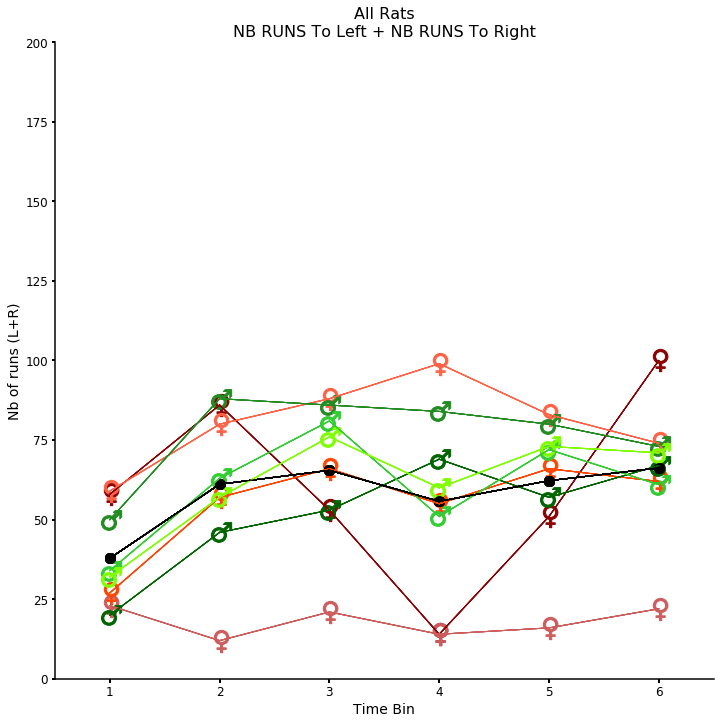

In [52]:
plt.figure(figsize = [10, 10])
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            plot_runs5(nb_trials, pool, [], [], barplotaxes = [0.5, 6.5, 0, 200], xyLabels=["Time Bin","Nb of runs (L+R)", "Time Bin", "nb of trials left + right", "", "", 14, 12], title=["All Rats"+"\n"+ "NB RUNS To Left + NB RUNS To Right", "All Rats"+"\n"+ "In Left vs. In Right", "", 16], linewidth = [1.5])
plt.show()

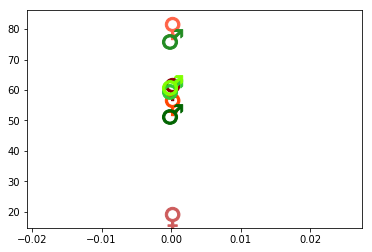

In [53]:
#not ordered in dict
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        i = 0
        for session in sessionList: 
            ax2 = plt.gca()
            plt.scatter(i, np.mean(list(nb_trials[animal, session].values())), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0],label = animal if i == 0 else "")
            i+=1
            #print(session, (np.mean(list(nb_trials[animal, session].values()))))
        print()

# test donut

In [54]:
plt.figure(figsize = [20, 5])
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList: 
        plt.figure(figsize = [30, 5])
        print(animal, session)
        #plt.plot(rawPositionX[animal, session],rawPositionY[animal, session],[0,1400,1],[0,150,1], linewidth=0.1)
        #plt.plot([None if x == 0 else x for x in rawLickLeft1X[animal, session]],rawPositionY[animal, session],[0,1400,1],[0,150,1], linewidth=0.1, marker='o', markersize=0.1)
        #plt.plot([None if x == 0 else x for x in rawLickRight1X[animal, session]],rawPositionY[animal, session],[0,1400,1],[0,150,1], linewidth=0.1, marker='o', markersize=0.1)

RatF00 RatF00_2020_07_22_13_17_25
RatF01 RatF01_2020_07_22_13_49_33
RatF02 RatF02_2020_07_22_14_36_11
RatF03 RatF03_2020_07_22_15_07_14
RatM00 RatM00_2020_07_22_15_38_49
RatM01 RatM01_2020_07_22_16_09_59
RatM02 RatM02_2020_07_22_16_41_19
RatM03 RatM03_2020_07_22_17_12_34


<Figure size 1440x360 with 0 Axes>

<Figure size 2160x360 with 0 Axes>

<Figure size 2160x360 with 0 Axes>

<Figure size 2160x360 with 0 Axes>

<Figure size 2160x360 with 0 Axes>

<Figure size 2160x360 with 0 Axes>

<Figure size 2160x360 with 0 Axes>

<Figure size 2160x360 with 0 Axes>

<Figure size 2160x360 with 0 Axes>

# weight

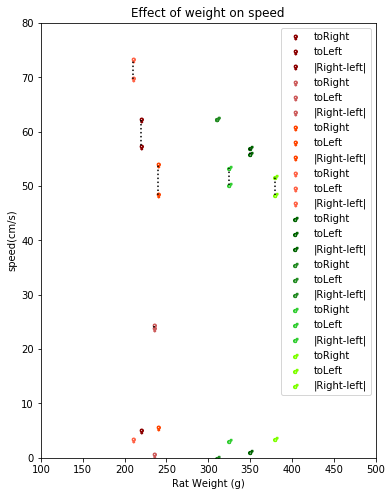

In [55]:
plt.figure(figsize = [6, 8])
for animal in animalList:
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            
            xline = [params[animal, session]["weight"], params[animal, session]["weight"]]
            yline = [np.mean(good_speedRunToRight[animal, session]),np.mean(good_speedRunToLeft[animal, session])]
            
            plt.xlabel('Rat Weight (g)')
            plt.ylabel('speed(cm/s)')
            plt.title('Effect of weight on speed')

            plt.scatter(params[animal, session]["weight"], np.mean(good_speedRunToRight[animal, session]), s=25, color =rat_markers[animal][0], marker=rat_markers[animal][1], label = "toRight")
            plt.scatter(params[animal, session]["weight"], np.mean(good_speedRunToLeft[animal, session]), s=25, color =rat_markers[animal][0], marker=rat_markers[animal][1], label = "toLeft")
            plt.scatter(params[animal, session]["weight"], abs(np.mean(good_speedRunToRight[animal, session]) - np.mean(good_speedRunToLeft[animal, session])), s=25, color =rat_markers[animal][0], marker=rat_markers[animal][1], label = "|Right-left|")
            plt.plot(xline, yline, ":", color='k')
            plt.axis([100, 500, 0, 80 ])
            plt.legend()

# Bin POs

In [56]:
for animal in animalList: 
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList: 
        plt.figure(figsize = [20, 5])
        print(animal, session)
        for i in range(2,4):
            #plot_BASEtrajectory(binTime[animal, session][i],binPositionX[animal, session][i], np.zeros(len(binPositionX[animal, session][i])), np.zeros(len(binPositionX[animal, session][i])), [0,1800,1],[0,1400,1],  color = ["b", "c"], marker = ["", "o", 1], linewidth = [0.5], xyLabels=["Position (cm)", "Time(s)"])
            plt.show();

RatF00 RatF00_2020_07_22_13_17_25


<Figure size 1440x360 with 0 Axes>

RatF01 RatF01_2020_07_22_13_49_33


<Figure size 1440x360 with 0 Axes>

RatF02 RatF02_2020_07_22_14_36_11


<Figure size 1440x360 with 0 Axes>

RatF03 RatF03_2020_07_22_15_07_14


<Figure size 1440x360 with 0 Axes>

RatM00 RatM00_2020_07_22_15_38_49


<Figure size 1440x360 with 0 Axes>

RatM01 RatM01_2020_07_22_16_09_59


<Figure size 1440x360 with 0 Axes>

RatM02 RatM02_2020_07_22_16_41_19


<Figure size 1440x360 with 0 Axes>

RatM03 RatM03_2020_07_22_17_12_34


<Figure size 1440x360 with 0 Axes>

# bug time

In [57]:
a = np.diff(rawTime[animal, session])
def movinavg(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

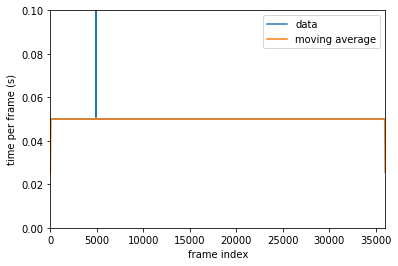

In [58]:
plt.plot(a, label = "data")
plt.plot(movinavg(a, 100), label="moving average")

plt.xlim(0, len(a))
plt.ylim(0, 0.1)
plt.xlabel("frame index")
plt.ylabel("time per frame (s)")
plt.legend()

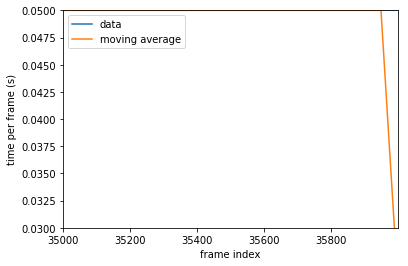

In [59]:
plt.plot(a, label = "data")
plt.plot(movinavg(a, 100), label="moving average")

plt.xlim(35000, len(a))
plt.ylim(0.03, 0.05)
plt.xlabel("frame index")
plt.ylabel("time per frame (s)")
plt.legend()

# test instant speed

In [60]:
def extract_runsRightLeftFiltered(data, animal, session, boundary, limspeed=None):
    rawdata_run = {}
    rawdata_stay = {}
    good_speedRight_cms = []
    good_speedLeft_cms = []
    good_x_trackR = []
    good_x_trackL = []

    bad_speedRight_cms = []
    bad_speedLeft_cms = []
    bad_x_trackR = []
    bad_x_trackL = []
    all_speedRight_cms = [] 
    all_speedLeft_cms = []


    good_timeInRight = []
    good_timeInLeft = []
    good_x_stayR = []
    good_x_stayL = []

    bad_timeInRight = []
    bad_timeInLeft = []
    bad_x_stayR = []
    bad_x_stayL = []
    all_timeInRight = []
    all_timeInLeft = []
    testR = []
    testL = []
    good_testR = []
    bad_testR = []
    good_testL = []
    bad_testL = []

    


    #crop the complete track at the set boundaries -> keep only the runs and set the rest to 0
    rawdata_run[animal, session] = [e/13.5 if e <= boundary[0]+50 and e>= boundary[1]-50 else 0 for e in data[animal, session]] #conversion pixel to cm maybe do this better 
    # use the split a list function to create a new sublist when there is a 0, which we just set up before
    for subsplit in split_a_list_at_zeros(rawdata_run[animal, session]):
        #check if the subsplit starts on the left or the right -> determine if the animal is running left or right
        if subsplit[0] < (((boundary[0]+boundary[1])/2) /13.5):
            #check if the subsplit is ending on the other side -> determine if this is a run 
            if subsplit[-1] > (((boundary[0]+boundary[1])/2) /13.5):
                #calculate distance run as the distance between first and last value
                distRight_cm = abs(subsplit[0]-subsplit[-1]) 
                #calculate time as number of values (frames) * time per frame
                timeRight = len(subsplit) * 0.04
                #check if there is a limspeed : if no compute all the runs -> used to compute limspeed
                #second pass : there is a computed limspeed, use it to sort good and bad runs
                if limspeed[0] is not None:
                    #check if this is a good or bad run and assign im to the good or bad array accordingly
                    if distRight_cm/timeRight > limspeed[0][0]:
                        #good run array
                        good_speedRight_cms.append(distRight_cm/timeRight)
                        good_x_trackR.append(subsplit)
                        good_testR.append(np.diff(subsplit))     
                    else:
                        #bad run array
                        bad_speedRight_cms.append(distRight_cm/timeRight)
                        bad_x_trackR.append(subsplit)
                        bad_testR.append(np.diff(subsplit))

                else:
                    #all runs array first pass
                    all_speedRight_cms.append(distRight_cm/timeRight)
                    testR.append(np.diff(subsplit))


        #same thing for the runs that go to the other side
        elif subsplit[0]>(((boundary[0]+boundary[1])/2)/13.5):
            if subsplit[-1]<(((boundary[0]+boundary[1])/2)/13.5):
                distLeft_cm = abs(subsplit[0]-subsplit[-1])
                timeLeft = len(subsplit) * 0.04
                if limspeed[1] is not None:
                    if distLeft_cm/timeLeft < limspeed[1][0]:
                        good_speedLeft_cms.append(distLeft_cm/timeLeft)   
                        good_x_trackL.append(np.diff(subsplit))
                        good_testL.append(np.diff(subsplit))  
                    else:
                        bad_speedLeft_cms.append(distLeft_cm/timeLeft)
                        bad_x_trackL.append(np.diff(subsplit))
                        bad_testL.append(np.diff(subsplit))
                else:
                    all_speedLeft_cms.append(distLeft_cm/timeLeft)
                    testL.append(np.diff(subsplit))

    # inverse crop, at the boundaries keep the distal parts, same process as above
    rawdata_stay[animal, session] = [e/13.5 if e >= boundary[0] or e<= boundary[1] else 0 for e in data[animal, session]]
    for subsplit in split_a_list_at_zeros(rawdata_stay[animal, session]):
        #first identify if the subsplit created is on the left or right by comparing to the middle
        if subsplit[0] > (((boundary[0]+boundary[1])/2) /13.5):
            # maybe add another filter i.e. out if less than 5 frames
            #same idea as above
            if limspeed[0] is not None:
                #add lenght (frames) of the subsplit * time per frame
                if len(subsplit)* 0.04 < limspeed[0][0]:#rand just to work check that when done seriously
                    good_timeInRight.append(len(subsplit)* 0.04)#clean 
                    good_x_stayR.append(subsplit)
                else:
                    bad_timeInRight.append(len(subsplit)* 0.04)
                    bad_x_stayR.append(subsplit)
            else:
                all_timeInRight.append(len(subsplit)* 0.04)
                
        elif subsplit[0]<(((boundary[0]+boundary[1])/2)/13.5):
            #compute
            if limspeed[1] is not None:
                if len(subsplit)* 0.04 < limspeed[1][0]:
                    good_timeInLeft.append(len(subsplit)* 0.04)   
                    good_x_stayL.append(subsplit)
                else:
                    bad_timeInLeft.append(len(subsplit)* 0.04)
                    bad_x_stayL.append(subsplit)
            else:
                all_timeInLeft.append(len(subsplit)* 0.04)
   
    return good_speedRight_cms, good_speedLeft_cms, good_x_trackR, good_x_trackL, bad_speedRight_cms, bad_speedLeft_cms, bad_x_trackR, bad_x_trackL, all_speedRight_cms, all_speedLeft_cms, good_timeInRight, good_timeInLeft, good_x_stayR, good_x_stayL, bad_timeInRight, bad_timeInLeft, bad_x_stayR, bad_x_stayL, all_timeInRight, all_timeInLeft, testR, testL, good_testR, bad_testR, good_testL, bad_testL

In [61]:

testRight = {}
testLeft = {}
goodRight = {}
badRight = {}
goodLeft = {}
badLeft = {}
for animal in animalList: 
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
        for session in sessionList:
            #extract all the runs to compute limspeed

            testRight[animal, session]= extract_runsRightLeftFiltered(rawPositionX, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [None, None])[20]
            testLeft[animal, session] = extract_runsRightLeftFiltered(rawPositionX, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [None, None])[21]
            goodRight[animal, session] = extract_runsRightLeftFiltered(rawPositionX, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limspeedRunToRight[animal, session], limspeedRunToLeft[animal, session]])[22]
            badRight[animal, session] = extract_runsRightLeftFiltered(rawPositionX, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limspeedRunToRight[animal, session], limspeedRunToLeft[animal, session]])[23]
            goodLeft[animal, session] = extract_runsRightLeftFiltered(rawPositionX, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limspeedRunToRight[animal, session], limspeedRunToLeft[animal, session]])[24]
            badLeft[animal, session] = extract_runsRightLeftFiltered(rawPositionX, animal, session, boundary = params[animal, session]["boundaries"], limspeed = [limspeedRunToRight[animal, session], limspeedRunToLeft[animal, session]])[25]

            print(animal, "done")

RatF00 done
RatF01 done
RatF02 done
RatF03 done
RatM00 done
RatM01 done
RatM02 done
RatM03 done


(-10, 10)

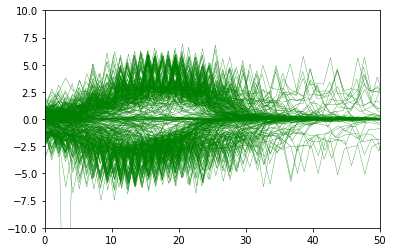

In [62]:

for i in testRight[animal, session]:
    plt.plot(np.linspace(0, len(i), len(i)), i, color='g' , linewidth=0.3)
for i in testLeft[animal, session]:
    plt.plot(np.linspace(0, len(i), len(i)), i, color='g' , linewidth=0.3)
plt.xlim(0, 50)
plt.ylim(-10, 10)

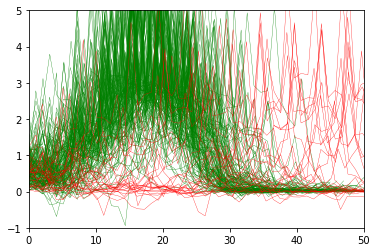

In [63]:
for i in goodRight[animal, session]:
    plt.plot(np.linspace(0, len(i), len(i)), i, color='g' , linewidth=0.3)
for i in badRight[animal, session]:
    plt.plot(np.linspace(0, len(i), len(i)), i, color='r' , linewidth=0.3)
plt.xlim(0, 50)
plt.ylim(-1, 5);

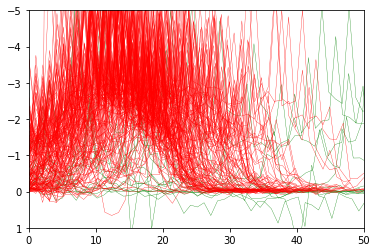

In [64]:
for i in goodLeft[animal, session]:
    plt.plot(np.linspace(0, len(i), len(i)), i, color='g' , linewidth=0.3)
for i in badLeft[animal, session]:
    plt.plot(np.linspace(0, len(i), len(i)), i, color='r' , linewidth=0.3)
plt.xlim(0, 50)
plt.ylim(1, -5);

In [65]:
# test speed = accelleration


In [66]:
testR = []
testL = []
testRb = []
testLb = []
#testR[animal, session] = np.diff(good_XtrackRunToRight[animal, session])
for i in good_XtrackRunToRight[animal, session]:
    testR.append(np.diff(i))
for j in good_XtrackRunToLeft[animal, session]:
    testL.append(np.diff(j))
for k in bad_XtrackRunToRight[animal, session]:
    testRb.append(np.diff(k))
for l in bad_XtrackRunToLeft[animal, session]:
    testLb.append(np.diff(l))

(-5, 5)

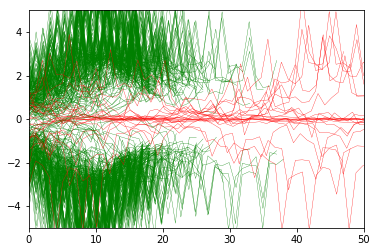

In [67]:
for i in testR:
    plt.plot(np.linspace(0, len(i), len(i)), i, color='g' , linewidth=0.3)
for i in testL:
    plt.plot(np.linspace(0, len(i), len(i)), i, color='g' , linewidth=0.3)
for i in testRb:
    plt.plot(np.linspace(0, len(i), len(i)), i, color='r' , linewidth=0.3)
for i in testLb:
    plt.plot(np.linspace(0, len(i), len(i)), i, color='r' , linewidth=0.3)
plt.xlim(0, 50)
plt.ylim(-5, 5)

(-1, 5)

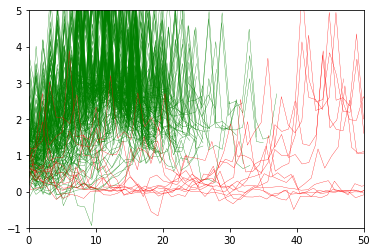

In [68]:
for i in testR:
    plt.plot(np.linspace(0, len(i), len(i)), i, color='g' , linewidth=0.3)

for i in testRb:
    plt.plot(np.linspace(0, len(i), len(i)), i, color='r' , linewidth=0.3)
plt.xlim(0, 50)
plt.ylim(-1, 5)

(1, -5)

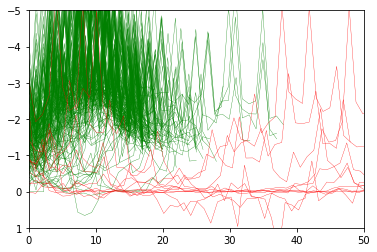

In [69]:

for i in testL:
    plt.plot(np.linspace(0, len(i), len(i)), i, color='g' , linewidth=0.3)

for i in testLb:
    plt.plot(np.linspace(0, len(i), len(i)), i, color='r' , linewidth=0.3)
plt.xlim(0, 50)
plt.ylim(1, -5)

# TODOLIST


In [70]:
###TODO###
#convert position to cm cleaner
#comments
#explain how data is processed
#explore weight effect and evolution /speed /peakspeed /number of runs
#do something with number of runs
#look for instant speed inside the identified runs --> see if both methods give the same result
#look for peak speed
#!!!!!!!evolution of speed in the session
#smooth position ?
#runs +extremities on one plot
#generate html/pdf recap+stats
#pickle useful data
#compare between days
#lickdata
#lick data --> waiting time
#add stats on figs
#noise videotrack / improve videotrack
#Investigate change in speed during a single session (hypothese [case reward size is the same for leftward or rightward trials] : speed should go down ?; [case reward size is diffrent for leftward and rightward trials]: does speed slow down more quickly for left or right runs ?
#test median
#BIG/small on figs
#problem with time............
#average track per animal/group 
#specify analysis groups for stats
#analyse training data
#analyse /2 data
#clean graphes for talk 
#stats timeBins
#spread in scatter plot proportional to density
#fix time bins
#scatterplot xes not used in distrib, maxminstep bin not used in scatter plot when plotting runs

##DONE##
#######see git log for DONE

In [71]:
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList: 
        print([animal, session])

['RatF00', 'RatF00_2020_07_22_13_17_25']
['RatF01', 'RatF01_2020_07_22_13_49_33']
['RatF02', 'RatF02_2020_07_22_14_36_11']
['RatF03', 'RatF03_2020_07_22_15_07_14']
['RatM00', 'RatM00_2020_07_22_15_38_49']
['RatM01', 'RatM01_2020_07_22_16_09_59']
['RatM02', 'RatM02_2020_07_22_16_41_19']
['RatM03', 'RatM03_2020_07_22_17_12_34']


In [72]:
for animal in animalList:
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+os.sep+animal+os.sep+"Experiments"+os.sep+"Rat*")]
    for session in sessionList: 
        print("['" +animal+ "\',\'" +session + "\']")

['RatF00','RatF00_2020_07_22_13_17_25']
['RatF01','RatF01_2020_07_22_13_49_33']
['RatF02','RatF02_2020_07_22_14_36_11']
['RatF03','RatF03_2020_07_22_15_07_14']
['RatM00','RatM00_2020_07_22_15_38_49']
['RatM01','RatM01_2020_07_22_16_09_59']
['RatM02','RatM02_2020_07_22_16_41_19']
['RatM03','RatM03_2020_07_22_17_12_34']


In [73]:
sessionList60cm = [
['RatF00','RatF00_2020_08_30_14_01_32'], ['RatF00','RatF00_2020_08_26_12_37_41'],
['RatF01','RatF01_2020_08_26_13_19_04'], ['RatF01','RatF01_2020_08_30_14_33_21'],
['RatF02','RatF02_2020_08_30_15_11_56'], ['RatF02','RatF02_2020_08_26_13_54_39'],
['RatF03','RatF03_2020_08_26_14_25_56'], ['RatF03','RatF03_2020_08_30_15_43_21'],
['RatM00','RatM00_2020_08_29_15_30_16'], ['RatM00','RatM00_2020_08_27_14_51_35'],
['RatM01','RatM01_2020_08_29_16_02_14'],
['RatM02','RatM02_2020_08_27_16_07_40'], ['RatM02','RatM02_2020_08_29_17_01_08'],
['RatM03','RatM03_2020_08_29_17_33_03'], ['RatM03','RatM03_2020_08_27_16_39_19']]

sessionList90cm = [
['RatF00','RatF00_2020_08_25_12_30_23'],
['RatF01','RatF01_2020_08_25_13_01_41'],
['RatF02','RatF02_2020_08_25_13_33_24'],
['RatF03','RatF03_2020_08_25_14_04_38'],
['RatM00','RatM00_2020_08_25_14_42_40'],
['RatM01','RatM01_2020_08_25_15_16_13'],
['RatM02','RatM02_2020_08_25_15_47_30'],
['RatM03','RatM03_2020_08_25_16_19_00'],]

sessionList120cm = [
['RatF00','RatF00_2020_08_29_13_12_25'], ['RatF00','RatF00_2020_08_27_12_28_15'],
['RatF01','RatF01_2020_08_27_13_04_29'], ['RatF01','RatF01_2020_08_29_13_44_02'],
['RatF02','RatF02_2020_08_29_14_19_56'], ['RatF02','RatF02_2020_08_27_13_35_41'],
['RatF03','RatF03_2020_08_27_14_07_57'], ['RatF03','RatF03_2020_08_29_14_51_53'],
['RatM00','RatM00_2020_08_30_16_23_05'], ['RatM00','RatM00_2020_08_26_15_12_46'],
['RatM01','RatM01_2020_08_30_16_54_32'], ['RatM01','RatM01_2020_08_26_15_44_08'],
['RatM02','RatM02_2020_08_30_17_25_55'], ['RatM02','RatM02_2020_08_26_16_25_57'],
['RatM03','RatM03_2020_08_26_16_57_27'], ['RatM03','RatM03_2020_08_30_17_57_40']]

KeyError: ('RatF00', 'RatF00_2020_08_30_14_01_32')

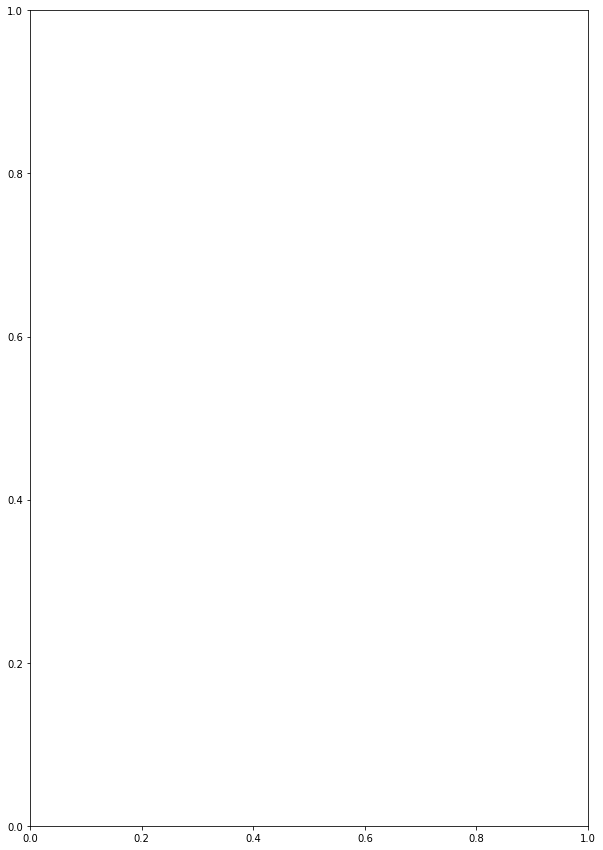

In [74]:
def plot_recapfigDistance(animal, session, gooddataRight, gooddataLeft, baddataRight, baddataLeft, axes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1): 
    avg1R, avg1L, avg2R, avg2L, avg3R, avg3L = [], [], [], [], [], []
    for animal, session in sessionList60cm:
        ax3 = plt.gca()
        plt.scatter(1, np.mean(gooddataRight[animal, session]), s=50, color =rat_markers[animal][0], marker=rat_markers[animal][1])
        plt.scatter(2, np.mean(gooddataLeft[animal, session]), s=50, color =rat_markers[animal][0], marker=rat_markers[animal][1])
        plt.plot((1, 2), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), color = rat_markers[animal][0], linewidth = 1, linestyle = ':')
    avg1R.append(gooddataRight[animal, session])       
    avg1L.append(gooddataLeft[animal, session])  
    plt.scatter(0.95, np.mean(avg1R), s=40, color ='k')
    plt.scatter(2.05, np.mean(avg1L), s=40, color ='k')
    plt.plot((0.95, 2.05), (np.mean(avg1R), np.mean(avg1L)), color='k', linewidth = 1, linestyle = ':')

    for animal, session in sessionList120cm:
        ax3 = plt.gca()
        plt.scatter(1, np.mean(gooddataRight[animal, session]), s=50, color =rat_markers[animal][0], marker=rat_markers[animal][1])
        plt.scatter(2, np.mean(gooddataLeft[animal, session]), s=50, color =rat_markers[animal][0], marker=rat_markers[animal][1])
        plt.plot((1, 2), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), color = rat_markers[animal][0], linewidth = 4, linestyle = '--')
    avg2R.append(gooddataRight[animal, session])       
    avg2L.append(gooddataLeft[animal, session])  
    plt.scatter(0.95, np.mean(avg2R), s=40, color ='k')
    plt.scatter(2.05, np.mean(avg2L), s=40, color ='k')
    plt.plot((0.95, 2.05), (np.mean(avg2R), np.mean(avg2L)), color='k', linewidth = 4, linestyle = '--')


    for animal, session in sessionList90cm:
        ax3 = plt.gca()
        plt.scatter(1, np.mean(gooddataRight[animal, session]), s=50, color =rat_markers[animal][0], marker=rat_markers[animal][1])
        plt.scatter(2, np.mean(gooddataLeft[animal, session]), s=50, color =rat_markers[animal][0], marker=rat_markers[animal][1])
        plt.plot((1, 2), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), color = rat_markers[animal][0], linewidth = 2.5, linestyle = '-.')
    avg3R.append(gooddataRight[animal, session])       
    avg3L.append(gooddataLeft[animal, session])  
    plt.scatter(0.95, np.mean(avg3R), s=40, color ='k')
    plt.scatter(2.05, np.mean(avg3L), s=40, color ='k')
    plt.plot((0.95, 2.05), (np.mean(avg3R), np.mean(avg3L)), color='k', linewidth = 2.5, linestyle = '-.')



    ax3.set_xlabel(xyLabels[2], fontsize = xyLabels[4])
    ax3.set_ylabel(xyLabels[3], fontsize = xyLabels[4])
    ax3.set_title(title[0], fontsize = title[1])
    ax3.set_xlim([axes[0], axes[1]])
    ax3.set_ylim([axes[2], axes[3]])
    ax3.set_xticks([1,2])
    ax3.set_xticklabels([xyLabels[0],xyLabels[1]], fontsize = xyLabels[4])
    ax3.spines['bottom'].set_linewidth(linewidth[0])
    ax3.spines['left'].set_linewidth(linewidth[0])
    ax3.spines['top'].set_color("none")
    ax3.spines['right'].set_color("none")
    ax3.tick_params(width=2, labelsize = xyLabels[5])
    #plt.legend()


fig = plt.figure(constrained_layout = False, figsize=(10, 15))
plot_recapfigDistance(animal, session, good_speedRunToRight, good_speedRunToLeft, [], [], axes = [0.7, 2.3, 30, 90], xyLabels=["To Right" + "\n" + "To " + water[animal, session][1] + " " + str(params[animal, session]["waterRight"]) + "µL/drop", "To Left" + "\n" + "To " + water[animal, session][0] + " " + str(params[animal, session]["waterLeft"]) + "µL/drop", "Direction", "Speed (cm/s)", 14, 12], title=["Recap runs", 16], linewidth = [1.5])

In [ ]:
def plot_recapfigDistance(animal, session, gooddataRight, gooddataLeft, baddataRight, baddataLeft, axes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1): 
    avg1R, avg1L, avg2R, avg2L, avg3R, avg3L = [], [], [], [], [], []
    for animal, session in sessionList60cm:
        ax3 = plt.gca()
        plt.scatter(1, np.mean(gooddataRight[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.scatter(2, np.mean(gooddataLeft[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.plot((1, 2), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), marker=rat_markers[animal][1], color = rat_markers[animal][0], linewidth = 2)#, linestyle = ':')
        avg1R.extend(gooddataRight[animal, session])       
        avg1L.extend(gooddataLeft[animal, session])
    plt.scatter(1, np.mean(avg1R), s=40, color ='k')
    plt.scatter(2, np.mean(avg1L), s=40, color ='k')
    plt.plot((1, 2), (np.mean(avg1R), np.mean(avg1L)), color='k', linewidth = 2)#= 1, linestyle = ':')

    for animal, session in sessionList120cm:
        ax3 = plt.gca()
        plt.scatter(7, np.mean(gooddataRight[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.scatter(8, np.mean(gooddataLeft[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.plot((7, 8), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), marker=rat_markers[animal][1], color = rat_markers[animal][0], linewidth = 2)#, linestyle = '--')
        avg2R.extend(gooddataRight[animal, session])       
        avg2L.extend(gooddataLeft[animal, session])  
    plt.scatter(7, np.mean(avg2R), s=40, color ='k')
    plt.scatter(8, np.mean(avg2L), s=40, color ='k')
    plt.plot((7, 8), (np.mean(avg2R), np.mean(avg2L)), color='k', linewidth = 2)#4, linestyle = '--')

    for animal, session in sessionList90cm:
        ax3 = plt.gca()
        plt.scatter(4, np.mean(gooddataRight[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.scatter(5, np.mean(gooddataLeft[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.plot((4, 5), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), marker=rat_markers[animal][1], color = rat_markers[animal][0], linewidth = 2)#, linestyle = '-.')
        avg3R.extend(gooddataRight[animal, session])       
        avg3L.extend(gooddataLeft[animal, session])  
    plt.scatter(4, np.mean(avg3R), s=40, color ='k')
    plt.scatter(5, np.mean(avg3L), s=40, color ='k')
    plt.plot((4, 5), (np.mean(avg3R), np.mean(avg3L)), color='k', linewidth = 2)#= 2.5, linestyle = '-.')

    ax3.set_xlabel(xyLabels[2], fontsize = xyLabels[4])
    ax3.set_ylabel(xyLabels[3], fontsize = xyLabels[4])
    ax3.set_title(title[0], fontsize = title[1])
    ax3.set_xlim([axes[0], axes[1]])
    ax3.set_ylim([axes[2], axes[3]])
    ax3.set_xticks([1.5, 4.5, 7.5])
    ax3.set_xticklabels([xyLabels[0],xyLabels[1], xyLabels[6]], fontsize = xyLabels[4])
    ax3.spines['bottom'].set_linewidth(linewidth[0])
    ax3.spines['left'].set_linewidth(linewidth[0])
    ax3.spines['top'].set_color("none")
    ax3.spines['right'].set_color("none")
    ax3.tick_params(width=2, labelsize = xyLabels[5])
    custom_lines = [Line2D([0], [0], color="c", lw=4, linestyle = ':'),
                    Line2D([0], [0], color="b", lw=4, linestyle = '-.'),
                    Line2D([0], [0], color="r", lw=4, linestyle = '--')]
    ax3.legend(custom_lines, ['Short 60 cm', 'Medium 90 cm', 'Long 120 cm'], bbox_to_anchor = (0., 1.02, 1., .102), ncol = 3, loc='lower left', mode="expand", borderaxespad=0., frameon = False)
    #plt.legend()

fig = plt.figure(constrained_layout = False, figsize=(15, 15))
plot_recapfigDistance(animal, session, good_speedRunToRight, good_speedRunToLeft, [], [], axes = [0, 9, 30, 90], xyLabels=["60cm", "90cm", "Treadmill Size", "Speed (cm/s)", 14, 12, "120cm"], title=["Recap runs", 16], linewidth = [1.5])

In [ ]:
fig = plt.figure(constrained_layout = False, figsize=(15, 15))
plot_recapfigDistance(animal, session, lick_waitRight, lick_waitLeft, [], [], axes = [0, 9, 0, 2], xyLabels=["60cm", "90cm", "Treadmill Size", "Speed (cm/s)", 14, 12, "120cm"], title=["Recap runs", 16], linewidth = [1.5])

In [ ]:
#add average run distance of the two sessions as well

In [ ]:
i=0
for animal, session in sessionList60cm[0:-1]:
    if sessionList60cm[i][0] == sessionList60cm[i+1][0]:
        #print(sessionList60cm[i][0], sessionList60cm[i+1][0], i)
        #print(sessionList60cm[i], sessionList60cm[i+1], i)
        both[sessionList60cm[i][0], sessionList60cm[i][1]] = (both[sessionList60cm[i][0], sessionList60cm[i][1]] + both[sessionList60cm[i+1][0], sessionList60cm[i+1][1]]) /2
        both[sessionList60cm[i+1][0], sessionList60cm[i+1][1]] = []
        #print()
    i+=1

for animal, session in sessionList60cm:
    if both[animal, session] == []:
        sessionList60cm.remove([animal, session])

In [ ]:
i=0
for animal, session in sessionList120cm[0:-1]:
    if sessionList120cm[i][0] == sessionList120cm[i+1][0]:
        #print(sessionList120cm[i][0], sessionList120cm[i+1][0], i)
        #print(sessionList120cm[i], sessionList120cm[i+1], i)
        both[sessionList120cm[i][0], sessionList120cm[i][1]] = (both[sessionList120cm[i][0], sessionList120cm[i][1]] + both[sessionList120cm[i+1][0], sessionList120cm[i+1][1]]) /2
        both[sessionList120cm[i+1][0], sessionList120cm[i+1][1]] = []
        #print()
    i+=1
    
for animal, session in sessionList120cm:
    if both[animal, session] == []:
        sessionList120cm.remove([animal, session])

In [ ]:
x, y, z = [], [], []
distS, distM, distL = [], [], []
fig = plt.figure(constrained_layout = False, figsize=(10, 10))
for animal, session in sessionList60cm:
    plt.scatter(params[animal, session]["boundaries"][0]/13.5 - params[animal, session]["boundaries"][1]/13.5, both[animal, session], marker=rat_markers[animal][1], color = rat_markers[animal][0], s=500)
    x.append(both[animal, session])
    distS.append(params[animal, session]["boundaries"][0]/13.5 - params[animal, session]["boundaries"][1]/13.5)
print()
for animal, session in sessionList120cm:
    plt.scatter(params[animal, session]["boundaries"][0]/13.5 - params[animal, session]["boundaries"][1]/13.5, both[animal, session], marker=rat_markers[animal][1], color = rat_markers[animal][0], s=500)
    z.append(both[animal, session])
    distL.append(params[animal, session]["boundaries"][0]/13.5 - params[animal, session]["boundaries"][1]/13.5)
print()
for animal, session in sessionList90cm:
    plt.scatter(params[animal, session]["boundaries"][0]/13.5 - params[animal, session]["boundaries"][1]/13.5, both[animal, session], marker=rat_markers[animal][1], color = rat_markers[animal][0], s=500)
    y.append(both[animal, session])
    distM.append(params[animal, session]["boundaries"][0]/13.5 - params[animal, session]["boundaries"][1]/13.5)
listzip = list(zip(x, y, z))
distzip = list(zip(distS, distM, distL))

for meantime, rundist, animal in zip(listzip, distzip, animalList):
    b, m = polyfit(np.array(rundist), meantime, 1)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.array(rundist), meantime)
    #print(animal, slope)
    #print(animal, r_value**2)
    plt.plot(np.array(rundist), b + m * np.array(rundist), '-', color = rat_markers[animal][0], linewidth = 2, label= animal + " r²= " +  str(round(r_value**2, 2)))

ax3 = plt.gca()
ax3.set_xlabel("Distance of Run", fontsize = 14)
ax3.set_ylabel("Time Running (s)", fontsize = 14)
ax3.set_title("Run Duration and Distance of Run", fontsize = 16)
ax3.set_xlim([16, 80])
ax3.set_ylim([0.2, 1.5])
ax3.set_xticks([round(np.mean(distS),0), round(np.mean(distM),0), round(np.mean(distL),0)])
ax3.set_xticklabels(["%s cm" %round(np.mean(distS),0),"%s cm" %round(np.mean(distM),0), "%s cm" %round(np.mean(distL),0)], fontsize = 14)
ax3.spines['bottom'].set_linewidth(1.5)
ax3.spines['left'].set_linewidth(1.5)
ax3.spines['top'].set_color("none")
ax3.spines['right'].set_color("none")
ax3.tick_params(width=2, labelsize = 12)
plt.legend()
plt.show();

In [ ]:
sessionListBigR = [
['RatF00','RatF00_2020_07_23_13_18_57'],
['RatF01','RatF01_2020_07_23_13_50_34'],
['RatF02','RatF02_2020_07_23_14_22_08'],
['RatF03','RatF03_2020_07_23_14_53_37'],
['RatM00','RatM00_2020_07_23_15_26_17'],
['RatM01','RatM01_2020_07_23_15_57_31'],
['RatM02','RatM02_2020_07_23_16_30_07'],
['RatM03','RatM03_2020_07_23_17_02_00']]

sessionListBigL = [
['RatF00','RatF00_2020_07_24_13_05_57'],
['RatF01','RatF01_2020_07_24_13_37_41'],
['RatF02','RatF02_2020_07_24_14_09_08'],
['RatF03','RatF03_2020_07_24_14_40_30'],
['RatM00','RatM00_2020_07_24_15_13_52'],
['RatM01','RatM01_2020_07_24_15_45_23'],
['RatM02','RatM02_2020_07_24_16_17_15'],
['RatM03','RatM03_2020_07_24_16_48_48']]

sessionListSame = [
['RatF00','RatF00_2020_07_25_15_27_19'],
['RatF01','RatF01_2020_07_25_15_58_46'],
['RatF02','RatF02_2020_07_25_16_30_02'],
['RatF03','RatF03_2020_07_25_17_01_48'],
['RatM00','RatM00_2020_07_25_17_40_06'],
['RatM01','RatM01_2020_07_25_18_11_18'],
['RatM02','RatM02_2020_07_25_18_42_52'],
['RatM03','RatM03_2020_07_25_19_14_30']]

In [ ]:
def plot_recapfigDistance(animal, session, gooddataRight, gooddataLeft, baddataRight, baddataLeft, axes, xyLabels=["Speed cm/s","Quantity", "Direction", "Speed(cm/s)"], title=[None], linewidth = 1): 
    avg1R, avg1L, avg2R, avg2L, avg3R, avg3L = [], [], [], [], [], []
    for animal, session in sessionListBigR:
        ax3 = plt.gca()
        plt.scatter(1, np.mean(gooddataRight[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.scatter(2, np.mean(gooddataLeft[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.plot((1, 2), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), marker=rat_markers[animal][1], color = rat_markers[animal][0], linewidth = 2)#, linestyle = ':')
        avg1R.extend(gooddataRight[animal, session])       
        avg1L.extend(gooddataLeft[animal, session])
    plt.scatter(1, np.mean(avg1R), s=40, color ='k')
    plt.scatter(2, np.mean(avg1L), s=40, color ='k')
    plt.plot((1, 2), (np.mean(avg1R), np.mean(avg1L)), color='k', linewidth = 2)#= 1, linestyle = ':')

    for animal, session in sessionListBigL:
        ax3 = plt.gca()
        plt.scatter(7, np.mean(gooddataRight[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.scatter(8, np.mean(gooddataLeft[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.plot((7, 8), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), marker=rat_markers[animal][1], color = rat_markers[animal][0], linewidth = 2)#, linestyle = '--')
        avg2R.extend(gooddataRight[animal, session])       
        avg2L.extend(gooddataLeft[animal, session])  
    plt.scatter(7, np.mean(avg2R), s=40, color ='k')
    plt.scatter(8, np.mean(avg2L), s=40, color ='k')
    plt.plot((7, 8), (np.mean(avg2R), np.mean(avg2L)), color='k', linewidth = 2)#4, linestyle = '--')

    for animal, session in sessionListSame:
        ax3 = plt.gca()
        plt.scatter(4, np.mean(gooddataRight[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.scatter(5, np.mean(gooddataLeft[animal, session]), s=500, marker=rat_markers[animal][1], color = rat_markers[animal][0])
        plt.plot((4, 5), (np.mean(gooddataRight[animal, session]),np.mean(gooddataLeft[animal, session])), marker=rat_markers[animal][1], color = rat_markers[animal][0], linewidth = 2)#, linestyle = '-.')
        avg3R.extend(gooddataRight[animal, session])       
        avg3L.extend(gooddataLeft[animal, session])  
    plt.scatter(4, np.mean(avg3R), s=40, color ='k')
    plt.scatter(5, np.mean(avg3L), s=40, color ='k')
    plt.plot((4, 5), (np.mean(avg3R), np.mean(avg3L)), color='k', linewidth = 2)#= 2.5, linestyle = '-.')

    ax3.set_xlabel(xyLabels[2], fontsize = xyLabels[4])
    ax3.set_ylabel(xyLabels[3], fontsize = xyLabels[4])
    ax3.set_title(title[0], fontsize = title[1])
    ax3.set_xlim([axes[0], axes[1]])
    ax3.set_ylim([axes[2], axes[3]])
    ax3.set_xticks([1.5, 4.5, 7.5])
    ax3.set_xticklabels([xyLabels[0],xyLabels[1], xyLabels[6]], fontsize = xyLabels[4])
    ax3.spines['bottom'].set_linewidth(linewidth[0])
    ax3.spines['left'].set_linewidth(linewidth[0])
    ax3.spines['top'].set_color("none")
    ax3.spines['right'].set_color("none")
    ax3.tick_params(width=2, labelsize = xyLabels[5])
    custom_lines = [Line2D([0], [0], color="c", lw=4, linestyle = ':'),
                    Line2D([0], [0], color="b", lw=4, linestyle = '-.'),
                    Line2D([0], [0], color="r", lw=4, linestyle = '--')]
    ax3.legend(custom_lines, ['Short 60 cm', 'Medium 90 cm', 'Long 120 cm'], bbox_to_anchor = (0., 1.02, 1., .102), ncol = 3, loc='lower left', mode="expand", borderaxespad=0., frameon = False)
    #plt.legend()

fig = plt.figure(constrained_layout = False, figsize=(15, 15))
plot_recapfigDistance(animal, session, good_speedRunToRight, good_speedRunToLeft, [], [], axes = [0, 9, 30, 90], xyLabels=["60cm", "90cm", "Treadmill Size", "Speed (cm/s)", 14, 12, "120cm"], title=["Recap runs", 16], linewidth = [1.5])